In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense


from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

# Load prepared data

In [2]:
# dir_path = "/Users/chikakoolsen/opt/python/thesis/code/tdcs_thesis/"
dir_path = "/Users/mriworkshop/Documents/TDCS/code/tdcs_thesis/"
save_path = dir_path+"data/raw/"
img_path =  dir_path+"data/processed/"

## fmap mean all experiments

In [4]:
file_mean = save_path+"fmap_mean.txt"
columns_mean =['exp', 'mini_exp', 'i', 'j', 'k', 'mean0', 'mean1', 'mean2', 'mean3', 'mean4', 'theory']
data = np.loadtxt(file_mean);

In [5]:
df = pd.DataFrame(data, columns=columns_mean)
df = df.astype({"exp": int, "i": int, "j": int, "k": int, "mini_exp": int})
df

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory
0,36,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,36,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,36,1,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0
3,36,1,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0
4,36,1,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3244027,38,6,43,63,59,0.0,0.0,0.0,0.0,0.0,0.0
3244028,38,6,43,63,60,0.0,0.0,0.0,0.0,0.0,0.0
3244029,38,6,43,63,61,0.0,0.0,0.0,0.0,0.0,0.0
3244030,38,6,43,63,62,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3244032 entries, 0 to 3244031
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   exp       int64  
 1   mini_exp  int64  
 2   i         int64  
 3   j         int64  
 4   k         int64  
 5   mean0     float64
 6   mean1     float64
 7   mean2     float64
 8   mean3     float64
 9   mean4     float64
 10  theory    float64
dtypes: float64(6), int64(5)
memory usage: 272.3 MB


## 55 fmap mean

In [7]:
arr = [4, 6, 8, 10, 12]
col = []
for i in range(len(arr)):
    for j in range(1, 12):
        name = str(arr[i])+'_'+str(j+1)+'m'+str(j)
        col.append(name)

In [8]:
file_name = save_path+"fmap_mean_55.txt"
columns = ['exp', 'mini_exp', 'i', 'j', 'k']
for i in range(len(col)): 
    columns.append(col[i])
columns.append('theory')
data = np.loadtxt(file_name);

In [9]:
df_55 = pd.DataFrame(data, columns=columns)
df_55 = df_55.astype({"exp": int, "i": int, "j": int, "k": int, "mini_exp": int})
df_55

,exp,mini_exp,i,j,k,4_2m1,4_3m2,4_4m3,4_5m4,4_6m5,...,12_4m3,12_5m4,12_6m5,12_7m6,12_8m7,12_9m8,12_10m9,12_11m10,12_12m11,theory
0,36,1,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36,1,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36,1,0,0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36,1,0,0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36,1,0,0,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244027,38,6,43,63,59,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3244028,38,6,43,63,60,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3244029,38,6,43,63,61,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3244030,38,6,43,63,62,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Drift correction

In [111]:
file_mean_new = save_path+"fmap_mean_new.txt"
columns =['exp', 'mini_exp', 'i', 'j', 'k', 'mean0', 'mean1', 'mean2', 'mean3', 'mean4', 'theory', 'new0', 'new1', 'new2', 'new3', 'new4', 'slope', 'intercept', '6minus4', '10minus4']
data = np.loadtxt(file_mean_new);

In [112]:
df_new = pd.DataFrame(data, columns=columns)
df_new = df_new.astype({"exp": int, "i": int, "j": int, "k": int, "mini_exp": int})

In [113]:
df_new.isnull().any()

exp          False
mini_exp     False
i            False
j            False
k            False
mean0        False
mean1        False
mean2        False
mean3        False
mean4        False
theory       False
new0         False
new1         False
new2         False
new3         False
new4         False
slope        False
intercept    False
6minus4      False
10minus4     False
dtype: bool

In [114]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3244032 entries, 0 to 3244031
Data columns (total 20 columns):
 #   Column     Dtype  
---  ------     -----  
 0   exp        int64  
 1   mini_exp   int64  
 2   i          int64  
 3   j          int64  
 4   k          int64  
 5   mean0      float64
 6   mean1      float64
 7   mean2      float64
 8   mean3      float64
 9   mean4      float64
 10  theory     float64
 11  new0       float64
 12  new1       float64
 13  new2       float64
 14  new3       float64
 15  new4       float64
 16  slope      float64
 17  intercept  float64
 18  6minus4    float64
 19  10minus4   float64
dtypes: float64(15), int64(5)
memory usage: 495.0 MB


In [148]:
file_mean_new = img_path+"correction.txt"
columns =['exp', 'i', 'j', 'k', 'value']
data = np.loadtxt(file_mean_new);

In [149]:
df_new = pd.DataFrame(data, columns=columns)
df_new = df_new.astype({"exp": int, "i": int, "j": int, "k": int})

In [151]:
df_new

,exp,i,j,k,value
0,36,0,0,0,0.0
1,36,0,0,1,0.0
2,36,0,0,2,0.0
3,36,0,0,3,0.0
4,36,0,0,4,0.0
...,...,...,...,...,...
180219,36,43,63,59,0.0
180220,36,43,63,60,0.0
180221,36,43,63,61,0.0
180222,36,43,63,62,0.0


## Physics Model

In [100]:
file_mean = save_path+"fmap_mean_physics.txt"
columns =['exp', 'mini_exp', 'i', 'j', 'k', 'mean']
data = np.loadtxt(file_mean);

In [101]:
df_physics = pd.DataFrame(data, columns=columns)
df_physics = df_physics.astype({"exp": int, "i": int, "j": int, "k": int, "mini_exp": int})

In [102]:
df_physics.isnull().any()

exp         False
mini_exp    False
i           False
j           False
k           False
mean        False
dtype: bool

In [103]:
df_physics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3244032 entries, 0 to 3244031
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   exp       int64  
 1   mini_exp  int64  
 2   i         int64  
 3   j         int64  
 4   k         int64  
 5   mean      float64
dtypes: float64(1), int64(5)
memory usage: 148.5 MB


# Split data

## Data 1. fmap mean all experiments

In [10]:
X = df.iloc[:, 5:-1].values 
y = df['theory'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [11]:
print(X.shape)
print(y.shape)
print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)

(3244032, 5)
(3244032,)
(2270822, 5)
(2270822,)
(973210, 5)
(973210,)


## Data2: One experiment

In [57]:
df_train = df[(df['exp']==36) & (df['mini_exp']!=6)]
df_test = df[(df['exp']==36) & (df['mini_exp']==6)]

In [58]:
df_train.iloc[:, 5:-1]

,mean0,mean1,mean2,mean3,mean4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
901115,0.0,0.0,0.0,0.0,0.0
901116,0.0,0.0,0.0,0.0,0.0
901117,0.0,0.0,0.0,0.0,0.0
901118,0.0,0.0,0.0,0.0,0.0


In [59]:
X2_train = df_train.iloc[:, 5:-1].values
y2_train = df_train['theory'].values

X2_test = df_test.iloc[:, 5:-1].values
y2_test = df_test['theory'].values

In [60]:
print(X2_train.shape)
print(y2_train.shape)
print(X2_test.shape)
print(y2_test.shape)

(901120, 5)
(901120,)
(180224, 5)
(180224,)


## Data3: 55 fmap mean

In [16]:
df_55.iloc[:, 5:-1]

,4_2m1,4_3m2,4_4m3,4_5m4,4_6m5,4_7m6,4_8m7,4_9m8,4_10m9,4_11m10,...,12_3m2,12_4m3,12_5m4,12_6m5,12_7m6,12_8m7,12_9m8,12_10m9,12_11m10,12_12m11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3244028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3244029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3244030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X = df_55.iloc[:, 5:-1].values  
y = df_55['theory'].values

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [18]:
print(X.shape)
print(y.shape)
print(X3_train.shape)
print(y3_train.shape)
print(X3_test.shape)
print(y3_test.shape)

(3244032, 55)
(3244032,)
(2270822, 55)
(2270822,)
(973210, 55)
(973210,)


## Data4: None zero

In [23]:
df_nonzero = df[(df['mean0']!=0.0) & (df['mean1']!=0.0) & (df['mean2']!=0.0) & (df['mean3']!=0.0) & (df['mean4']!=0.0)]

In [24]:
df_nonzero

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory
30760,36,1,7,32,40,118.874306,102.631088,73.720810,46.604973,35.842915,4.988159
30761,36,1,7,32,41,-69.809402,-88.836975,-115.809509,-147.981812,-157.407669,4.591202
30762,36,1,7,32,42,-501.965088,-518.938477,-546.379456,-559.395264,-578.390381,4.237324
30763,36,1,7,32,43,-729.152405,-748.379883,-771.094543,-794.678772,-810.996643,3.918999
30799,36,1,7,33,15,-1217.971191,-1236.205566,-1261.405762,-1284.039307,-1296.501587,3.371496
...,...,...,...,...,...,...,...,...,...,...,...
3213651,38,6,36,37,19,-75.107628,-68.905487,-75.427681,-82.513771,-79.595093,4.270157
3213652,38,6,36,37,20,76.162445,81.230690,75.100578,66.783051,69.944969,4.636876
3213653,38,6,36,37,21,196.146164,202.442993,194.505157,186.740524,189.227448,5.051056
3213660,38,6,36,37,28,749.112549,763.357300,750.066223,730.827637,739.551208,13.024664


In [25]:
X = df_nonzero.iloc[:, 5:-1].values
y = df_nonzero['theory'].values

X4_train, X4_test, y4_train, y4_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [26]:
print(X.shape)
print(y.shape)
print(X4_train.shape)
print(y4_train.shape)
print(X4_test.shape)
print(y4_test.shape)

(622760, 5)
(622760,)
(435932, 5)
(435932,)
(186828, 5)
(186828,)


## Data5: Normalize one experiment

In [117]:
scaler = MinMaxScaler()
# transform data
X5_train = scaler.fit_transform(X2_train)
X5_test = scaler.fit_transform(X2_test)

## Data6: Scale one experiment

In [118]:
scaler = StandardScaler()
# transform data
X6_train = scaler.fit_transform(X2_train)
X6_test = scaler.fit_transform(X2_test)

# Neural Network

## Find out best layer and units

In [197]:
X_train = X2_train
y_train = y2_train
X_test = X2_test
y_test = y2_test

In [198]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(901120, 5)
(901120,)
(180224, 5)
(180224,)


In [63]:
myCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max'),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min')]

In [172]:
def create_nn(layer_size, unit_size):
    model = keras.Sequential()
    for i in range(1, layer_size):
        if i == 1:
            model.add(Dense(unit_size, activation='relu', input_shape=(len(X_train[0]),)))
        else:
            model.add(Dense(unit_size, activation='relu'))
    
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test], callbacks=myCallbacks)
    
    y_predict = model.predict(X_test)
    evaluate = model.evaluate(X_test, y_test)
    corr = np.corrcoef(y_predict.flatten(), y_test)
    m, b, r, p, st_er = stats.linregress(y_test.flatten(), y_predict.flatten()) 
    
    loss = evaluate[0]
    acc = evaluate[1]
    coef = corr[0][1]
    
    return acc, loss, coef, st_er

In [203]:
max_range_layer = 11
max_range_unit = 11
acc_arr = []
loss_arr = []
coef_arr = []
err_arr = []
for i in range(1, max_range_layer):
    acc_unit = []
    loss_unit = []
    coef_unit = []
    err_unit = []
    for j in range(1, max_range_unit):
        print("##### Layer:"+str(i)+" Unit:"+str(j)+" #####")
        acc, loss, coef, err = create_nn(i, j)
        acc_unit.append(acc)
        loss_unit.append(loss)
        coef_unit.append(coef)
        err_unit.append(err)
    
    acc_arr.append(acc_unit)
    loss_arr.append(loss_unit)
    coef_arr.append(coef_unit)
    err_arr.append(err_unit)

##### Layer:1 Unit:1 #####
Epoch 1/100
28160/28160 [==============================] - 27s 949us/step - loss: 1622.7350 - accuracy: 0.0637 - val_loss: 59.0192 - val_accuracy: 0.0000e+00
Epoch 2/100
28160/28160 [==============================] - 26s 927us/step - loss: 55.6579 - accuracy: 1.2096e-04 - val_loss: 58.8350 - val_accuracy: 1.8865e-04
Epoch 3/100
28160/28160 [==============================] - 26s 927us/step - loss: 55.9312 - accuracy: 1.2984e-04 - val_loss: 56.4048 - val_accuracy: 0.0000e+00
Epoch 4/100
28160/28160 [==============================] - 26s 929us/step - loss: 56.0702 - accuracy: 1.0542e-04 - val_loss: 60.1063 - val_accuracy: 1.7756e-04
Epoch 5/100
28160/28160 [==============================] - 26s 926us/step - loss: 55.7474 - accuracy: 1.1097e-04 - val_loss: 61.5973 - val_accuracy: 0.0000e+00
Epoch 6/100
28160/28160 [==============================] - 26s 930us/step - loss: 55.7187 - accuracy: 1.0875e-04 - val_loss: 56.2519 - val_accuracy: 1.8311e-04
Epoch 7/100
281

Epoch 6/100
28160/28160 [==============================] - 24s 850us/step - loss: 55.7177 - accuracy: 1.1874e-04 - val_loss: 55.5720 - val_accuracy: 0.0000e+00
Epoch 7/100
28160/28160 [==============================] - 24s 853us/step - loss: 55.5480 - accuracy: 1.0875e-04 - val_loss: 54.5475 - val_accuracy: 5.5487e-06
Epoch 8/100
28160/28160 [==============================] - 24s 852us/step - loss: 55.3381 - accuracy: 1.1430e-04 - val_loss: 58.7836 - val_accuracy: 2.7743e-05
Epoch 9/100
28160/28160 [==============================] - 24s 850us/step - loss: 55.4413 - accuracy: 1.1430e-04 - val_loss: 59.4935 - val_accuracy: 1.8865e-04
Epoch 10/100
28160/28160 [==============================] - 24s 854us/step - loss: 55.5529 - accuracy: 1.1763e-04 - val_loss: 55.7116 - val_accuracy: 5.5487e-06
Epoch 11/100
28160/28160 [==============================] - 24s 858us/step - loss: 55.7188 - accuracy: 1.1652e-04 - val_loss: 56.3565 - val_accuracy: 5.5487e-06
Epoch 12/100
28160/28160 [============

28160/28160 [==============================] - 28s 1ms/step - loss: 28.1126 - accuracy: 0.8113 - val_loss: 29.2738 - val_accuracy: 0.8112
Epoch 9/100
28160/28160 [==============================] - 26s 911us/step - loss: 27.1445 - accuracy: 0.8113 - val_loss: 31.4884 - val_accuracy: 0.8112
Epoch 10/100
28160/28160 [==============================] - 26s 916us/step - loss: 26.7425 - accuracy: 0.8113 - val_loss: 26.7324 - val_accuracy: 0.8112
Epoch 11/100
28160/28160 [==============================] - 26s 910us/step - loss: 25.4802 - accuracy: 0.8113 - val_loss: 25.4726 - val_accuracy: 0.8114
Epoch 12/100
28160/28160 [==============================] - 26s 914us/step - loss: 25.7452 - accuracy: 0.8114 - val_loss: 24.7987 - val_accuracy: 0.8114
Epoch 13/100
28160/28160 [==============================] - 26s 913us/step - loss: 24.0829 - accuracy: 0.8114 - val_loss: 34.7002 - val_accuracy: 0.8112
Epoch 14/100
28160/28160 [==============================] - 26s 909us/step - loss: 23.8517 - accur

Epoch 12/100
28160/28160 [==============================] - 26s 909us/step - loss: 24.5357 - accuracy: 0.8114 - val_loss: 23.3538 - val_accuracy: 0.8114
Epoch 13/100
28160/28160 [==============================] - 26s 907us/step - loss: 24.2724 - accuracy: 0.8114 - val_loss: 23.3102 - val_accuracy: 0.8112
Epoch 14/100
28160/28160 [==============================] - 26s 909us/step - loss: 23.1696 - accuracy: 0.8114 - val_loss: 26.1382 - val_accuracy: 0.8114
Epoch 15/100
28160/28160 [==============================] - 26s 921us/step - loss: 23.2271 - accuracy: 0.8114 - val_loss: 19.3853 - val_accuracy: 0.8114
Epoch 16/100
28160/28160 [==============================] - 26s 913us/step - loss: 22.1799 - accuracy: 0.8114 - val_loss: 29.7477 - val_accuracy: 0.8114
Epoch 17/100
28160/28160 [==============================] - 26s 909us/step - loss: 22.3239 - accuracy: 0.8113 - val_loss: 19.6269 - val_accuracy: 0.8112
Epoch 18/100
28160/28160 [==============================] - 26s 911us/step - loss:

28160/28160 [==============================] - 26s 908us/step - loss: 27.5573 - accuracy: 0.8114 - val_loss: 37.9400 - val_accuracy: 0.8112
Epoch 8/100
28160/28160 [==============================] - 26s 909us/step - loss: 25.5927 - accuracy: 0.8114 - val_loss: 24.7688 - val_accuracy: 0.8114
Epoch 9/100
28160/28160 [==============================] - 26s 929us/step - loss: 24.3192 - accuracy: 0.8114 - val_loss: 29.1826 - val_accuracy: 0.8114
Epoch 10/100
28160/28160 [==============================] - 26s 919us/step - loss: 23.5415 - accuracy: 0.8114 - val_loss: 22.6640 - val_accuracy: 0.8114
Epoch 11/100
28160/28160 [==============================] - 26s 926us/step - loss: 23.3347 - accuracy: 0.8114 - val_loss: 21.6521 - val_accuracy: 0.8114
Epoch 12/100
28160/28160 [==============================] - 28s 981us/step - loss: 23.1001 - accuracy: 0.8114 - val_loss: 24.5581 - val_accuracy: 0.8114
Epoch 13/100
28160/28160 [==============================] - 28s 988us/step - loss: 24.0384 - accu

Epoch 13/100
28160/28160 [==============================] - 26s 935us/step - loss: 12.6412 - accuracy: 0.7673 - val_loss: 11.5847 - val_accuracy: 0.8112
Epoch 14/100
28160/28160 [==============================] - 27s 962us/step - loss: 12.1391 - accuracy: 0.7693 - val_loss: 11.6681 - val_accuracy: 0.8112
Epoch 15/100
5632/5632 [==============================] - 4s 749us/step - loss: 11.4569 - accuracy: 0.8112
##### Layer:3 Unit:4 #####
Epoch 1/100
28160/28160 [==============================] - 26s 929us/step - loss: 215.3745 - accuracy: 0.1395 - val_loss: 37.8215 - val_accuracy: 1.6646e-05
Epoch 2/100
28160/28160 [==============================] - 26s 928us/step - loss: 27.1999 - accuracy: 0.5950 - val_loss: 23.4988 - val_accuracy: 0.8114
Epoch 3/100
28160/28160 [==============================] - 27s 967us/step - loss: 20.4521 - accuracy: 0.8114 - val_loss: 23.4609 - val_accuracy: 0.8114
Epoch 4/100
28160/28160 [==============================] - 26s 929us/step - loss: 19.1715 - accurac

28160/28160 [==============================] - 27s 942us/step - loss: 13.8986 - accuracy: 0.8110 - val_loss: 14.8802 - val_accuracy: 0.8114
Epoch 7/100
28160/28160 [==============================] - 26s 935us/step - loss: 13.7027 - accuracy: 0.8114 - val_loss: 14.3903 - val_accuracy: 0.8114
Epoch 8/100
28160/28160 [==============================] - 26s 933us/step - loss: 13.4343 - accuracy: 0.8114 - val_loss: 14.0424 - val_accuracy: 0.8114
Epoch 9/100
28160/28160 [==============================] - 26s 935us/step - loss: 13.2364 - accuracy: 0.8097 - val_loss: 14.2382 - val_accuracy: 0.8112
Epoch 10/100
28160/28160 [==============================] - 27s 962us/step - loss: 12.9927 - accuracy: 0.8112 - val_loss: 14.1223 - val_accuracy: 0.8112
Epoch 11/100
28160/28160 [==============================] - 26s 932us/step - loss: 13.1283 - accuracy: 0.8107 - val_loss: 16.6140 - val_accuracy: 0.8112
Epoch 12/100
28160/28160 [==============================] - 26s 933us/step - loss: 12.7784 - accur

Epoch 6/100
28160/28160 [==============================] - 26s 940us/step - loss: 54.6994 - accuracy: 5.5487e-06 - val_loss: 54.6975 - val_accuracy: 5.5487e-06
Epoch 7/100
28160/28160 [==============================] - 27s 941us/step - loss: 54.6990 - accuracy: 5.5487e-06 - val_loss: 54.6973 - val_accuracy: 5.5487e-06
Epoch 8/100
28160/28160 [==============================] - 27s 942us/step - loss: 54.6996 - accuracy: 5.5487e-06 - val_loss: 54.6989 - val_accuracy: 5.5487e-06
Epoch 9/100
28160/28160 [==============================] - 27s 945us/step - loss: 54.6995 - accuracy: 5.5487e-06 - val_loss: 54.6967 - val_accuracy: 5.5487e-06
Epoch 10/100
28160/28160 [==============================] - 27s 943us/step - loss: 54.6997 - accuracy: 5.5487e-06 - val_loss: 54.7008 - val_accuracy: 5.5487e-06
Epoch 11/100
5632/5632 [==============================] - 4s 755us/step - loss: 54.6970 - accuracy: 5.5487e-06
##### Layer:4 Unit:2 #####
Epoch 1/100
28160/28160 [==============================] - 27

Epoch 10/100
28160/28160 [==============================] - 27s 961us/step - loss: 12.2540 - accuracy: 0.8106 - val_loss: 11.5491 - val_accuracy: 0.8114
Epoch 11/100
28160/28160 [==============================] - 27s 959us/step - loss: 12.3361 - accuracy: 0.8112 - val_loss: 13.3024 - val_accuracy: 0.8114
Epoch 12/100
28160/28160 [==============================] - 27s 955us/step - loss: 11.7930 - accuracy: 0.8106 - val_loss: 11.4537 - val_accuracy: 0.8114
Epoch 13/100
28160/28160 [==============================] - 27s 955us/step - loss: 11.7273 - accuracy: 0.8112 - val_loss: 11.8885 - val_accuracy: 0.8112
Epoch 14/100
28160/28160 [==============================] - 27s 958us/step - loss: 11.5686 - accuracy: 0.8114 - val_loss: 11.1128 - val_accuracy: 0.8114
Epoch 15/100
28160/28160 [==============================] - 27s 953us/step - loss: 11.2863 - accuracy: 0.8114 - val_loss: 11.5168 - val_accuracy: 0.8114
Epoch 16/100
28160/28160 [==============================] - 27s 961us/step - loss:

28160/28160 [==============================] - 28s 989us/step - loss: 54.6995 - accuracy: 5.5487e-06 - val_loss: 54.7009 - val_accuracy: 5.5487e-06
Epoch 3/100
28160/28160 [==============================] - 28s 986us/step - loss: 54.6990 - accuracy: 5.5487e-06 - val_loss: 54.6981 - val_accuracy: 5.5487e-06
Epoch 4/100
28160/28160 [==============================] - 28s 989us/step - loss: 54.6998 - accuracy: 5.5487e-06 - val_loss: 54.6977 - val_accuracy: 5.5487e-06
Epoch 5/100
28160/28160 [==============================] - 28s 1ms/step - loss: 54.6994 - accuracy: 5.5487e-06 - val_loss: 54.7007 - val_accuracy: 5.5487e-06
Epoch 6/100
28160/28160 [==============================] - 30s 1ms/step - loss: 54.6995 - accuracy: 5.5487e-06 - val_loss: 54.7019 - val_accuracy: 5.5487e-06
Epoch 7/100
28160/28160 [==============================] - 31s 1ms/step - loss: 54.6994 - accuracy: 5.5487e-06 - val_loss: 54.6973 - val_accuracy: 5.5487e-06
Epoch 8/100
28160/28160 [==============================] -

28160/28160 [==============================] - 28s 987us/step - loss: 11.1486 - accuracy: 0.8114 - val_loss: 10.5247 - val_accuracy: 0.8114
Epoch 17/100
5632/5632 [==============================] - 4s 776us/step - loss: 10.2826 - accuracy: 0.8112
##### Layer:5 Unit:6 #####
Epoch 1/100
28160/28160 [==============================] - 28s 997us/step - loss: 31.2494 - accuracy: 0.8112 - val_loss: 22.9585 - val_accuracy: 0.8112
Epoch 2/100
28160/28160 [==============================] - 28s 987us/step - loss: 17.1868 - accuracy: 0.8112 - val_loss: 18.0133 - val_accuracy: 0.8112
Epoch 3/100
28160/28160 [==============================] - 28s 988us/step - loss: 17.6228 - accuracy: 0.8112 - val_loss: 16.8341 - val_accuracy: 0.8112
Epoch 4/100
28160/28160 [==============================] - 28s 986us/step - loss: 14.2042 - accuracy: 0.8112 - val_loss: 16.4548 - val_accuracy: 0.8112
Epoch 5/100
28160/28160 [==============================] - 28s 991us/step - loss: 14.6130 - accuracy: 0.8097 - val_los

28160/28160 [==============================] - 29s 1ms/step - loss: 19.4404 - accuracy: 0.8092 - val_loss: 14.8647 - val_accuracy: 0.8114
Epoch 5/100
28160/28160 [==============================] - 29s 1ms/step - loss: 19.5127 - accuracy: 0.7950 - val_loss: 26.4252 - val_accuracy: 0.8112
Epoch 6/100
28160/28160 [==============================] - 29s 1ms/step - loss: 19.1695 - accuracy: 0.8101 - val_loss: 13.6262 - val_accuracy: 0.8112
Epoch 7/100
28160/28160 [==============================] - 29s 1ms/step - loss: 18.9767 - accuracy: 0.8103 - val_loss: 13.5191 - val_accuracy: 0.8112
Epoch 8/100
28160/28160 [==============================] - 29s 1ms/step - loss: 15.5585 - accuracy: 0.8110 - val_loss: 11.9598 - val_accuracy: 0.8114
Epoch 9/100
28160/28160 [==============================] - 29s 1ms/step - loss: 19.6823 - accuracy: 0.7886 - val_loss: 40.9895 - val_accuracy: 0.8114
Epoch 10/100
28160/28160 [==============================] - 29s 1ms/step - loss: 15.9787 - accuracy: 0.8109 - va

Epoch 5/100
28160/28160 [==============================] - 29s 1ms/step - loss: 13.5918 - accuracy: 0.7903 - val_loss: 12.1188 - val_accuracy: 0.8112
Epoch 6/100
28160/28160 [==============================] - 29s 1ms/step - loss: 15.0725 - accuracy: 0.8065 - val_loss: 15.6989 - val_accuracy: 0.8112
Epoch 7/100
28160/28160 [==============================] - 29s 1ms/step - loss: 15.1823 - accuracy: 0.8096 - val_loss: 26.6462 - val_accuracy: 0.8112
Epoch 8/100
28160/28160 [==============================] - 29s 1ms/step - loss: 13.2796 - accuracy: 0.8106 - val_loss: 11.4260 - val_accuracy: 0.8112
Epoch 9/100
28160/28160 [==============================] - 29s 1ms/step - loss: 12.1569 - accuracy: 0.8093 - val_loss: 18.7560 - val_accuracy: 0.8112
Epoch 10/100
28160/28160 [==============================] - 29s 1ms/step - loss: 15.3967 - accuracy: 0.8094 - val_loss: 12.0654 - val_accuracy: 0.8112
Epoch 11/100
28160/28160 [==============================] - 29s 1ms/step - loss: 13.9484 - accuracy

Epoch 7/100
28160/28160 [==============================] - 28s 1ms/step - loss: 11.7154 - accuracy: 0.8112 - val_loss: 11.2682 - val_accuracy: 0.8112
Epoch 8/100
28160/28160 [==============================] - 28s 1ms/step - loss: 11.5396 - accuracy: 0.8112 - val_loss: 10.5479 - val_accuracy: 0.8112
Epoch 9/100
28160/28160 [==============================] - 28s 1ms/step - loss: 11.3986 - accuracy: 0.8112 - val_loss: 10.4961 - val_accuracy: 0.8112
Epoch 10/100
28160/28160 [==============================] - 28s 999us/step - loss: 11.5263 - accuracy: 0.8112 - val_loss: 10.7674 - val_accuracy: 0.8112
Epoch 11/100
5632/5632 [==============================] - 4s 761us/step - loss: 11.1607 - accuracy: 0.8112
##### Layer:7 Unit:1 #####
Epoch 1/100
28160/28160 [==============================] - 29s 1ms/step - loss: 54.8693 - accuracy: 0.0190 - val_loss: 54.6972 - val_accuracy: 5.5487e-06
Epoch 2/100
28160/28160 [==============================] - 28s 1ms/step - loss: 54.6994 - accuracy: 5.5487e-0

Epoch 4/100
28160/28160 [==============================] - 29s 1ms/step - loss: 14.5050 - accuracy: 0.8111 - val_loss: 11.1388 - val_accuracy: 0.8112
Epoch 5/100
28160/28160 [==============================] - 29s 1ms/step - loss: 12.1807 - accuracy: 0.8110 - val_loss: 12.0496 - val_accuracy: 0.8112
Epoch 6/100
28160/28160 [==============================] - 29s 1ms/step - loss: 11.6696 - accuracy: 0.8111 - val_loss: 10.8371 - val_accuracy: 0.8112
Epoch 7/100
28160/28160 [==============================] - 29s 1ms/step - loss: 11.4133 - accuracy: 0.8110 - val_loss: 10.6995 - val_accuracy: 0.8112
Epoch 8/100
28160/28160 [==============================] - 30s 1ms/step - loss: 11.2951 - accuracy: 0.8108 - val_loss: 11.3119 - val_accuracy: 0.8112
Epoch 9/100
28160/28160 [==============================] - 29s 1ms/step - loss: 11.3853 - accuracy: 0.8108 - val_loss: 9.8923 - val_accuracy: 0.8112
Epoch 10/100
28160/28160 [==============================] - 29s 1ms/step - loss: 11.2056 - accuracy: 

28160/28160 [==============================] - 30s 1ms/step - loss: 12.8222 - accuracy: 0.8113 - val_loss: 12.5527 - val_accuracy: 0.8112
Epoch 4/100
28160/28160 [==============================] - 30s 1ms/step - loss: 12.3497 - accuracy: 0.8113 - val_loss: 12.3709 - val_accuracy: 0.8112
Epoch 5/100
28160/28160 [==============================] - 30s 1ms/step - loss: 12.2229 - accuracy: 0.8112 - val_loss: 12.4372 - val_accuracy: 0.8112
Epoch 6/100
28160/28160 [==============================] - 30s 1ms/step - loss: 12.0755 - accuracy: 0.8112 - val_loss: 11.2684 - val_accuracy: 0.8112
Epoch 7/100
28160/28160 [==============================] - 30s 1ms/step - loss: 11.6671 - accuracy: 0.8112 - val_loss: 11.0530 - val_accuracy: 0.8112
Epoch 8/100
28160/28160 [==============================] - 30s 1ms/step - loss: 11.5910 - accuracy: 0.8113 - val_loss: 10.5131 - val_accuracy: 0.8112
Epoch 9/100
28160/28160 [==============================] - 30s 1ms/step - loss: 11.3253 - accuracy: 0.8112 - val

Epoch 2/100
28160/28160 [==============================] - 31s 1ms/step - loss: 14.0623 - accuracy: 0.8035 - val_loss: 27.8250 - val_accuracy: 0.8112
Epoch 3/100
28160/28160 [==============================] - 30s 1ms/step - loss: 12.8291 - accuracy: 0.8030 - val_loss: 12.5160 - val_accuracy: 0.8112
Epoch 4/100
28160/28160 [==============================] - 31s 1ms/step - loss: 12.7920 - accuracy: 0.8047 - val_loss: 14.6351 - val_accuracy: 0.8112
Epoch 5/100
28160/28160 [==============================] - 32s 1ms/step - loss: 12.1092 - accuracy: 0.8029 - val_loss: 12.0661 - val_accuracy: 0.8112
Epoch 6/100
28160/28160 [==============================] - 34s 1ms/step - loss: 11.8680 - accuracy: 0.8024 - val_loss: 10.5607 - val_accuracy: 0.8112
Epoch 7/100
28160/28160 [==============================] - 35s 1ms/step - loss: 11.8273 - accuracy: 0.7993 - val_loss: 11.0123 - val_accuracy: 0.8112
Epoch 8/100
28160/28160 [==============================] - 35s 1ms/step - loss: 12.2658 - accuracy: 

28160/28160 [==============================] - 32s 1ms/step - loss: 11.3449 - accuracy: 0.8112 - val_loss: 10.9629 - val_accuracy: 0.8112
Epoch 12/100
28160/28160 [==============================] - 31s 1ms/step - loss: 11.3685 - accuracy: 0.8112 - val_loss: 10.2441 - val_accuracy: 0.8112
Epoch 13/100
5632/5632 [==============================] - 5s 802us/step - loss: 10.5168 - accuracy: 0.8112
##### Layer:9 Unit:8 #####
Epoch 1/100
28160/28160 [==============================] - 31s 1ms/step - loss: 20.1568 - accuracy: 0.8019 - val_loss: 13.2738 - val_accuracy: 0.8112
Epoch 2/100
28160/28160 [==============================] - 31s 1ms/step - loss: 12.5765 - accuracy: 0.8049 - val_loss: 11.0895 - val_accuracy: 0.8112
Epoch 3/100
28160/28160 [==============================] - 31s 1ms/step - loss: 11.9081 - accuracy: 0.8064 - val_loss: 12.2557 - val_accuracy: 0.8112
Epoch 4/100
28160/28160 [==============================] - 31s 1ms/step - loss: 11.8293 - accuracy: 0.8074 - val_loss: 10.1148 

28160/28160 [==============================] - 32s 1ms/step - loss: 54.6996 - accuracy: 5.5487e-06 - val_loss: 54.6980 - val_accuracy: 5.5487e-06
Epoch 3/100
28160/28160 [==============================] - 32s 1ms/step - loss: 54.6997 - accuracy: 5.5487e-06 - val_loss: 54.6954 - val_accuracy: 5.5487e-06
Epoch 4/100
28160/28160 [==============================] - 32s 1ms/step - loss: 54.6996 - accuracy: 5.5487e-06 - val_loss: 54.7020 - val_accuracy: 5.5487e-06
Epoch 5/100
28160/28160 [==============================] - 32s 1ms/step - loss: 54.6994 - accuracy: 5.5487e-06 - val_loss: 54.7029 - val_accuracy: 5.5487e-06
Epoch 6/100
28160/28160 [==============================] - 37s 1ms/step - loss: 54.6995 - accuracy: 5.5487e-06 - val_loss: 54.7027 - val_accuracy: 5.5487e-06
Epoch 7/100
28160/28160 [==============================] - 35s 1ms/step - loss: 54.6999 - accuracy: 5.5487e-06 - val_loss: 54.7006 - val_accuracy: 5.5487e-06
Epoch 8/100
28160/28160 [==============================] - 37s 1

Epoch 6/100
28160/28160 [==============================] - 46s 2ms/step - loss: 11.4397 - accuracy: 0.8113 - val_loss: 14.2656 - val_accuracy: 0.8114
Epoch 7/100
28160/28160 [==============================] - 47s 2ms/step - loss: 11.6454 - accuracy: 0.8114 - val_loss: 11.2311 - val_accuracy: 0.8114
Epoch 8/100
28160/28160 [==============================] - 46s 2ms/step - loss: 12.8084 - accuracy: 0.8111 - val_loss: 11.3101 - val_accuracy: 0.8112
Epoch 9/100
28160/28160 [==============================] - 46s 2ms/step - loss: 11.1541 - accuracy: 0.8112 - val_loss: 10.3025 - val_accuracy: 0.8112
Epoch 10/100
28160/28160 [==============================] - 46s 2ms/step - loss: 11.2040 - accuracy: 0.8112 - val_loss: 10.3590 - val_accuracy: 0.8112
Epoch 11/100
28160/28160 [==============================] - 47s 2ms/step - loss: 11.0281 - accuracy: 0.8113 - val_loss: 11.1012 - val_accuracy: 0.8112
Epoch 12/100
28160/28160 [==============================] - 46s 2ms/step - loss: 10.9895 - accurac

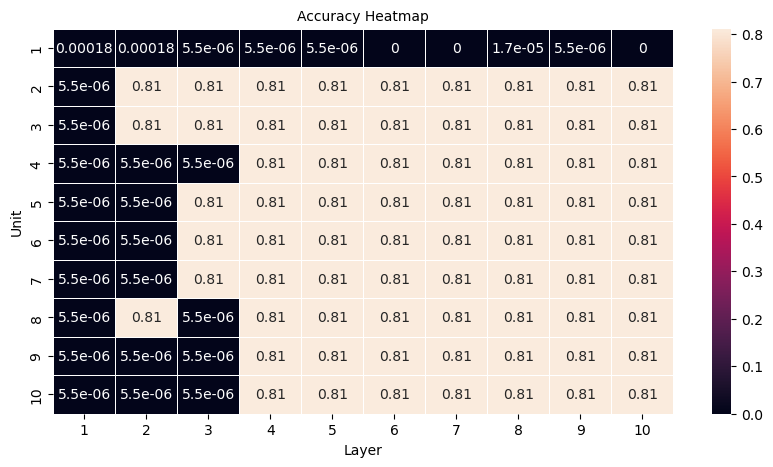

In [219]:
xlabels = range(1, max_range_unit)
ylabels = range(1, max_range_layer)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(acc_arr, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Accuracy Heatmap', fontsize=10)
ax.set_xlabel('Unit', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

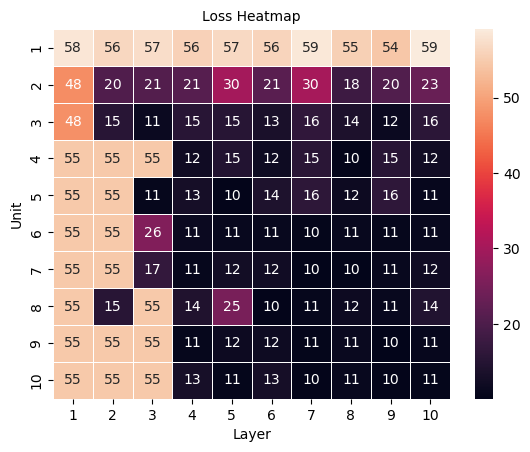

In [221]:
#fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(loss_arr, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Loss Heatmap', fontsize=10)
ax.set_xlabel('Unit', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

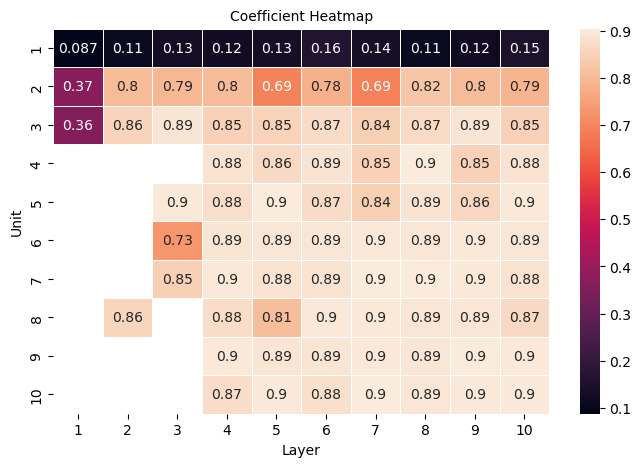

In [224]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(coef_arr, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Coefficient Heatmap', fontsize=10)
ax.set_xlabel('Unit', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

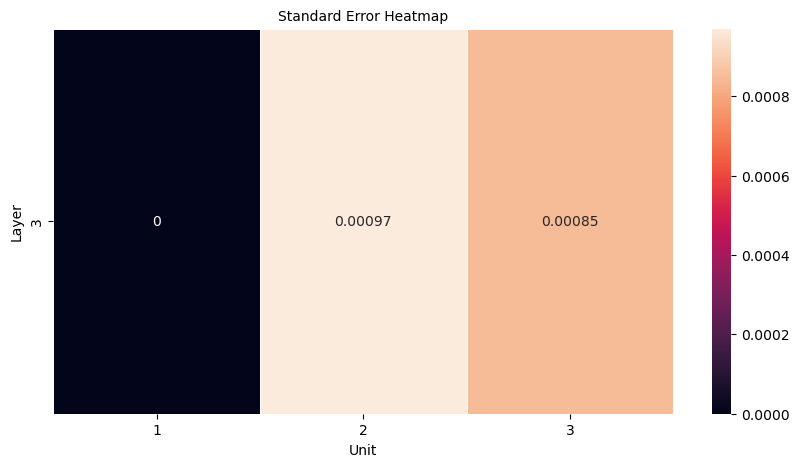

In [286]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(err_arr, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Standard Error Heatmap', fontsize=10)
ax.set_xlabel('Unit', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

### Different unit size

In [273]:
def create_different_unit_nn(layer_size, unit_sizes):
    model = keras.Sequential()
    for i in range(1, layer_size):
        if i == 1:
            model.add(Dense(unit_sizes[0], activation='relu', input_shape=(len(X_train[0]),)))
        else:
            model.add(Dense(unit_sizes[i-1], activation='relu'))
    
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test], callbacks=myCallbacks)
    
    y_predict = model.predict(X_test)
    evaluate = model.evaluate(X_test, y_test)
    corr = np.corrcoef(y_predict.flatten(), y_test)
    m, b, r, p, st_er = stats.linregress(y_test.flatten(), y_predict.flatten()) 
    
    loss = evaluate[0]
    acc = evaluate[1]
    coef = corr[0][1]
    
    return acc, loss, coef, st_er

In [288]:
max_range_layer = 11
max_range_unit = 11
acc_arr2 = []
loss_arr2 = []
coef_arr2 = []
err_arr2 = []
size_arr2 = []
for i in range(3, max_range_layer):
    acc_unit = []
    loss_unit = []
    coef_unit = []
    err_unit = []
    size_unit = []
    for j in range(1, max_range_unit):
        idx = 0
        sub = j / i
        units = []
        for l in range(j, i):
            units.append(j)

        for k in range(j, 0, -1):
            if k == j: 
                unit = k
            elif idx == i:
                break
            else:
                unit = int(unit - sub)

            if unit < 1:
                unit = 1
            units.append(unit)
            idx = idx+1

        print("##### Layer:"+str(i)+" Unit:"+str(j)+" #####")
        acc, loss, coef, err = create_different_unit_nn(i, units)
        acc_unit.append(acc)
        loss_unit.append(loss)
        coef_unit.append(coef)
        err_unit.append(err)
        size_unit(units)
    
    acc_arr2.append(acc_unit)
    loss_arr2.append(loss_unit)
    coef_arr2.append(coef_unit)
    err_arr2.append(err_unit)
    size_arr2.append(size_unit)

##### Layer:3 Unit:1 #####
Epoch 1/100
28160/28160 [==============================] - 30s 1ms/step - loss: 82.3526 - accuracy: 0.0904 - val_loss: 47.7263 - val_accuracy: 5.5487e-06
Epoch 2/100
28160/28160 [==============================] - 29s 1ms/step - loss: 40.7908 - accuracy: 5.5487e-06 - val_loss: 47.1735 - val_accuracy: 5.5487e-06
Epoch 3/100
28160/28160 [==============================] - 33s 1ms/step - loss: 40.8579 - accuracy: 5.5487e-06 - val_loss: 47.2789 - val_accuracy: 5.5487e-06
Epoch 4/100
28160/28160 [==============================] - 30s 1ms/step - loss: 40.7323 - accuracy: 5.5487e-06 - val_loss: 47.2703 - val_accuracy: 5.5487e-06
Epoch 5/100
28160/28160 [==============================] - 32s 1ms/step - loss: 40.8503 - accuracy: 5.5487e-06 - val_loss: 47.2838 - val_accuracy: 5.5487e-06
Epoch 6/100
28160/28160 [==============================] - 31s 1ms/step - loss: 40.8853 - accuracy: 5.5487e-06 - val_loss: 47.5960 - val_accuracy: 5.5487e-06
Epoch 7/100
28160/28160 [====

28160/28160 [==============================] - 30s 1ms/step - loss: 18.0804 - accuracy: 0.4067 - val_loss: 18.7812 - val_accuracy: 0.8114
Epoch 7/100
28160/28160 [==============================] - 26s 928us/step - loss: 18.7898 - accuracy: 0.6534 - val_loss: 14.9118 - val_accuracy: 0.8114
Epoch 8/100
28160/28160 [==============================] - 1825s 65ms/step - loss: 15.8776 - accuracy: 0.6411 - val_loss: 17.0777 - val_accuracy: 0.8114
Epoch 9/100
28160/28160 [==============================] - 26s 939us/step - loss: 14.0130 - accuracy: 0.8114 - val_loss: 13.3281 - val_accuracy: 0.8114
Epoch 10/100
28160/28160 [==============================] - 924s 33ms/step - loss: 14.5508 - accuracy: 0.7401 - val_loss: 14.4592 - val_accuracy: 0.8114
Epoch 11/100
28160/28160 [==============================] - 26s 910us/step - loss: 13.8873 - accuracy: 0.8114 - val_loss: 13.6286 - val_accuracy: 0.8114
Epoch 12/100
28160/28160 [==============================] - 27s 942us/step - loss: 13.4420 - accura

28160/28160 [==============================] - 28s 977us/step - loss: 12.0501 - accuracy: 0.8114 - val_loss: 11.8449 - val_accuracy: 0.8114
Epoch 9/100
28160/28160 [==============================] - 28s 1ms/step - loss: 12.1363 - accuracy: 0.8114 - val_loss: 12.7538 - val_accuracy: 0.8112
Epoch 10/100
28160/28160 [==============================] - 28s 979us/step - loss: 11.9761 - accuracy: 0.8114 - val_loss: 11.7755 - val_accuracy: 0.8114
Epoch 11/100
28160/28160 [==============================] - 27s 963us/step - loss: 11.8840 - accuracy: 0.8114 - val_loss: 11.8231 - val_accuracy: 0.8112
Epoch 12/100
28160/28160 [==============================] - 28s 1ms/step - loss: 11.9246 - accuracy: 0.8114 - val_loss: 12.2749 - val_accuracy: 0.8114
Epoch 13/100
5632/5632 [==============================] - 4s 759us/step - loss: 11.8164 - accuracy: 0.8114
##### Layer:4 Unit:5 #####
Epoch 1/100
28160/28160 [==============================] - 27s 954us/step - loss: 10275.0479 - accuracy: 0.2450 - val_l

28160/28160 [==============================] - 1126s 40ms/step - loss: 15.5145 - accuracy: 0.8113 - val_loss: 15.4497 - val_accuracy: 0.8112
Epoch 3/100
28160/28160 [==============================] - 27s 949us/step - loss: 13.7325 - accuracy: 0.8113 - val_loss: 14.2192 - val_accuracy: 0.8112
Epoch 4/100
28160/28160 [==============================] - 27s 967us/step - loss: 12.4976 - accuracy: 0.8112 - val_loss: 13.1986 - val_accuracy: 0.8112
Epoch 5/100
28160/28160 [==============================] - 555s 20ms/step - loss: 12.6067 - accuracy: 0.8112 - val_loss: 12.4234 - val_accuracy: 0.8112
Epoch 6/100
28160/28160 [==============================] - 32s 1ms/step - loss: 12.1778 - accuracy: 0.8110 - val_loss: 12.0861 - val_accuracy: 0.8112
Epoch 7/100
28160/28160 [==============================] - 29s 1ms/step - loss: 12.0679 - accuracy: 0.8112 - val_loss: 14.7665 - val_accuracy: 0.8112
Epoch 8/100
28160/28160 [==============================] - 28s 1ms/step - loss: 11.7176 - accuracy: 0.8

28160/28160 [==============================] - 29s 1ms/step - loss: 12.3602 - accuracy: 0.8113 - val_loss: 13.1564 - val_accuracy: 0.8114
Epoch 8/100
28160/28160 [==============================] - 29s 1ms/step - loss: 12.2229 - accuracy: 0.8111 - val_loss: 11.2359 - val_accuracy: 0.8112
Epoch 9/100
28160/28160 [==============================] - 29s 1ms/step - loss: 11.8366 - accuracy: 0.8113 - val_loss: 11.4466 - val_accuracy: 0.8112
Epoch 10/100
28160/28160 [==============================] - 29s 1ms/step - loss: 11.6033 - accuracy: 0.8113 - val_loss: 12.2527 - val_accuracy: 0.8114
Epoch 11/100
28160/28160 [==============================] - 29s 1ms/step - loss: 11.4801 - accuracy: 0.8112 - val_loss: 10.9577 - val_accuracy: 0.8114
Epoch 12/100
28160/28160 [==============================] - 29s 1ms/step - loss: 11.5032 - accuracy: 0.8113 - val_loss: 11.8089 - val_accuracy: 0.8114
Epoch 13/100
28160/28160 [==============================] - 29s 1ms/step - loss: 11.4582 - accuracy: 0.8113 -

Epoch 10/100
28160/28160 [==============================] - 38s 1ms/step - loss: 11.7218 - accuracy: 0.8114 - val_loss: 12.8822 - val_accuracy: 0.8112
Epoch 11/100
28160/28160 [==============================] - 39s 1ms/step - loss: 12.0761 - accuracy: 0.8113 - val_loss: 13.5324 - val_accuracy: 0.8112
Epoch 12/100
5632/5632 [==============================] - 7s 1ms/step - loss: 11.4044 - accuracy: 0.8112
##### Layer:6 Unit:6 #####
Epoch 1/100
28160/28160 [==============================] - 42s 1ms/step - loss: 26.9500 - accuracy: 0.5179 - val_loss: 26.1151 - val_accuracy: 0.8112
Epoch 2/100
28160/28160 [==============================] - 42s 1ms/step - loss: 16.6773 - accuracy: 0.8112 - val_loss: 13.7098 - val_accuracy: 0.8112
Epoch 3/100
28160/28160 [==============================] - 39s 1ms/step - loss: 14.7945 - accuracy: 0.8112 - val_loss: 14.7303 - val_accuracy: 0.8112
Epoch 4/100
28160/28160 [==============================] - 36s 1ms/step - loss: 13.7194 - accuracy: 0.8087 - val_los

Epoch 5/100
28160/28160 [==============================] - 51s 2ms/step - loss: 54.6993 - accuracy: 5.5487e-06 - val_loss: 54.7007 - val_accuracy: 5.5487e-06
Epoch 6/100
28160/28160 [==============================] - 52s 2ms/step - loss: 54.6988 - accuracy: 5.5487e-06 - val_loss: 54.7001 - val_accuracy: 5.5487e-06
Epoch 7/100
28160/28160 [==============================] - 52s 2ms/step - loss: 54.6991 - accuracy: 5.5487e-06 - val_loss: 54.6983 - val_accuracy: 5.5487e-06
Epoch 8/100
28160/28160 [==============================] - 53s 2ms/step - loss: 54.6998 - accuracy: 5.5487e-06 - val_loss: 54.6965 - val_accuracy: 5.5487e-06
Epoch 9/100
28160/28160 [==============================] - 53s 2ms/step - loss: 54.6993 - accuracy: 5.5487e-06 - val_loss: 54.6963 - val_accuracy: 5.5487e-06
Epoch 10/100
28160/28160 [==============================] - 52s 2ms/step - loss: 54.6994 - accuracy: 5.5487e-06 - val_loss: 54.6992 - val_accuracy: 5.5487e-06
Epoch 11/100
5632/5632 [===========================

28160/28160 [==============================] - 30s 1ms/step - loss: 54.6995 - accuracy: 5.5487e-06 - val_loss: 54.6973 - val_accuracy: 5.5487e-06
Epoch 6/100
28160/28160 [==============================] - 30s 1ms/step - loss: 54.6993 - accuracy: 5.5487e-06 - val_loss: 54.7011 - val_accuracy: 5.5487e-06
Epoch 7/100
28160/28160 [==============================] - 30s 1ms/step - loss: 54.6994 - accuracy: 5.5487e-06 - val_loss: 54.7001 - val_accuracy: 5.5487e-06
Epoch 8/100
28160/28160 [==============================] - 30s 1ms/step - loss: 54.6997 - accuracy: 5.5487e-06 - val_loss: 54.6965 - val_accuracy: 5.5487e-06
Epoch 9/100
28160/28160 [==============================] - 29s 1ms/step - loss: 54.6996 - accuracy: 5.5487e-06 - val_loss: 54.7010 - val_accuracy: 5.5487e-06
Epoch 10/100
28160/28160 [==============================] - 30s 1ms/step - loss: 54.6994 - accuracy: 5.5487e-06 - val_loss: 54.6989 - val_accuracy: 5.5487e-06
Epoch 11/100
5632/5632 [==============================] - 4s 79

28160/28160 [==============================] - 32s 1ms/step - loss: 14.5835 - accuracy: 0.8107 - val_loss: 13.9292 - val_accuracy: 0.8114
Epoch 12/100
28160/28160 [==============================] - 31s 1ms/step - loss: 14.4296 - accuracy: 0.8107 - val_loss: 15.4259 - val_accuracy: 0.8114
Epoch 13/100
28160/28160 [==============================] - 31s 1ms/step - loss: 13.6122 - accuracy: 0.8112 - val_loss: 20.6199 - val_accuracy: 0.8114
Epoch 14/100
28160/28160 [==============================] - 30s 1ms/step - loss: 15.4682 - accuracy: 0.8109 - val_loss: 19.8791 - val_accuracy: 0.8112
Epoch 15/100
28160/28160 [==============================] - 31s 1ms/step - loss: 15.0370 - accuracy: 0.8113 - val_loss: 38.0089 - val_accuracy: 0.8114
Epoch 16/100
28160/28160 [==============================] - 31s 1ms/step - loss: 14.7497 - accuracy: 0.8113 - val_loss: 13.1482 - val_accuracy: 0.8112
Epoch 17/100
28160/28160 [==============================] - 30s 1ms/step - loss: 13.1384 - accuracy: 0.8112

28160/28160 [==============================] - 31s 1ms/step - loss: 54.6996 - accuracy: 5.5487e-06 - val_loss: 54.6969 - val_accuracy: 5.5487e-06
Epoch 9/100
28160/28160 [==============================] - 32s 1ms/step - loss: 54.6993 - accuracy: 5.5487e-06 - val_loss: 54.6976 - val_accuracy: 5.5487e-06
Epoch 10/100
28160/28160 [==============================] - 32s 1ms/step - loss: 54.6994 - accuracy: 5.5487e-06 - val_loss: 54.6991 - val_accuracy: 5.5487e-06
Epoch 11/100
5632/5632 [==============================] - 4s 787us/step - loss: 54.6964 - accuracy: 5.5487e-06
##### Layer:9 Unit:4 #####
Epoch 1/100
28160/28160 [==============================] - 31s 1ms/step - loss: 24.3821 - accuracy: 0.5252 - val_loss: 16.5912 - val_accuracy: 0.8112
Epoch 2/100
28160/28160 [==============================] - 31s 1ms/step - loss: 13.0940 - accuracy: 0.8113 - val_loss: 12.3550 - val_accuracy: 0.8112
Epoch 3/100
28160/28160 [==============================] - 31s 1ms/step - loss: 12.7025 - accuracy:

28160/28160 [==============================] - 31s 1ms/step - loss: 54.6998 - accuracy: 5.5487e-06 - val_loss: 54.6976 - val_accuracy: 5.5487e-06
Epoch 9/100
28160/28160 [==============================] - 31s 1ms/step - loss: 54.6998 - accuracy: 5.5487e-06 - val_loss: 54.6991 - val_accuracy: 5.5487e-06
Epoch 10/100
28160/28160 [==============================] - 31s 1ms/step - loss: 54.6992 - accuracy: 5.5487e-06 - val_loss: 54.6997 - val_accuracy: 5.5487e-06
Epoch 11/100
5632/5632 [==============================] - 5s 803us/step - loss: 54.6966 - accuracy: 5.5487e-06
##### Layer:9 Unit:8 #####
Epoch 1/100
28160/28160 [==============================] - 32s 1ms/step - loss: 22.2618 - accuracy: 0.6168 - val_loss: 11.8126 - val_accuracy: 0.8114
Epoch 2/100
28160/28160 [==============================] - 32s 1ms/step - loss: 13.6988 - accuracy: 0.8047 - val_loss: 20.8246 - val_accuracy: 0.8114
Epoch 3/100
28160/28160 [==============================] - 31s 1ms/step - loss: 12.1737 - accuracy:

5632/5632 [==============================] - 5s 837us/step - loss: 54.6978 - accuracy: 5.5487e-06
##### Layer:10 Unit:6 #####
Epoch 1/100
28160/28160 [==============================] - 33s 1ms/step - loss: 25.9155 - accuracy: 0.7380 - val_loss: 18.8334 - val_accuracy: 0.8112
Epoch 2/100
28160/28160 [==============================] - 32s 1ms/step - loss: 14.1379 - accuracy: 0.8113 - val_loss: 11.1160 - val_accuracy: 0.8112
Epoch 3/100
28160/28160 [==============================] - 32s 1ms/step - loss: 12.7977 - accuracy: 0.8112 - val_loss: 12.0923 - val_accuracy: 0.8112
Epoch 4/100
28160/28160 [==============================] - 33s 1ms/step - loss: 13.0226 - accuracy: 0.8112 - val_loss: 11.1222 - val_accuracy: 0.8112
Epoch 5/100
28160/28160 [==============================] - 32s 1ms/step - loss: 12.7506 - accuracy: 0.8112 - val_loss: 15.7952 - val_accuracy: 0.8112
Epoch 6/100
28160/28160 [==============================] - 32s 1ms/step - loss: 12.2268 - accuracy: 0.8112 - val_loss: 13.87

28160/28160 [==============================] - 33s 1ms/step - loss: 14.5054 - accuracy: 0.7804 - val_loss: 14.7246 - val_accuracy: 5.5487e-06
Epoch 3/100
28160/28160 [==============================] - 33s 1ms/step - loss: 12.2041 - accuracy: 0.7836 - val_loss: 11.3268 - val_accuracy: 0.8112
Epoch 4/100
28160/28160 [==============================] - 33s 1ms/step - loss: 12.4589 - accuracy: 0.8016 - val_loss: 11.1238 - val_accuracy: 0.8112
Epoch 5/100
28160/28160 [==============================] - 33s 1ms/step - loss: 12.4015 - accuracy: 0.7966 - val_loss: 10.7455 - val_accuracy: 0.8112
Epoch 6/100
28160/28160 [==============================] - 33s 1ms/step - loss: 14.1058 - accuracy: 0.7906 - val_loss: 11.5228 - val_accuracy: 0.8112
Epoch 7/100
28160/28160 [==============================] - 33s 1ms/step - loss: 14.0696 - accuracy: 0.7941 - val_loss: 13.5147 - val_accuracy: 0.8112
Epoch 8/100
28160/28160 [==============================] - 33s 1ms/step - loss: 11.8816 - accuracy: 0.7976 -

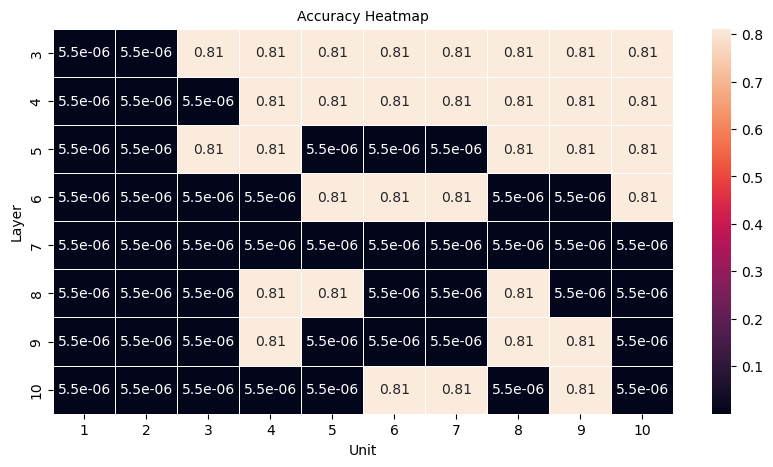

In [289]:
xlabels = range(1, max_range_unit)
ylabels = range(3, max_range_layer)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(acc_arr2, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Accuracy Heatmap', fontsize=10)
ax.set_xlabel('Unit', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

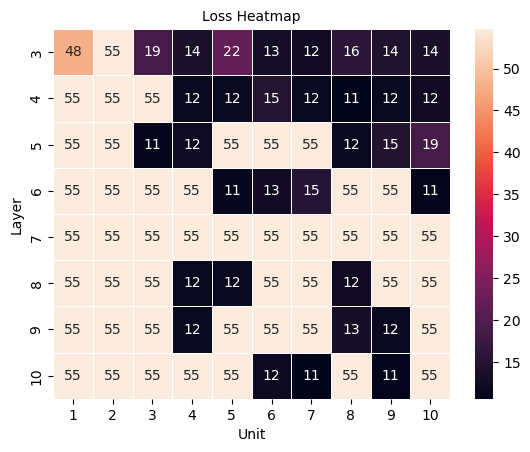

In [290]:
ax = sns.heatmap(loss_arr2, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Loss Heatmap', fontsize=10)
ax.set_xlabel('Unit', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

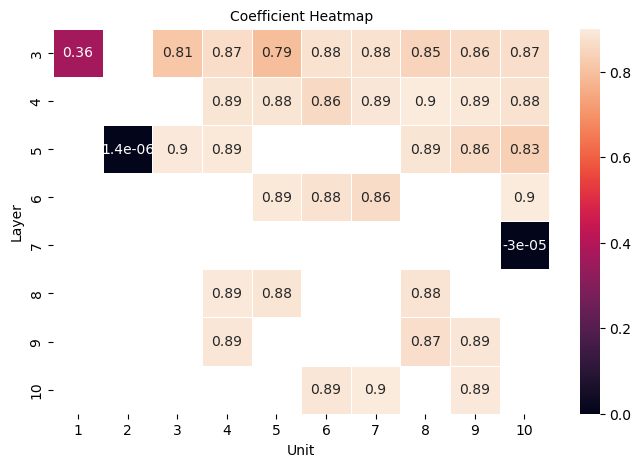

In [291]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(coef_arr2, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Coefficient Heatmap', fontsize=10)
ax.set_xlabel('Unit', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

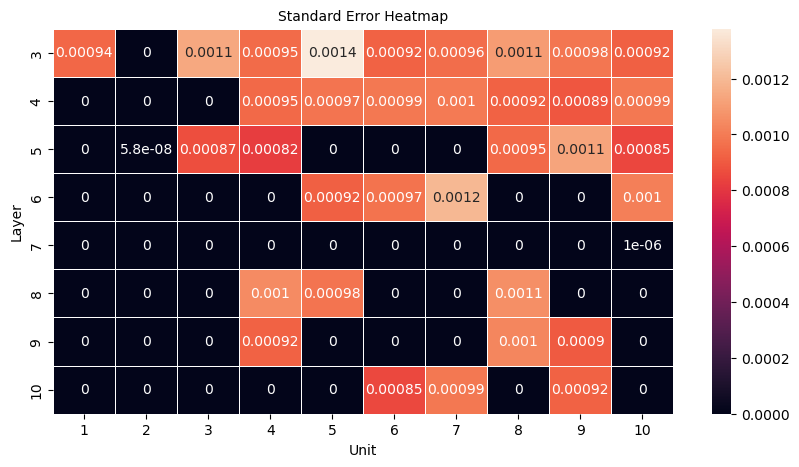

In [292]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(err_arr2, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Standard Error Heatmap', fontsize=10)
ax.set_xlabel('Unit', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

In [383]:
max_range_layer = 11
max_range_unit = 11
size_arr2 = []
for i in range(3, max_range_layer):
    size_unit = []
    for j in range(1, max_range_unit):
        idx = 0
        sub = j / i
        units = []
        for l in range(j, i):
            units.append(j)

        for k in range(j, 0, -1):
            if k == j: 
                unit = k
            elif idx == i:
                break
            else:
                unit = int(unit - sub)

            if unit < 1:
                unit = 1
            units.append(unit)
            idx = idx+1

        print("##### Layer:"+str(i)+" Unit:"+str(j)+" #####")
        print(units)
        size_unit.append(units)
    
    size_arr2.append(size_unit)

##### Layer:3 Unit:1 #####
[1, 1, 1]
##### Layer:3 Unit:2 #####
[2, 2, 1]
##### Layer:3 Unit:3 #####
[3, 2, 1]
##### Layer:3 Unit:4 #####
[4, 2, 1]
##### Layer:3 Unit:5 #####
[5, 3, 1]
##### Layer:3 Unit:6 #####
[6, 4, 2]
##### Layer:3 Unit:7 #####
[7, 4, 1]
##### Layer:3 Unit:8 #####
[8, 5, 2]
##### Layer:3 Unit:9 #####
[9, 6, 3]
##### Layer:3 Unit:10 #####
[10, 6, 2]
##### Layer:4 Unit:1 #####
[1, 1, 1, 1]
##### Layer:4 Unit:2 #####
[2, 2, 2, 1]
##### Layer:4 Unit:3 #####
[3, 3, 2, 1]
##### Layer:4 Unit:4 #####
[4, 3, 2, 1]
##### Layer:4 Unit:5 #####
[5, 3, 1, 1]
##### Layer:4 Unit:6 #####
[6, 4, 2, 1]
##### Layer:4 Unit:7 #####
[7, 5, 3, 1]
##### Layer:4 Unit:8 #####
[8, 6, 4, 2]
##### Layer:4 Unit:9 #####
[9, 6, 3, 1]
##### Layer:4 Unit:10 #####
[10, 7, 4, 1]
##### Layer:5 Unit:1 #####
[1, 1, 1, 1, 1]
##### Layer:5 Unit:2 #####
[2, 2, 2, 2, 1]
##### Layer:5 Unit:3 #####
[3, 3, 3, 2, 1]
##### Layer:5 Unit:4 #####
[4, 4, 3, 2, 1]
##### Layer:5 Unit:5 #####
[5, 4, 3, 2, 1]
##### Layer

In [384]:
size_arr2

[[[1, 1, 1],
  [2, 2, 1],
  [3, 2, 1],
  [4, 2, 1],
  [5, 3, 1],
  [6, 4, 2],
  [7, 4, 1],
  [8, 5, 2],
  [9, 6, 3],
  [10, 6, 2]],
 [[1, 1, 1, 1],
  [2, 2, 2, 1],
  [3, 3, 2, 1],
  [4, 3, 2, 1],
  [5, 3, 1, 1],
  [6, 4, 2, 1],
  [7, 5, 3, 1],
  [8, 6, 4, 2],
  [9, 6, 3, 1],
  [10, 7, 4, 1]],
 [[1, 1, 1, 1, 1],
  [2, 2, 2, 2, 1],
  [3, 3, 3, 2, 1],
  [4, 4, 3, 2, 1],
  [5, 4, 3, 2, 1],
  [6, 4, 2, 1, 1],
  [7, 5, 3, 1, 1],
  [8, 6, 4, 2, 1],
  [9, 7, 5, 3, 1],
  [10, 8, 6, 4, 2]],
 [[1, 1, 1, 1, 1, 1],
  [2, 2, 2, 2, 2, 1],
  [3, 3, 3, 3, 2, 1],
  [4, 4, 4, 3, 2, 1],
  [5, 5, 4, 3, 2, 1],
  [6, 5, 4, 3, 2, 1],
  [7, 5, 3, 1, 1, 1],
  [8, 6, 4, 2, 1, 1],
  [9, 7, 5, 3, 1, 1],
  [10, 8, 6, 4, 2, 1]],
 [[1, 1, 1, 1, 1, 1, 1],
  [2, 2, 2, 2, 2, 2, 1],
  [3, 3, 3, 3, 3, 2, 1],
  [4, 4, 4, 4, 3, 2, 1],
  [5, 5, 5, 4, 3, 2, 1],
  [6, 6, 5, 4, 3, 2, 1],
  [7, 6, 5, 4, 3, 2, 1],
  [8, 6, 4, 2, 1, 1, 1],
  [9, 7, 5, 3, 1, 1, 1],
  [10, 8, 6, 4, 2, 1, 1]],
 [[1, 1, 1, 1, 1, 1, 1, 1],
  [2, 2, 2, 

## Find out Hyper paramater 

In [64]:
# Use best layer and unit
shape = (len(X_train[0]),)
def create_model(optimizer="adam"):
    model = keras.Sequential()
    model.add(Dense(8, activation='relu', input_shape=shape)) 
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mse', metrics=["accuracy"])
    return model

### Epoch

In [71]:
estimator = KerasRegressor(model=create_model, verbose=1)

In [72]:

# define the grid search parameters
param_grid = {
    'epochs': [100, 250, 500]
}

In [73]:
grid1 = GridSearchCV(estimator=estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=2,
                    param_grid=param_grid)

In [74]:
grid1_result = grid1.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


2022-11-02 14:19:21.391038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 14:19:21.391114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 14:19:21.392767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

Epoch 1/100
Epoch 1/100
Epoch 1/250
Epoch 1/250
14080/14080 [==============================] - 20s 1ms/step - loss: 192.1774 - accuracy: 0.3374
Epoch 2/250
14080/14080 [==============================] - 20s 1ms/step - loss: 39.0216 - accuracy: 0.3349
Epoch 2/250
14080/14080 [==============================] - 20s 1ms/step - loss: 84.6073 - accuracy: 0.6539
Epoch 2/100
14080/14080 [==============================] - 20s 1ms/step - loss: 64.2614 - accuracy: 0.6282
Epoch 2/100
14080/14080 [==============================] - 19s 1ms/step - loss: 27.7406 - accuracy: 0.8115
Epoch 3/250
14080/14080 [==============================] - 19s 1ms/step - loss: 21.9598 - accuracy: 0.8094
Epoch 3/100
14080/14080 [==============================] - 19s 1ms/step - loss: 26.4712 - accuracy: 0.7823
Epoch 3/100
14080/14080 [==============================] - 19s 1ms/step - loss: 23.4687 - accuracy: 0.8115
Epoch 4/250
14080/14080 [==============================] - 19s 1ms/step - loss: 13.1862 - accuracy: 0.8110


14080/14080 [==============================] - 22s 2ms/step - loss: 11.2894 - accuracy: 0.8095===============>......] - ETA: 4s - loss: 11.4825 -
Epoch 36/250
14080/14080 [==============================] - 22s 2ms/step - loss: 11.1369 - accuracy: 0.8100
Epoch 36/250
14080/14080 [==============================] - 21s 2ms/step - loss: 11.0811 - accuracy: 0.8094
Epoch 36/100
14080/14080 [==============================] - 19s 1ms/step - loss: 11.7748 - accuracy: 0.8098
Epoch 37/250
14080/14080 [==============================] - 19s 1ms/step - loss: 11.0164 - accuracy: 0.8081
Epoch 37/250
14080/14080 [==============================] - 19s 1ms/step - loss: 11.5126 - accuracy: 0.7750
Epoch 37/100
14080/14080 [==============================] - 19s 1ms/step - loss: 10.9989 - accuracy: 0.8110
Epoch 37/100
14080/14080 [==============================] - 19s 1ms/step - loss: 11.2287 - accuracy: 0.8089
Epoch 38/250
14080/14080 [==============================] - 19s 1ms/step - loss: 11.2972 - accurac

 9729/14080 [===================>..........] - ETA: 8s - loss: 11.1533 - accuracy: 0.7945

14080/14080 [==============================] - 25s 2ms/step - loss: 11.3955 - accuracy: 0.8088
Epoch 53/250
14080/14080 [==============================] - 24s 2ms/step - loss: 10.8651 - accuracy: 0.8058
Epoch 53/250
14080/14080 [==============================] - 25s 2ms/step - loss: 11.0783 - accuracy: 0.7916
Epoch 53/100
14080/14080 [==============================] - 26s 2ms/step - loss: 10.9755 - accuracy: 0.8110] - ETA: 1s - loss: 11.0101 - accuracy: 0. - ETA: 21s - loss: 10.3838 - accuracy: 0.79
Epoch 53/100
14080/14080 [==============================] - 25s 2ms/step - loss: 11.4026 - accuracy: 0.8037
Epoch 54/250
14080/14080 [==============================] - 25s 2ms/step - loss: 10.9167 - accuracy: 0.8088======>.] - ETA: 0s - loss: 10.8509 - accuracy: 0.808
Epoch 54/250
14080/14080 [==============================] - 26s 2ms/step - loss: 11.2881 - accuracy: 0.8029
Epoch 54/100
14080/14080 [==============================] - 26s 2ms/step - loss: 10.9486 - accuracy: 0.8110
Epoch 54/1

14080/14080 [==============================] - 28s 2ms/step - loss: 10.9050 - accuracy: 0.8100] - ETA: 18s - loss: 10.1611 - accuracy: 0.8101................] - ETA: 17s - loss: 9.7365 - accuracy: 0.810287 - accuracy: 0.7890 [=========>....................] - ETA: 17s - loss: 9.7407 - accuracy: 0.81 - accuracy: 0.7ETA: 15s - loss: 10.5743 - accuracy: 0.8080 [============>.................] - ETA: 15s - loss: 11.2679 - accuracy: 0. 24s - loss: 14.4018 - accuracy: 0.804y: 0.81==>..........................] - ETA: 24s - loss: 13.6564 - accuracy: 0. 10.8893 - accuracy: 0.80930/14080 [==================>...........] - ETA: 9s - loss: 10.8674 - accuracy: 0.881..................] - ETA: 23s - loss: 13.6742 - accuracy: 0.80 10.7396 - accuracy: 0.81124/14080 [=====>........................] - ETA: 22s - loss: 13.6029 - accuracy: 0.==================>..] - ETA: 1s - loss: 10.9975 - accuracy: 0.800.81=================>.] - ETA: 0s - loss: 10.9449 - accuracy: 0.80
Epoch 84/100
14080/14080 [=======

14080/14080 [==============================] - 22s 2ms/step - loss: 10.9310 - accuracy: 0.8072
Epoch 100/100
14080/14080 [==============================] - 22s 2ms/step - loss: 10.5963 - accuracy: 0.8103
Epoch 100/100
14080/14080 [==============================] - 21s 2ms/step - loss: 11.2433 - accuracy: 0.8087
Epoch 101/250
14080/14080 [==============================] - 21s 2ms/step - loss: 10.6408 - accuracy: 0.8094
Epoch 101/250
14080/14080 [==============================] - 22s 2ms/step - loss: 11.3492 - accuracy: 0.8093
Epoch 102/250
14080/14080 [==============================] - 22s 2ms/step - loss: 10.6412 - accuracy: 0.8099
Epoch 102/250
14080/14080 [==============================] - 21s 2ms/step - loss: 11.3043 - accuracy: 0.8110
Epoch 103/250
14080/14080 [==============================] - 20s 1ms/step - loss: 10.6202 - accuracy: 0.8080
Epoch 103/250
14080/14080 [==============================] - 17s 1ms/step - loss: 11.5200 - accuracy: 0.8100
Epoch 104/250
14080/14080 [======

14080/14080 [==============================] - 22s 2ms/step - loss: 10.6038 - accuracy: 0.8075
Epoch 117/250
14080/14080 [==============================] - 22s 2ms/step - loss: 11.4106 - accuracy: 0.8090
Epoch 13/500
14080/14080 [==============================] - 21s 1ms/step - loss: 12.8597 - accuracy: 0.8116
Epoch 15/500
14080/14080 [==============================] - 21s 1ms/step - loss: 11.2960 - accuracy: 0.8115
Epoch 118/250
14080/14080 [==============================] - 20s 1ms/step - loss: 10.6120 - accuracy: 0.8087
Epoch 118/250
14080/14080 [==============================] - 20s 1ms/step - loss: 11.4175 - accuracy: 0.8043
Epoch 14/500
14080/14080 [==============================] - 20s 1ms/step - loss: 11.3530 - accuracy: 0.8096
Epoch 119/250
14080/14080 [==============================] - 20s 1ms/step - loss: 12.7544 - accuracy: 0.8107
Epoch 16/500
14080/14080 [==============================] - 20s 1ms/step - loss: 10.5586 - accuracy: 0.8074
Epoch 119/250
14080/14080 [==========

 3074/14080 [=====>........................] - ETA: 19s - loss: 8.4349 - accuracy: 0.8108

14080/14080 [==============================] - 26s 2ms/step - loss: 11.1065 - accuracy: 0.8110
Epoch 29/500
14080/14080 [==============================] - 26s 2ms/step - loss: 11.5040 - accuracy: 0.8109
Epoch 134/250
14080/14080 [==============================] - 26s 2ms/step - loss: 11.6686 - accuracy: 0.81026
Epoch 31/500
14080/14080 [==============================] - 25s 2ms/step - loss: 10.5909 - accuracy: 0.8060
Epoch 134/250
14080/14080 [==============================] - 26s 2ms/step - loss: 11.0903 - accuracy: 0.81105504 - accuracy: 0.8102368/14080 [====>.........................] - ETA: 20s - loss: 9.9035 - accuracy: 0.8
Epoch 30/500
14080/14080 [==============================] - 26s 2ms/step - loss: 11.1569 - accuracy: 0.8110
Epoch 135/250
14080/14080 [==============================] - 27s 2ms/step - loss: 11.6734 - accuracy: 0.8096
Epoch 32/500
14080/14080 [==============================] - 26s 2ms/step - loss: 10.5436 - accuracy: 0.8094
Epoch 135/250
14080/14080 [===========

14080/14080 [==============================] - 21s 2ms/step - loss: 11.0581 - accuracy: 0.8093
Epoch 166/250
14080/14080 [==============================] - 21s 1ms/step - loss: 10.5659 - accuracy: 0.8057
Epoch 166/250
14080/14080 [==============================] - 21s 2ms/step - loss: 10.5949 - accuracy: 0.8110
Epoch 61/500
14080/14080 [==============================] - 21s 2ms/step - loss: 11.4759 - accuracy: 0.8115
Epoch 63/500
14080/14080 [==============================] - 21s 2ms/step - loss: 11.0479 - accuracy: 0.8089
Epoch 167/250
14080/14080 [==============================] - 22s 2ms/step - loss: 10.5040 - accuracy: 0.8072===========>..........] - ETA: 7s - loss: 11.6176 - accuracy:
Epoch 167/250
14080/14080 [==============================] - 22s 2ms/step - loss: 11.2057 - accuracy: 0.8110
Epoch 62/500
14080/14080 [==============================] - 22s 2ms/step - loss: 11.4513 - accuracy: 0.8115
Epoch 64/500
14080/14080 [==============================] - 22s 2ms/step - loss: 10.

14080/14080 [==============================] - 20s 1ms/step - loss: 10.9657 - accuracy: 0.8110=======================>....] - ETA: 2s - loss: 10.6763 -
Epoch 183/250
14080/14080 [==============================] - 21s 1ms/step - loss: 10.5852 - accuracy: 0.8074
Epoch 183/250
14080/14080 [==============================] - 21s 1ms/step - loss: 11.5184 - accuracy: 0.8115
Epoch 80/500
14080/14080 [==============================] - 21s 1ms/step - loss: 10.6262 - accuracy: 0.8110
Epoch 78/500
14080/14080 [==============================] - 20s 1ms/step - loss: 11.1025 - accuracy: 0.8093
Epoch 184/250
14080/14080 [==============================] - 21s 1ms/step - loss: 10.6810 - accuracy: 0.8063
Epoch 184/250
14080/14080 [==============================] - 21s 1ms/step - loss: 11.2298 - accuracy: 0.8115
Epoch 81/500
14080/14080 [==============================] - 21s 2ms/step - loss: 10.5260 - accuracy: 0.8110
Epoch 79/500
14080/14080 [==============================] - 21s 1ms/step - loss: 10.9927

14080/14080 [==============================] - 21s 1ms/step - loss: 10.7718 - accuracy: 0.8106
Epoch 218/250
14080/14080 [==============================] - 21s 2ms/step - loss: 11.2226 - accuracy: 0.8101
Epoch 114/500
14080/14080 [==============================] - 21s 1ms/step - loss: 10.4728 - accuracy: 0.8103
Epoch 218/250
14080/14080 [==============================] - 21s 2ms/step - loss: 14.1309 - accuracy: 0.8110
Epoch 112/500
14080/14080 [==============================] - 21s 1ms/step - loss: 10.7747 - accuracy: 0.8095
Epoch 219/250
14080/14080 [==============================] - 21s 1ms/step - loss: 11.3920 - accuracy: 0.8102
Epoch 115/500
14080/14080 [==============================] - 21s 1ms/step - loss: 10.4408 - accuracy: 0.8108
Epoch 219/250
14080/14080 [==============================] - 21s 2ms/step - loss: 11.3630 - accuracy: 0.8103
Epoch 113/500
14080/14080 [==============================] - 21s 1ms/step - loss: 10.9975 - accuracy: 0.8095
Epoch 220/250
14080/14080 [======

  716/14080 [>.............................] - ETA: 22s - loss: 7.0514 - accuracy: 0.8117961 - accuracy: 0.8014080/14080 [==============================] - 24s 2ms/step - loss: 11.0699 - accuracy: 0.8093
Epoch 236/250
14080/14080 [==============================] - 24s 2ms/step - loss: 11.1835 - accuracy: 0.8113
Epoch 132/500
14080/14080 [==============================] - 23s 2ms/step - loss: 10.4449 - accuracy: 0.8109
Epoch 236/250
14080/14080 [==============================] - 22s 2ms/step - loss: 10.8903 - accuracy: 0.8110
Epoch 130/500
14080/14080 [==============================] - 21s 1ms/step - loss: 11.0273 - accuracy: 0.8104
Epoch 133/500
14080/14080 [==============================] - 20s 1ms/step - loss: 10.4661 - accuracy: 0.8098
Epoch 237/250
14080/14080 [==============================] - 21s 1ms/step - loss: 10.7737 - accuracy: 0.8110
Epoch 131/500
14080/14080 [==============================] - 20s 1ms/step - loss: 10.9842 - accuracy: 0.8082
Epoch 238/250
14080/14080 [======

14080/14080 [==============================] - 14s 1ms/step - loss: 12.4654 - accuracy: 0.8102
Epoch 151/500
14080/14080 [==============================] - 14s 1ms/step - loss: 10.5739 - accuracy: 0.8110
Epoch 149/500
14080/14080 [==============================] - 14s 1ms/step - loss: 11.3874 - accuracy: 0.8106
Epoch 152/500
14080/14080 [==============================] - 15s 1ms/step - loss: 10.3861 - accuracy: 0.8110
Epoch 150/500
14080/14080 [==============================] - 15s 1ms/step - loss: 11.5717 - accuracy: 0.8090
Epoch 153/500
14080/14080 [==============================] - 15s 1ms/step - loss: 10.6528 - accuracy: 0.8110
Epoch 151/500
14080/14080 [==============================] - 14s 1ms/step - loss: 10.9674 - accuracy: 0.8104
Epoch 154/500
14080/14080 [==============================] - 14s 1ms/step - loss: 10.8728 - accuracy: 0.8110
Epoch 152/500
14080/14080 [==============================] - 14s 1ms/step - loss: 11.7232 - accuracy: 0.8097
Epoch 155/500
14080/14080 [======

14080/14080 [==============================] - 15s 1ms/step - loss: 10.4713 - accuracy: 0.8110
Epoch 221/500
14080/14080 [==============================] - 15s 1ms/step - loss: 10.9489 - accuracy: 0.8094
Epoch 224/500
14080/14080 [==============================] - 15s 1ms/step - loss: 10.3690 - accuracy: 0.8110
Epoch 222/500
14080/14080 [==============================] - 15s 1ms/step - loss: 10.6958 - accuracy: 0.8108
Epoch 225/500
14080/14080 [==============================] - 15s 1ms/step - loss: 10.4022 - accuracy: 0.8110
Epoch 223/500
14080/14080 [==============================] - 15s 1ms/step - loss: 12.1833 - accuracy: 0.8108
Epoch 226/500
14080/14080 [==============================] - 15s 1ms/step - loss: 10.2907 - accuracy: 0.8110
Epoch 224/500
14080/14080 [==============================] - 15s 1ms/step - loss: 13.4360 - accuracy: 0.8113
Epoch 227/500
14080/14080 [==============================] - 15s 1ms/step - loss: 10.3486 - accuracy: 0.8110
Epoch 225/500
14080/14080 [======

14080/14080 [==============================] - 23s 2ms/step - loss: 10.5080 - accuracy: 0.8110
Epoch 295/500
14080/14080 [==============================] - 23s 2ms/step - loss: 10.9272 - accuracy: 0.8103
Epoch 299/500
14080/14080 [==============================] - 23s 2ms/step - loss: 10.5110 - accuracy: 0.8110
Epoch 296/500
14080/14080 [==============================] - 22s 2ms/step - loss: 10.6819 - accuracy: 0.8115
Epoch 300/500
14080/14080 [==============================] - 22s 2ms/step - loss: 10.6104 - accuracy: 0.8110
Epoch 297/500
14080/14080 [==============================] - 22s 2ms/step - loss: 10.4373 - accuracy: 0.8110
Epoch 298/500
14080/14080 [==============================] - 22s 2ms/step - loss: 10.6429 - accuracy: 0.8115
Epoch 302/500
14080/14080 [==============================] - 22s 2ms/step - loss: 10.5149 - accuracy: 0.8110
Epoch 299/500
14080/14080 [==============================] - 22s 2ms/step - loss: 10.7823 - accuracy: 0.8115
Epoch 303/500
14080/14080 [======

14080/14080 [==============================] - 13s 913us/step - loss: 10.6628 - accuracy: 0.8110
Epoch 331/500
14080/14080 [==============================] - 13s 910us/step - loss: 11.4765 - accuracy: 0.8009
Epoch 335/500
14080/14080 [==============================] - 13s 951us/step - loss: 10.2559 - accuracy: 0.8110
Epoch 332/500
14080/14080 [==============================] - 14s 968us/step - loss: 11.0261 - accuracy: 0.8108
Epoch 336/500
14080/14080 [==============================] - 13s 939us/step - loss: 10.3769 - accuracy: 0.8104
Epoch 333/500
14080/14080 [==============================] - 13s 934us/step - loss: 11.7900 - accuracy: 0.8072
Epoch 337/500
14080/14080 [==============================] - 13s 947us/step - loss: 10.3450 - accuracy: 0.8110
Epoch 334/500
14080/14080 [==============================] - 13s 928us/step - loss: 11.1685 - accuracy: 0.8105
Epoch 338/500
14080/14080 [==============================] - 13s 917us/step - loss: 15.0131 - accuracy: 0.8110
Epoch 335/500
1

14080/14080 [==============================] - 14s 996us/step - loss: 10.2076 - accuracy: 0.8107
Epoch 404/500
14080/14080 [==============================] - 13s 952us/step - loss: 12.3141 - accuracy: 0.8115
Epoch 408/500
14080/14080 [==============================] - 13s 928us/step - loss: 10.2207 - accuracy: 0.8110
Epoch 405/500
14080/14080 [==============================] - 13s 924us/step - loss: 14.1352 - accuracy: 0.8059
Epoch 409/500
14080/14080 [==============================] - 13s 948us/step - loss: 10.2096 - accuracy: 0.8105
Epoch 406/500
14080/14080 [==============================] - 14s 959us/step - loss: 11.4382 - accuracy: 0.8054
Epoch 410/500
14080/14080 [==============================] - 14s 992us/step - loss: 10.2921 - accuracy: 0.8110
Epoch 407/500
14080/14080 [==============================] - 14s 971us/step - loss: 11.1774 - accuracy: 0.8019
Epoch 411/500
14080/14080 [==============================] - 13s 943us/step - loss: 10.3222 - accuracy: 0.8110
Epoch 408/500
1

14080/14080 [==============================] - 15s 1ms/step - loss: 10.8854 - accuracy: 0.8111
Epoch 444/500
14080/14080 [==============================] - 14s 1ms/step - loss: 10.3717 - accuracy: 0.8110
Epoch 441/500
14080/14080 [==============================] - 14s 984us/step - loss: 10.9412 - accuracy: 0.8114
Epoch 445/500
14080/14080 [==============================] - 14s 960us/step - loss: 10.3601 - accuracy: 0.8110
Epoch 442/500
14080/14080 [==============================] - 13s 956us/step - loss: 10.7459 - accuracy: 0.8114
Epoch 446/500
14080/14080 [==============================] - 14s 980us/step - loss: 10.2164 - accuracy: 0.8110
Epoch 443/500
14080/14080 [==============================] - 14s 975us/step - loss: 10.9822 - accuracy: 0.8115
Epoch 447/500
14080/14080 [==============================] - 14s 969us/step - loss: 10.1908 - accuracy: 0.8103
Epoch 444/500
14080/14080 [==============================] - 14s 969us/step - loss: 10.9055 - accuracy: 0.8111
Epoch 448/500
14080

14080/14080 [==============================] - 13s 952us/step - loss: 10.3036 - accuracy: 0.8110
Epoch 477/500
14080/14080 [==============================] - 13s 954us/step - loss: 10.7551 - accuracy: 0.8109
Epoch 482/500
14080/14080 [==============================] - 14s 960us/step - loss: 10.2822 - accuracy: 0.8110
Epoch 478/500
14080/14080 [==============================] - 14s 992us/step - loss: 10.2025 - accuracy: 0.8110
Epoch 479/500
14080/14080 [==============================] - 13s 935us/step - loss: 10.9684 - accuracy: 0.7985
Epoch 484/500
14080/14080 [==============================] - 13s 939us/step - loss: 10.3851 - accuracy: 0.8110
Epoch 480/500
14080/14080 [==============================] - 13s 959us/step - loss: 11.1406 - accuracy: 0.8064
Epoch 485/500
14080/14080 [==============================] - 14s 964us/step - loss: 10.4741 - accuracy: 0.8110
Epoch 481/500
14080/14080 [==============================] - 13s 955us/step - loss: 10.7842 - accuracy: 0.8085
Epoch 486/500
1

28160/28160 [==============================] - 23s 829us/step - loss: 11.4606 - accuracy: 0.8047


In [75]:
# summarize results
print("Best: %f using %s" % (grid1_result.best_score_, grid1_result.best_params_))
means = grid1_result.cv_results_['mean_test_score']
stds = grid1_result.cv_results_['std_test_score']
params = grid1_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805596 using {'epochs': 100}
0.805596 (0.004645) with: {'epochs': 100}
0.803333 (0.006934) with: {'epochs': 250}
0.803944 (0.005506) with: {'epochs': 500}


In [76]:
grid1_result.cv_results_

{'mean_fit_time': array([2213.89021659, 5507.25137901, 8550.12374187]),
 'std_fit_time': array([ 4.01164365,  4.83091903, 14.04835296]),
 'mean_score_time': array([32.92256355, 29.81865394, 14.37926197]),
 'std_score_time': array([ 8.29583645, 11.50529301,  2.20264697]),
 'param_epochs': masked_array(data=[100, 250, 500],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'epochs': 100}, {'epochs': 250}, {'epochs': 500}],
 'split0_test_score': array([0.81024145, 0.81026643, 0.79843769]),
 'split1_test_score': array([0.80095049, 0.79639925, 0.80944963]),
 'mean_test_score': array([0.80559597, 0.80333284, 0.80394366]),
 'std_test_score': array([0.00464548, 0.00693359, 0.00550597]),
 'rank_test_score': array([1, 3, 2], dtype=int32),
 'split0_train_score': array([0.80454595, 0.81705466, 0.80546375]),
 'split1_train_score': array([0.81292269, 0.81431323, 0.81928946]),
 'mean_train_score': array([0.80873432, 0.81568395, 0.8123766 ]),
 '

In [43]:

# define the grid search parameters
param_grid = {
    'epochs': [20, 50]
}

In [46]:
grid11 = GridSearchCV(estimator=estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=2,
                    param_grid=param_grid)

In [ ]:
grid11_result = grid11.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


2022-11-01 19:09:56.529450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 19:09:56.530165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 19:09:56.554463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

Epoch 1/250
Epoch 1/100
Epoch 1/250
Epoch 1/100
14080/14080 [==============================] - 22s 1ms/step - loss: 92.6393 - accuracy: 0.8055
Epoch 2/100
14080/14080 [==============================] - 22s 2ms/step - loss: 317.1476 - accuracy: 0.4926
Epoch 2/250
14080/14080 [==============================] - 22s 2ms/step - loss: 76.2175 - accuracy: 0.2159
Epoch 2/250
14080/14080 [==============================] - 22s 2ms/step - loss: 126.6556 - accuracy: 0.7419
Epoch 2/100
14080/14080 [==============================] - 20s 1ms/step - loss: 77.7713 - accuracy: 0.8055========>.............] - ETA: 8s - lo
Epoch 3/100
14080/14080 [==============================] - 20s 1ms/step - loss: 77.3663 - accuracy: 0.7195
Epoch 3/250
14080/14080 [==============================] - 20s 1ms/step - loss: 63.1671 - accuracy: 0.7872
Epoch 3/250
14080/14080 [==============================] - 20s 1ms/step - loss: 64.4358 - accuracy: 0.8074
Epoch 3/100
14080/14080 [==============================] - 21s 1ms/s

14080/14080 [==============================] - 20s 1ms/step - loss: 58.4519 - accuracy: 0.7395
Epoch 19/100
14080/14080 [==============================] - 19s 1ms/step - loss: 72.2799 - accuracy: 0.7968
Epoch 20/100
14080/14080 [==============================] - 19s 1ms/step - loss: 71.9955 - accuracy: 0.7668
Epoch 20/250
14080/14080 [==============================] - 19s 1ms/step - loss: 70.7040 - accuracy: 0.2162
Epoch 20/250
14080/14080 [==============================] - 20s 1ms/step - loss: 80.0258 - accuracy: 0.4346
Epoch 20/100
14080/14080 [==============================] - 19s 1ms/step - loss: 70.8885 - accuracy: 0.8017
Epoch 21/100
14080/14080 [==============================] - 19s 1ms/step - loss: 57.4283 - accuracy: 0.8074
Epoch 21/250
14080/14080 [==============================] - 20s 1ms/step - loss: 74.6219 - accuracy: 0.7040
Epoch 21/250
14080/14080 [==============================] - 20s 1ms/step - loss: 76.6191 - accuracy: 0.8065
Epoch 21/100
14080/14080 [===============

14080/14080 [==============================] - 20s 1ms/step - loss: 55.9718 - accuracy: 0.7993
Epoch 55/100
14080/14080 [==============================] - 19s 1ms/step - loss: 67.8254 - accuracy: 0.6991
Epoch 56/100
14080/14080 [==============================] - 19s 1ms/step - loss: 71.2900 - accuracy: 0.8046
Epoch 56/250
14080/14080 [==============================] - 19s 1ms/step - loss: 57.2710 - accuracy: 0.7452
Epoch 56/250
14080/14080 [==============================] - 20s 1ms/step - loss: 55.7115 - accuracy: 0.8005
Epoch 56/100
14080/14080 [==============================] - 19s 1ms/step - loss: 71.3545 - accuracy: 0.7363
Epoch 57/100
14080/14080 [==============================] - 19s 1ms/step - loss: 59.1300 - accuracy: 0.7765
Epoch 57/250
14080/14080 [==============================] - 19s 1ms/step - loss: 71.7022 - accuracy: 0.7948
Epoch 57/250
14080/14080 [==============================] - 19s 1ms/step - loss: 57.1032 - accuracy: 0.7672
Epoch 57/100
14080/14080 [===============

14080/14080 [==============================] - 20s 1ms/step - loss: 56.5527 - accuracy: 0.7483
Epoch 91/250
14080/14080 [==============================] - 20s 1ms/step - loss: 67.3865 - accuracy: 0.7420
Epoch 92/100
14080/14080 [==============================] - 20s 1ms/step - loss: 52.4369 - accuracy: 0.7634
Epoch 91/100
14080/14080 [==============================] - 20s 1ms/step - loss: 67.3339 - accuracy: 0.7777
Epoch 92/250
14080/14080 [==============================] - 20s 1ms/step - loss: 59.0809 - accuracy: 0.7499
Epoch 92/250
14080/14080 [==============================] - 20s 1ms/step - loss: 66.8779 - accuracy: 0.7413
Epoch 93/100
14080/14080 [==============================] - 20s 1ms/step - loss: 52.8696 - accuracy: 0.7509
Epoch 92/100
14080/14080 [==============================] - 20s 1ms/step - loss: 69.7529 - accuracy: 0.7631
Epoch 93/250
14080/14080 [==============================] - 20s 1ms/step - loss: 62.7878 - accuracy: 0.7695
Epoch 93/250
14080/14080 [===============

14080/14080 [==============================] - 20s 1ms/step - loss: 55.8910 - accuracy: 0.7725
Epoch 127/250
14080/14080 [==============================] - 20s 1ms/step - loss: 75.5782 - accuracy: 0.0347
Epoch 25/500
14080/14080 [==============================] - 20s 1ms/step - loss: 69.6496 - accuracy: 0.7916
Epoch 25/500
14080/14080 [==============================] - 20s 1ms/step - loss: 68.1344 - accuracy: 0.7495
Epoch 128/250
14080/14080 [==============================] - 20s 1ms/step - loss: 53.2596 - accuracy: 0.7281
Epoch 128/250
14080/14080 [==============================] - 20s 1ms/step - loss: 70.0135 - accuracy: 0.2932
Epoch 26/500
14080/14080 [==============================] - 20s 1ms/step - loss: 74.7649 - accuracy: 0.7861
Epoch 26/500
14080/14080 [==============================] - 20s 1ms/step - loss: 66.8117 - accuracy: 0.7130
Epoch 129/250
14080/14080 [==============================] - 20s 1ms/step - loss: 52.9229 - accuracy: 0.7402
Epoch 129/250
14080/14080 [==========

14080/14080 [==============================] - 20s 1ms/step - loss: 58.9286 - accuracy: 0.7764
Epoch 145/250
14080/14080 [==============================] - 20s 1ms/step - loss: 65.4195 - accuracy: 0.4067
Epoch 43/500
14080/14080 [==============================] - 20s 1ms/step - loss: 71.2906 - accuracy: 0.7388
Epoch 146/250
14080/14080 [==============================] - 20s 1ms/step - loss: 68.7970 - accuracy: 0.7567======================>....] - ETA: 2s - loss: 69.5444 -
Epoch 43/500
14080/14080 [==============================] - 20s 1ms/step - loss: 53.0948 - accuracy: 0.7796
Epoch 146/250
14080/14080 [==============================] - 19s 1ms/step - loss: 62.2429 - accuracy: 0.5550
Epoch 44/500
14080/14080 [==============================] - 19s 1ms/step - loss: 67.0335 - accuracy: 0.7342
Epoch 147/250
14080/14080 [==============================] - 20s 1ms/step - loss: 69.6466 - accuracy: 0.7415
Epoch 44/500
14080/14080 [==============================] - 19s 1ms/step - loss: 57.5025 

14080/14080 [==============================] - 34s 2ms/step - loss: 74.8946 - accuracy: 0.0919- ETA: 34s - loss: 7.4636 - accuracy: 0.876=>........] - ETA: 8s - loss: 79.4346 - accuracy: 0.uracy: 0.79080 [>.............................] - ETA: 31s - loss: 49.5966 - accuracy: 0.77.....] - ETA: 32s - loss: 44.0337 - accuracy: 0.[=====>........................] - ETA: 28s - loss: 76.4176 - accuracy: 0.78cy: 0.....] - ETA: 27s - loss: 57.1463 - accuracy: 0.7: 0.76=========================>...] - ETA: 3s - loss: 75.0864 - accuracy: 0.0loss: 53.5430 - accuracy: 0.........] - ETA: 25s - loss: 49.5013 - accuracy: 0.uracy: 0.79480 [===========================>..] - ETA: 1s - loss: 75.0901 - accuracy:...] - ETA: 11s - loss: 66.9184 - accuracy: 0.760
Epoch 62/500
14080/14080 [==============================] - 35s 2ms/step - loss: 65.3501 - accuracy: 0.7605cy: 0.8014080 [===========>..................] - ETA: 19s - loss: 51.6559 - accuracy: 0.A: 9s - loss: 69.1875 - accuracy: 0.76.............] - 

14080/14080 [==============================] - 32s 2ms/step - loss: 57.0861 - accuracy: 0.64810.6000 - accuracy: 0.0 [===>..........................] - ETA: 25s - loss: 68.5715 - accuracy: 0.
Epoch 70/500
14080/14080 [==============================] - 33s 2ms/step - loss: 64.6776 - accuracy: 0.7316TA: 8s - loss: 57.3100 - accuracy: 0.01/14080 [==>...........................] - ETA: 27s - loss: 28.7642 - accuracy: 0.806- ETA: 21s - loss: 65.3233 - accuracy: 0.780 [=========================>....] - ETA: 3s - loss: 68.1738 - accuracy: 0.72.....] - ETA: 26s - loss: 46.7984 - accuracy: 0.807459 - accuracy: 0.7796135/14080 [============>.................] - ETA: 19s - loss: 68.1017 - accuracy: 0.7 - ETA: 18s - loss: 69.5671 - accuracy: 0.749accuracy: 0.77/14080 [============>.................] - ETA: 18s - loss: 67.7724 - accuracy: 0.751A: 1s - loss: 66.4748 - accuracy: 0======>..........] - ETA: 10s - loss: 62.7473 - accuracy: 0.77
Epoch 173/250
14080/14080 [==============================] 

14080/14080 [==============================] - 20s 1ms/step - loss: 51.3489 - accuracy: 0.8075
Epoch 85/500
14080/14080 [==============================] - 20s 1ms/step - loss: 67.0094 - accuracy: 0.7341
Epoch 84/500
14080/14080 [==============================] - 20s 1ms/step - loss: 67.2509 - accuracy: 0.7382============>..............] - ETA: 8s - loss: 62.4388 - ac
Epoch 188/250
14080/14080 [==============================] - 19s 1ms/step - loss: 51.5008 - accuracy: 0.8069
Epoch 86/500
14080/14080 [==============================] - 20s 1ms/step - loss: 67.2052 - accuracy: 0.7165
Epoch 85/500
14080/14080 [==============================] - 20s 1ms/step - loss: 67.4331 - accuracy: 0.7155===============>.............] - ETA: 8s - loss: 58.5666 - a
Epoch 189/250
14080/14080 [==============================] - 20s 1ms/step - loss: 56.0754 - accuracy: 0.7346
Epoch 189/250
14080/14080 [==============================] - 20s 1ms/step - loss: 51.9154 - accuracy: 0.8074
Epoch 87/500
14080/14080 [=

14080/14080 [==============================] - 19s 1ms/step - loss: 67.2867 - accuracy: 0.7671
Epoch 119/500
14080/14080 [==============================] - 19s 1ms/step - loss: 52.9626 - accuracy: 0.7418
Epoch 223/250
14080/14080 [==============================] - 20s 1ms/step - loss: 64.7027 - accuracy: 0.7358
Epoch 224/250
14080/14080 [==============================] - 20s 1ms/step - loss: 67.9421 - accuracy: 0.7306
Epoch 120/500
14080/14080 [==============================] - 20s 1ms/step - loss: 55.2937 - accuracy: 0.7433
Epoch 224/250
14080/14080 [==============================] - 20s 1ms/step - loss: 60.6487 - accuracy: 0.8005
Epoch 122/500
14080/14080 [==============================] - 19s 1ms/step - loss: 65.6078 - accuracy: 0.7462
Epoch 225/250
14080/14080 [==============================] - 20s 1ms/step - loss: 67.1569 - accuracy: 0.7255
Epoch 121/500
14080/14080 [==============================] - 19s 1ms/step - loss: 53.2085 - accuracy: 0.7503
Epoch 225/250
14080/14080 [======

14080/14080 [==============================] - 13s 949us/step - loss: 51.0462 - accuracy: 0.7567
Epoch 161/500
14080/14080 [==============================] - 13s 951us/step - loss: 66.1251 - accuracy: 0.7439
Epoch 160/500
14080/14080 [==============================] - 13s 939us/step - loss: 51.0330 - accuracy: 0.7535
Epoch 162/500
14080/14080 [==============================] - 13s 930us/step - loss: 67.5652 - accuracy: 0.7929
Epoch 161/500
14080/14080 [==============================] - 13s 921us/step - loss: 51.3709 - accuracy: 0.7533
Epoch 163/500
14080/14080 [==============================] - 14s 990us/step - loss: 67.2783 - accuracy: 0.7936
Epoch 162/500
14080/14080 [==============================] - 14s 990us/step - loss: 52.8243 - accuracy: 0.7686
Epoch 164/500
14080/14080 [==============================] - 14s 966us/step - loss: 66.4601 - accuracy: 0.7830
Epoch 163/500
14080/14080 [==============================] - 14s 959us/step - loss: 53.0072 - accuracy: 0.7506
Epoch 165/500
1

14080/14080 [==============================] - 13s 930us/step - loss: 64.4074 - accuracy: 0.7543
Epoch 232/500
14080/14080 [==============================] - 13s 911us/step - loss: 53.8914 - accuracy: 0.7700
Epoch 235/500
14080/14080 [==============================] - 13s 913us/step - loss: 64.5106 - accuracy: 0.7652
Epoch 233/500
14080/14080 [==============================] - 13s 919us/step - loss: 53.7724 - accuracy: 0.7896
Epoch 236/500
14080/14080 [==============================] - 13s 928us/step - loss: 67.5557 - accuracy: 0.7694
Epoch 234/500
14080/14080 [==============================] - 13s 933us/step - loss: 53.0977 - accuracy: 0.7980
Epoch 237/500
14080/14080 [==============================] - 13s 933us/step - loss: 63.7435 - accuracy: 0.7459
Epoch 235/500
14080/14080 [==============================] - 13s 921us/step - loss: 53.3705 - accuracy: 0.7882
Epoch 238/500
14080/14080 [==============================] - 13s 922us/step - loss: 63.5763 - accuracy: 0.7412
Epoch 236/500
1

14080/14080 [==============================] - 13s 933us/step - loss: 65.4064 - accuracy: 0.7817
Epoch 269/500
14080/14080 [==============================] - 13s 920us/step - loss: 52.0077 - accuracy: 0.7411
Epoch 272/500
14080/14080 [==============================] - 13s 926us/step - loss: 64.2094 - accuracy: 0.7800
Epoch 270/500
14080/14080 [==============================] - 13s 926us/step - loss: 51.4872 - accuracy: 0.7409
Epoch 273/500
14080/14080 [==============================] - 13s 928us/step - loss: 65.0557 - accuracy: 0.7851
Epoch 271/500
14080/14080 [==============================] - 13s 931us/step - loss: 51.2070 - accuracy: 0.7408
Epoch 274/500
14080/14080 [==============================] - 13s 936us/step - loss: 65.1358 - accuracy: 0.7814
Epoch 272/500
14080/14080 [==============================] - 13s 929us/step - loss: 52.4176 - accuracy: 0.7429
Epoch 275/500
14080/14080 [==============================] - 13s 926us/step - loss: 65.7833 - accuracy: 0.7938
Epoch 273/500
1

14080/14080 [==============================] - 13s 944us/step - loss: 51.7222 - accuracy: 0.7306
Epoch 344/500
14080/14080 [==============================] - 13s 923us/step - loss: 67.6634 - accuracy: 0.7436
Epoch 342/500
14080/14080 [==============================] - 13s 918us/step - loss: 51.1093 - accuracy: 0.7422
Epoch 345/500
14080/14080 [==============================] - 13s 928us/step - loss: 65.8606 - accuracy: 0.7417
Epoch 343/500
14080/14080 [==============================] - 13s 924us/step - loss: 51.2064 - accuracy: 0.7405
Epoch 346/500
14080/14080 [==============================] - 13s 935us/step - loss: 65.3927 - accuracy: 0.7372
Epoch 344/500
14080/14080 [==============================] - 13s 950us/step - loss: 50.9006 - accuracy: 0.7516
Epoch 347/500
14080/14080 [==============================] - 14s 1ms/step - loss: 66.1856 - accuracy: 0.7507
Epoch 345/500
14080/14080 [==============================] - 14s 997us/step - loss: 51.3338 - accuracy: 0.7456
Epoch 348/500
140

14080/14080 [==============================] - 14s 1ms/step - loss: 54.0196 - accuracy: 0.7743
Epoch 418/500
14080/14080 [==============================] - 14s 1ms/step - loss: 65.1375 - accuracy: 0.7635
Epoch 415/500
14080/14080 [==============================] - 14s 1ms/step - loss: 51.7267 - accuracy: 0.7721
Epoch 419/500
14080/14080 [==============================] - 15s 1ms/step - loss: 65.2646 - accuracy: 0.7679
Epoch 416/500
14080/14080 [==============================] - 15s 1ms/step - loss: 51.4947 - accuracy: 0.7752
Epoch 420/500
14080/14080 [==============================] - 15s 1ms/step - loss: 63.9942 - accuracy: 0.7761
Epoch 417/500
14080/14080 [==============================] - 16s 1ms/step - loss: 64.1464 - accuracy: 0.7693
Epoch 418/500
14080/14080 [==============================] - 15s 1ms/step - loss: 51.6523 - accuracy: 0.7637
Epoch 422/500
14080/14080 [==============================] - 15s 1ms/step - loss: 63.9617 - accuracy: 0.7802
Epoch 419/500
14080/14080 [======

14080/14080 [==============================] - 15s 1ms/step - loss: 50.5158 - accuracy: 0.7516
Epoch 491/500
14080/14080 [==============================] - 16s 1ms/step - loss: 64.7910 - accuracy: 0.6968
Epoch 488/500
14080/14080 [==============================] - 14s 1ms/step - loss: 50.8373 - accuracy: 0.7511
Epoch 492/500
14080/14080 [==============================] - 14s 994us/step - loss: 65.1027 - accuracy: 0.6871
Epoch 489/500
14080/14080 [==============================] - 15s 1ms/step - loss: 50.8444 - accuracy: 0.7484
Epoch 493/500
14080/14080 [==============================] - 14s 1ms/step - loss: 65.0751 - accuracy: 0.7595
Epoch 490/500
14080/14080 [==============================] - 13s 944us/step - loss: 50.6638 - accuracy: 0.7605
Epoch 494/500
14080/14080 [==============================] - 13s 931us/step - loss: 65.0705 - accuracy: 0.7833
Epoch 491/500
14080/14080 [==============================] - 13s 910us/step - loss: 50.9803 - accuracy: 0.7574
Epoch 495/500
14080/14080

In [ ]:
# summarize results
print("Best: %f using %s" % (grid11_result.best_score_, grid11_result.best_params_))
means = grid11_result.cv_results_['mean_test_score']
stds = grid11_result.cv_results_['std_test_score']
params = grid11_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
grid11_result.cv_results_

### Batch size

In [52]:
myCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, mode='max')]

In [370]:
# define the grid search parameters
param_grid = {
    'batch_size':[32, 64, 128, 256, 512, 1024, 2048]
}

In [372]:
grid2 = GridSearchCV(estimator=estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=2,
                    param_grid=param_grid)
grid2_result = grid2.fit(X_train, y_train, epochs=100, callbacks=myCallbacks)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


2022-10-31 09:41:20.501142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 09:41:20.501142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 09:41:20.502780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
7040/7040 [==============================] - 12s 2ms/step - loss: 34.3111 - accuracy: 0.8116
Epoch 2/100
7040/7040 [==============================] - 10s 1ms/step - loss: 24.2337 - accuracy: 0.8115
Epoch 3/100
14080/14080 [==============================] - 22s 2ms/step - loss: 39.5033 - accuracy: 0.8110
Epoch 2/100
14080/14080 [==============================] - 22s 2ms/step - loss: 28.2298 - accuracy: 0.5409
Epoch 2/100
7040/7040 [==============================] - 10s 1ms/step - loss: 19.0367 - accuracy: 0.8111
Epoch 3/100
7040/7040 [==============================] - 11s 2ms/step - loss: 18.7222 - accuracy: 0.8110
Epoch 4/100
7040/7040 [==============================] - 11s 2ms/step - loss: 15.3953 - accuracy: 0.8111
Epoch 4/100
14080/14080 [==============================] - 22s 2ms/step - loss: 18.2047 - accuracy: 0.8110
Epoch 3/100
7040/7040 [==============================] - 11s 2ms/step - loss: 14.1429 - accuracy: 0.8115
Epoch 5/100
1

14080/14080 [==============================] - 23s 2ms/step - loss: 11.3167 - accuracy: 0.8107
Epoch 25/100
7040/7040 [==============================] - 11s 2ms/step - loss: 12.1349 - accuracy: 0.8110
Epoch 50/100
7040/7040 [==============================] - 11s 2ms/step - loss: 11.2033 - accuracy: 0.8052
Epoch 50/100
7040/7040 [==============================] - 10s 1ms/step - loss: 10.6834 - accuracy: 0.8094
Epoch 51/100
7040/7040 [==============================] - 10s 1ms/step - loss: 11.2180 - accuracy: 0.8046
Epoch 51/100
14080/14080 [==============================] - 21s 1ms/step - loss: 10.8040 - accuracy: 0.8108
Epoch 26/100
14080/14080 [==============================] - 21s 1ms/step - loss: 11.2189 - accuracy: 0.8087
Epoch 26/100
7040/7040 [==============================] - 11s 2ms/step - loss: 10.8873 - accuracy: 0.8110
Epoch 52/100
7040/7040 [==============================] - 11s 2ms/step - loss: 10.9835 - accuracy: 0.8050
Epoch 52/100
7040/7040 [=============================

14080/14080 [==============================] - 23s 2ms/step - loss: 10.6845 - accuracy: 0.8110
Epoch 37/100
7040/7040 [==============================] - 11s 2ms/step - loss: 10.3667 - accuracy: 0.8110
Epoch 74/100
7040/7040 [==============================] - 11s 2ms/step - loss: 10.7055 - accuracy: 0.8039................] - ETA: 13s - loss: 10.7443 - accuracy: 0.811
Epoch 74/100
7040/7040 [==============================] - 12s 2ms/step - loss: 10.4555 - accuracy: 0.8110
Epoch 75/100
7040/7040 [==============================] - 12s 2ms/step - loss: 10.8201 - accuracy: 0.8019
Epoch 75/100
14080/14080 [==============================] - 23s 2ms/step - loss: 10.5829 - accuracy: 0.8110
Epoch 38/100
14080/14080 [==============================] - 23s 2ms/step - loss: 11.1509 - accuracy: 0.8115
Epoch 38/100
7040/7040 [==============================] - 12s 2ms/step - loss: 10.4963 - accuracy: 0.8110
Epoch 76/100
7040/7040 [==============================] - 12s 2ms/step - loss: 10.7672 - accuracy

3520/3520 [==============================] - 5s 1ms/step - loss: 11.5394 - accuracy: 0.8110
Epoch 21/100
3520/3520 [==============================] - 5s 1ms/step - loss: 11.5574 - accuracy: 0.8117
Epoch 23/100
3520/3520 [==============================] - 5s 2ms/step - loss: 11.9378 - accuracy: 0.8116
Epoch 24/100
3520/3520 [==============================] - 5s 1ms/step - loss: 11.0925 - accuracy: 0.8096
Epoch 23/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.4806 - accuracy: 0.8110
Epoch 58/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.9678 - accuracy: 0.8115
Epoch 58/100
3520/3520 [==============================] - 5s 1ms/step - loss: 11.6189 - accuracy: 0.8115
Epoch 25/100
3520/3520 [==============================] - 5s 1ms/step - loss: 11.0982 - accuracy: 0.8064
Epoch 24/100
3520/3520 [==============================] - 5s 1ms/step - loss: 11.2968 - accuracy: 0.8110
Epoch 25/100
3520/3520 [==============================] - 5s 1

3520/3520 [==============================] - 5s 2ms/step - loss: 10.6205 - accuracy: 0.8115
Epoch 52/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.9478 - accuracy: 0.8110
Epoch 65/100
3520/3520 [==============================] - 5s 2ms/step - loss: 10.5805 - accuracy: 0.8110
Epoch 51/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.8431 - accuracy: 0.8115
Epoch 65/100
3520/3520 [==============================] - 5s 1ms/step - loss: 10.6950 - accuracy: 0.8115
Epoch 53/100
3520/3520 [==============================] - 5s 1ms/step - loss: 10.7163 - accuracy: 0.8110
Epoch 52/100
3520/3520 [==============================] - 5s 1ms/step - loss: 10.6037 - accuracy: 0.8115
Epoch 54/100
3520/3520 [==============================] - 5s 1ms/step - loss: 10.4471 - accuracy: 0.8110
Epoch 53/100
3520/3520 [==============================] - 5s 1ms/step - loss: 11.6538 - accuracy: 0.8115
Epoch 55/100
3520/3520 [==============================] - 5s 1

1760/1760 [==============================] - 3s 1ms/step - loss: 11.0511 - accuracy: 0.8110
Epoch 27/100
1760/1760 [==============================] - 3s 1ms/step - loss: 10.7808 - accuracy: 0.8116
Epoch 55/100
1760/1760 [==============================] - 3s 1ms/step - loss: 11.1092 - accuracy: 0.8110
Epoch 28/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.5707 - accuracy: 0.8109
Epoch 85/100
1760/1760 [==============================] - 3s 1ms/step - loss: 10.9057 - accuracy: 0.8117
Epoch 56/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.7780 - accuracy: 0.8115
Epoch 85/100
1760/1760 [==============================] - 3s 1ms/step - loss: 11.1548 - accuracy: 0.8110
Epoch 30/100
1760/1760 [==============================] - 3s 1ms/step - loss: 10.9625 - accuracy: 0.8117
Epoch 58/100
1760/1760 [==============================] - 3s 2ms/step - loss: 10.9861 - accuracy: 0.8110
Epoch 31/100
1760/1760 [==============================] - 3s 2

1760/1760 [==============================] - 3s 1ms/step - loss: 10.3252 - accuracy: 0.8110
Epoch 88/100
880/880 [==============================] - 1s 2ms/step - loss: 13.6260 - accuracy: 0.7921
Epoch 24/100
1760/1760 [==============================] - 3s 1ms/step - loss: 10.2279 - accuracy: 0.8110
Epoch 89/100
880/880 [==============================] - 1s 1ms/step - loss: 12.4539 - accuracy: 0.8115
Epoch 26/100
880/880 [==============================] - 1s 1ms/step - loss: 11.6163 - accuracy: 0.8115
Epoch 27/100
1760/1760 [==============================] - 3s 1ms/step - loss: 10.2658 - accuracy: 0.8110
Epoch 90/100
880/880 [==============================] - 1s 1ms/step - loss: 12.0972 - accuracy: 0.8115
Epoch 28/100
880/880 [==============================] - 1s 1ms/step - loss: 11.5883 - accuracy: 0.8115
Epoch 29/100
1760/1760 [==============================] - 3s 1ms/step - loss: 10.3349 - accuracy: 0.8110
Epoch 91/100
880/880 [==============================] - 1s 1ms/step - loss: 11

880/880 [==============================] - 1s 2ms/step - loss: 10.5352 - accuracy: 0.8115
Epoch 68/100
880/880 [==============================] - 1s 2ms/step - loss: 10.9984 - accuracy: 0.8110
Epoch 13/100
880/880 [==============================] - 1s 2ms/step - loss: 10.5657 - accuracy: 0.8115
Epoch 69/100
880/880 [==============================] - 1s 2ms/step - loss: 10.8534 - accuracy: 0.8110
Epoch 14/100
880/880 [==============================] - 1s 1ms/step - loss: 10.9774 - accuracy: 0.8110
Epoch 15/100
880/880 [==============================] - 1s 2ms/step - loss: 10.4682 - accuracy: 0.8115
Epoch 70/100
880/880 [==============================] - 1s 2ms/step - loss: 10.8285 - accuracy: 0.8110
Epoch 16/100
880/880 [==============================] - 1s 2ms/step - loss: 10.4784 - accuracy: 0.8115
Epoch 71/100
880/880 [==============================] - 1s 2ms/step - loss: 10.7073 - accuracy: 0.8110
Epoch 18/100
880/880 [==============================] - 1s 2ms/step - loss: 10.5124 - 

880/880 [==============================] - 1s 1ms/step - loss: 10.4496 - accuracy: 0.8110
Epoch 49/100
880/880 [==============================] - 1s 1ms/step - loss: 10.3330 - accuracy: 0.8110
Epoch 50/100
189/880 [=====>........................] - ETA: 0s - loss: 9.6064 - accuracy: 0.8104.809

/Users/chikakoolsen/opt/anaconda3/envs/tf/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


880/880 [==============================] - 1s 1ms/step - loss: 10.3104 - accuracy: 0.8110
Epoch 51/100
880/880 [==============================] - 1s 1ms/step - loss: 10.2441 - accuracy: 0.8110
Epoch 52/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.6348 - accuracy: 0.8098
Epoch 98/100
880/880 [==============================] - 1s 1ms/step - loss: 10.3724 - accuracy: 0.8110
Epoch 53/100
880/880 [==============================] - 1s 1ms/step - loss: 10.2879 - accuracy: 0.8110
Epoch 54/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.6495 - accuracy: 0.8115
Epoch 98/100
880/880 [==============================] - 1s 1ms/step - loss: 10.3174 - accuracy: 0.8110
Epoch 55/100
 1292/14080 [=>............................] - ETA: 17s - loss: 13.1106 - accuracy: 0.8115

2022-10-31 10:15:24.387788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


880/880 [==============================] - 1s 1ms/step - loss: 10.2837 - accuracy: 0.8110
Epoch 56/100
440/440 [==============================] - 1s 2ms/step - loss: 43.1245 - accuracy: 0.7913
Epoch 2/100
880/880 [==============================] - 1s 1ms/step - loss: 10.2401 - accuracy: 0.8110
Epoch 57/100
440/440 [==============================] - 1s 2ms/step - loss: 35.9229 - accuracy: 1.8200e-04
Epoch 3/100
440/440 [==============================] - 1s 2ms/step - loss: 30.4084 - accuracy: 1.5536e-04
Epoch 4/100
880/880 [==============================] - 1s 2ms/step - loss: 10.3811 - accuracy: 0.8110
Epoch 58/100
440/440 [==============================] - 1s 2ms/step - loss: 26.0556 - accuracy: 1.4870e-04
Epoch 5/100
880/880 [==============================] - 1s 1ms/step - loss: 10.3096 - accuracy: 0.8110
Epoch 59/100
440/440 [==============================] - 1s 2ms/step - loss: 22.6456 - accuracy: 0.8116
Epoch 7/100
440/440 [==============================] - 1s 2ms/step - loss: 20.

440/440 [==============================] - 1s 1ms/step - loss: 10.3065 - accuracy: 0.8115
Epoch 99/100
440/440 [==============================] - 1s 1ms/step - loss: 10.3043 - accuracy: 0.8115
Epoch 100/100
275/440 [=================>............] - ETA: 0s: 

2022-10-31 10:16:34.348368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


440/440 [==============================] - 1s 1ms/step - loss: 36.2648 - accuracy: 0.8110
Epoch 2/100
440/440 [==============================] - 1s 1ms/step - loss: 24.5712 - accuracy: 0.8110
Epoch 3/100
220/220 [==============================] - 1s 2ms/step - loss: 107.7921 - accuracy: 0.8117
Epoch 2/100
220/220 [==============================] - 0s 2ms/step - loss: 58.6691 - accuracy: 0.8117
Epoch 3/100
440/440 [==============================] - 1s 1ms/step - loss: 19.8735 - accuracy: 0.8110
Epoch 4/100
220/220 [==============================] - 0s 2ms/step - loss: 52.5495 - accuracy: 0.8117
Epoch 4/100
220/220 [==============================] - 0s 2ms/step - loss: 40.6979 - accuracy: 0.8115
Epoch 5/100
440/440 [==============================] - 1s 1ms/step - loss: 16.5890 - accuracy: 0.8110
Epoch 5/100
220/220 [==============================] - 0s 2ms/step - loss: 31.6756 - accuracy: 0.8115
Epoch 6/100
440/440 [==============================] - 1s 1ms/step - loss: 14.3473 - accuracy

220/220 [==============================] - 0s 2ms/step - loss: 11.7618 - accuracy: 0.8115
Epoch 48/100
440/440 [==============================] - 1s 2ms/step - loss: 11.1156 - accuracy: 0.8110
Epoch 30/100
220/220 [==============================] - 0s 2ms/step - loss: 11.8842 - accuracy: 0.8115
Epoch 49/100
220/220 [==============================] - 0s 2ms/step - loss: 11.7459 - accuracy: 0.8115
Epoch 50/100
440/440 [==============================] - 1s 2ms/step - loss: 11.1700 - accuracy: 0.8110
Epoch 31/100
220/220 [==============================] - 0s 2ms/step - loss: 11.7087 - accuracy: 0.8115
Epoch 51/100
440/440 [==============================] - 1s 2ms/step - loss: 11.0876 - accuracy: 0.8110
Epoch 32/100
220/220 [==============================] - 0s 2ms/step - loss: 11.7573 - accuracy: 0.8115
Epoch 52/100
220/220 [==============================] - 0s 2ms/step - loss: 11.6293 - accuracy: 0.8115
Epoch 53/100
440/440 [==============================] - 1s 2ms/step - loss: 11.0797 - 

220/220 [==============================] - 0s 2ms/step - loss: 11.0036 - accuracy: 0.8115
Epoch 89/100
440/440 [==============================] - 1s 2ms/step - loss: 10.9122 - accuracy: 0.8110
Epoch 54/100
220/220 [==============================] - 0s 2ms/step - loss: 19.9593 - accuracy: 0.8111
Epoch 15/100
220/220 [==============================] - 0s 2ms/step - loss: 10.9281 - accuracy: 0.8115
Epoch 90/100
220/220 [==============================] - 0s 2ms/step - loss: 18.5527 - accuracy: 0.8111
Epoch 16/100
220/220 [==============================] - 0s 2ms/step - loss: 10.9951 - accuracy: 0.8115
Epoch 91/100
440/440 [==============================] - 1s 2ms/step - loss: 10.7723 - accuracy: 0.8110
Epoch 55/100
220/220 [==============================] - 0s 2ms/step - loss: 17.1483 - accuracy: 0.8111
Epoch 17/100
220/220 [==============================] - 0s 2ms/step - loss: 10.9142 - accuracy: 0.8115
Epoch 92/100
220/220 [==============================] - 0s 2ms/step - loss: 16.4693 - 

14080/14080 [==============================] - 15s 1ms/step - loss: 22.0232 - accuracy: 0.8043
Epoch 2/100
14080/14080 [==============================] - 14s 964us/step - loss: 13.2170 - accuracy: 0.8113
Epoch 3/100
14080/14080 [==============================] - 13s 958us/step - loss: 12.1801 - accuracy: 0.8112
Epoch 4/100
14080/14080 [==============================] - 13s 959us/step - loss: 12.4277 - accuracy: 0.8112
Epoch 5/100
14080/14080 [==============================] - 14s 965us/step - loss: 11.9329 - accuracy: 0.8112
Epoch 6/100
14080/14080 [==============================] - 13s 946us/step - loss: 11.8709 - accuracy: 0.8112
Epoch 7/100
14080/14080 [==============================] - 13s 953us/step - loss: 12.4069 - accuracy: 0.8112
Epoch 8/100
14080/14080 [==============================] - 14s 1ms/step - loss: 12.1928 - accuracy: 0.8112
Epoch 9/100
14080/14080 [==============================] - 14s 960us/step - loss: 11.7834 - accuracy: 0.8112
Epoch 10/100
14080/14080 [=========

In [373]:
# summarize results
print("Best: %f using %s" % (grid2_result.best_score_, grid2_result.best_params_))
means = grid2_result.cv_results_['mean_test_score']
stds = grid2_result.cv_results_['std_test_score']
params = grid2_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.810804 using {'batch_size': 64}
0.791113 (0.014597) with: {'batch_size': 32}
0.810804 (0.007396) with: {'batch_size': 64}
0.798133 (0.012406) with: {'batch_size': 128}
0.791934 (0.026090) with: {'batch_size': 256}
0.796796 (0.013949) with: {'batch_size': 512}
0.736772 (0.026903) with: {'batch_size': 1024}
0.740902 (0.008605) with: {'batch_size': 2048}


In [387]:
grid2_result.cv_results_

{'mean_fit_time': array([2113.87853205, 1099.6272887 ,  535.02040756,  253.66243494,
         135.50069988,   67.46658039,   38.70837104]),
 'std_fit_time': array([ 8.74459898,  1.03387249, 27.71067655,  4.20664513,  0.65567291,
         2.22137547,  0.62486398]),
 'mean_score_time': array([28.72146499, 12.06142843,  5.04720438,  4.00265145,  1.96707404,
         0.69116664,  0.3798579 ]),
 'std_score_time': array([12.40852487,  0.04901254,  0.17370045,  1.27939844,  0.84585798,
         0.08031344,  0.05539691]),
 'param_batch_size': masked_array(data=[32, 64, 128, 256, 512, 1024, 2048],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 32},
  {'batch_size': 64},
  {'batch_size': 128},
  {'batch_size': 256},
  {'batch_size': 512},
  {'batch_size': 1024},
  {'batch_size': 2048}],
 'split0_test_score': array([0.77651592, 0.81820051, 0.78572683, 0.81802368, 0.78284689,
        0.70986916, 0

### Optimizer

In [65]:
# define the grid search parameters
param_grid = {
     'optimizer':['Adam', 'Adadelta', 'Adamax', 'RMSprop',  'SGD'],
}

In [66]:
grid3 = GridSearchCV(estimator=estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=2,
                    param_grid=param_grid)
grid3_result = grid3.fit(X_train, y_train, epochs=100, callbacks=myCallbacks)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


2022-11-02 11:39:42.666236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 11:39:42.672226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 11:39:42.676453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100


2022-11-02 11:39:42.677431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


14080/14080 [==============================] - 24s 2ms/step - loss: 38.0566 - accuracy: 0.0967======>................] - ETA: 12s - loss: 41.1334 - accuracy: 0.27==>...............] - ETA: 11s - loss: 125.8350 - accuracy: 0.........] - ETA: 11s - loss: 60.1728 - accuracy: loss: 112.1745 - accuracy: 0.2478/14080 [=================>............] - ETA: 9s - loss: 38.4775 - accuracy: 0.392- loss: 109.2700 - accuracy: 0.23939/14080 [==================>...........] - ETA: 8s - loss: 45.6252 - accuracy: 0.07 0.229=>..........] - ETA: 7s - loss: 44.6762 - accuracy: 0.0ss: 42.1854 - accuracy: 0.064===================>.......] - ETA: 5s - loss: 35.2307 - accuracy: 0.4=>......] - ETA: 4s - loss: 93.6382 - accuracy: 0.18 - loss: 91.8920 - accuracy: 0.185==============>...] - ETA: 2s - loss: 86.0209 - accuracy: 0.1686
Epoch 2/100
14080/14080 [==============================] - 25s 2ms/step - loss: 81.3385 - accuracy: 0.1538
Epoch 2/100
14080/14080 [==============================] - 25s 2ms/step - l

 2629/14080 [====>.........................] - ETA: 18s - loss: 13.5634 - accuracy: 0.8106

14080/14080 [==============================] - 23s 2ms/step - loss: 13.8207 - accuracy: 0.8114......] - ETA: 17s - loss: 13.0979 - accuracy: 0.8loss: 12.8800 - accuracy: 0..................] - ETA: 13s - loss: 13.1422 - accuracy: 04 - accuracy====================>........] - ETA: 5s - loss: 12.6912 - accuracy: 0.8 [===========================>..] - ETA: 1s - loss: 13.9901 - accuracy: 0.81
Epoch 10/100
14080/14080 [==============================] - 23s 2ms/step - loss: 12.0188 - accuracy: 0.8110=======================>..] - ETA: 1s - loss: 11.7865 - accuracy: 0.798 11.6705 - accuracy: 0.79
Epoch 10/100
14080/14080 [==============================] - 23s 2ms/step - loss: 11.6548 - accuracy: 0.7991
Epoch 10/100
14080/14080 [==============================] - 23s 2ms/step - loss: 11.8737 - accuracy: 0.8110
Epoch 10/100
14080/14080 [==============================] - 24s 2ms/step - loss: 14.2695 - accuracy: 0.8102>..........................] - ETA: 19s - loss: 12.7130 - accuracy: 0.81- loss: 1

14080/14080 [==============================] - 26s 2ms/step - loss: 11.2311 - accuracy: 0.8110.................] - ETA: 23s - loss: 10.4483 - accuracy: 0.813
Epoch 28/100
14080/14080 [==============================] - 26s 2ms/step - loss: 11.2647 - accuracy: 0.8110
Epoch 28/100
14080/14080 [==============================] - 26s 2ms/step - loss: 12.7558 - accuracy: 0.8035
Epoch 28/100
14080/14080 [==============================] - 27s 2ms/step - loss: 12.2924 - accuracy: 0.8109A: 24s - loss: 10.8945 - accura............] - ETA: 18s - loss: 10.1530 - accuracy: 0.080 [======>.......................] - ETA: 22s - loss: 10.7316 - accuracy: 0.uracy: 0.775 [========>.....................] - ETA: 20s - loss: 9.4253 - accuracy: 0.81.] - ETA: 19s - loss: 13.3135 - accuracy: 0.............] - ETA: 14s - loss: 11.9745 - accuracy: 0.8.810==>...............] - ETA: 14s - loss: 9.8201 - accuracy: 0.810012 - accuracy: 0.813/14080 [====================>.........] - ETA: 8s - loss: 12.1740 - accuracy: 0

14080/14080 [==============================] - 20s 1ms/step - loss: 11.0336 - accuracy: 0.8110
Epoch 54/100
14080/14080 [==============================] - 20s 1ms/step - loss: 11.0480 - accuracy: 0.8100
Epoch 54/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.8805 - accuracy: 0.8088
Epoch 54/100
14080/14080 [==============================] - 19s 1ms/step - loss: 12.6761 - accuracy: 0.8035
Epoch 55/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.9266 - accuracy: 0.8110
Epoch 55/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.8996 - accuracy: 0.8110
Epoch 55/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.7877 - accuracy: 0.8097
Epoch 55/100
14080/14080 [==============================] - 18s 1ms/step - loss: 12.2481 - accuracy: 0.8115
Epoch 56/100
14080/14080 [==============================] - 18s 1ms/step - loss: 10.8456 - accuracy: 0.8110
Epoch 56/100
14080/14080 [===============

14080/14080 [==============================] - 18s 1ms/step - loss: 11.4267 - accuracy: 0.8083
Epoch 73/100
14080/14080 [==============================] - 18s 1ms/step - loss: 10.7961 - accuracy: 0.8093
Epoch 73/100
14080/14080 [==============================] - 18s 1ms/step - loss: 10.8062 - accuracy: 0.8110
Epoch 73/100
14080/14080 [==============================] - 18s 1ms/step - loss: 10.9188 - accuracy: 0.8086
Epoch 73/100
14080/14080 [==============================] - 19s 1ms/step - loss: 11.9101 - accuracy: 0.8104
Epoch 74/100
14080/14080 [==============================] - 19s 1ms/step - loss: 10.8088 - accuracy: 0.8107
Epoch 74/100
14080/14080 [==============================] - 19s 1ms/step - loss: 10.7490 - accuracy: 0.8110
Epoch 74/100
14080/14080 [==============================] - 19s 1ms/step - loss: 10.7863 - accuracy: 0.8087
Epoch 74/100
14080/14080 [==============================] - 18s 1ms/step - loss: 11.1730 - accuracy: 0.8115
Epoch 75/100
14080/14080 [===============

  680/14080 [>.............................] - ETA: 18s - loss: 4.7120 - accuracy: 0.8106

14080/14080 [==============================] - 20s 1ms/step - loss: 11.3952 - accuracy: 0.8098
Epoch 91/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.6519 - accuracy: 0.8110
Epoch 91/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.6605 - accuracy: 0.8089
Epoch 91/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.8967 - accuracy: 0.8110
Epoch 91/100
14080/14080 [==============================] - 20s 1ms/step - loss: 11.2268 - accuracy: 0.8098
Epoch 92/100
14080/14080 [==============================] - 21s 2ms/step - loss: 10.7620 - accuracy: 0.8110
Epoch 92/100
14080/14080 [==============================] - 21s 2ms/step - loss: 10.6733 - accuracy: 0.8097
Epoch 92/100
14080/14080 [==============================] - 22s 2ms/step - loss: 12.9816 - accuracy: 0.8110
Epoch 93/100
14080/14080 [==============================] - 22s 2ms/step - loss: 10.6460 - accuracy: 0.8110
Epoch 93/100
14080/14080 [===============

14080/14080 [==============================] - 18s 1ms/step - loss: 13.0438 - accuracy: 0.8115
Epoch 24/100
14080/14080 [==============================] - 18s 1ms/step - loss: 11.6141 - accuracy: 0.8114
Epoch 25/100
14080/14080 [==============================] - 18s 1ms/step - loss: 11.4970 - accuracy: 0.8109
Epoch 24/100
14080/14080 [==============================] - 18s 1ms/step - loss: 11.0330 - accuracy: 0.8074
Epoch 25/100
14080/14080 [==============================] - 18s 1ms/step - loss: 15.0187 - accuracy: 0.8078
Epoch 25/100
14080/14080 [==============================] - 18s 1ms/step - loss: 11.5786 - accuracy: 0.8112
Epoch 26/100
14080/14080 [==============================] - 18s 1ms/step - loss: 11.3020 - accuracy: 0.8093
Epoch 25/100
14080/14080 [==============================] - 18s 1ms/step - loss: 11.4821 - accuracy: 0.8089
Epoch 26/100
14080/14080 [==============================] - 19s 1ms/step - loss: 11.6577 - accuracy: 0.8110
Epoch 26/100
14080/14080 [===============

14080/14080 [==============================] - 20s 1ms/step - loss: 10.5261 - accuracy: 0.8110
Epoch 59/100
14080/14080 [==============================] - 19s 1ms/step - loss: 11.9031 - accuracy: 0.8081
Epoch 60/100
14080/14080 [==============================] - 20s 1ms/step - loss: 11.4265 - accuracy: 0.8110
Epoch 59/100
14080/14080 [==============================] - 18s 1ms/step - loss: 10.7933 - accuracy: 0.8110
Epoch 60/100
14080/14080 [==============================] - 18s 1ms/step - loss: 10.6320 - accuracy: 0.8110
Epoch 60/100
14080/14080 [==============================] - 18s 1ms/step - loss: 11.6521 - accuracy: 0.8094
Epoch 61/100
14080/14080 [==============================] - 18s 1ms/step - loss: 11.9472 - accuracy: 0.8104
Epoch 60/100
14080/14080 [==============================] - 18s 1ms/step - loss: 10.7722 - accuracy: 0.8110
Epoch 61/100
14080/14080 [==============================] - 18s 1ms/step - loss: 10.6663 - accuracy: 0.8110
Epoch 61/100
14080/14080 [===============

14080/14080 [==============================] - 19s 1ms/step - loss: 10.8470 - accuracy: 0.8115=====>....................] - ETA: 12s - loss: 10.3420 - accuracy: 0.8
Epoch 94/100
14080/14080 [==============================] - 19s 1ms/step - loss: 10.5862 - accuracy: 0.8110
Epoch 95/100
14080/14080 [==============================] - 19s 1ms/step - loss: 10.5176 - accuracy: 0.8101
Epoch 95/100
14080/14080 [==============================] - 19s 1ms/step - loss: 10.9316 - accuracy: 0.8033
Epoch 96/100
14080/14080 [==============================] - 20s 1ms/step - loss: 11.4182 - accuracy: 0.8115
Epoch 95/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.6412 - accuracy: 0.8110
Epoch 96/100
14080/14080 [==============================] - 20s 1ms/step - loss: 10.4717 - accuracy: 0.8095==================>......] - ETA: 3s - loss: 10.5677 - accuracy:
Epoch 96/100
14080/14080 [==============================] - 20s 1ms/step - loss: 11.0932 - accuracy: 0.8033
Epoch 97/100
14

/Users/chikakoolsen/opt/anaconda3/envs/tf/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


11299/14080 [=======================>......] - ETA: 2s

2022-11-02 12:48:26.259205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 12:48:26.259353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


11442/14080 [=======================>......] - ETA: 2sEpoch 1/100
Epoch 1/100
14080/14080 [==============================] - 17s 1ms/step - loss: 96.4604 - accuracy: 0.1224
Epoch 2/100
14080/14080 [==============================] - 17s 1ms/step - loss: 191.6371 - accuracy: 0.2681
Epoch 2/100
14080/14080 [==============================] - 16s 1ms/step - loss: 28.1517 - accuracy: 0.1022
Epoch 3/100
14080/14080 [==============================] - 16s 1ms/step - loss: 28.1222 - accuracy: 0.7539
Epoch 3/100
14080/14080 [==============================] - 14s 992us/step - loss: 17.3636 - accuracy: 0.8111
Epoch 4/100
14080/14080 [==============================] - 14s 994us/step - loss: 24.3844 - accuracy: 0.8116
Epoch 4/100
14080/14080 [==============================] - 14s 976us/step - loss: 15.0158 - accuracy: 0.8111
Epoch 5/100
14080/14080 [==============================] - 14s 978us/step - loss: 20.4140 - accuracy: 0.8115
Epoch 5/100
14080/14080 [==============================] - 14s 1ms/st

14080/14080 [==============================] - 14s 995us/step - loss: 10.6738 - accuracy: 0.8110
Epoch 74/100
14080/14080 [==============================] - 16s 1ms/step - loss: 11.3725 - accuracy: 0.8095
Epoch 74/100
14080/14080 [==============================] - 19s 1ms/step - loss: 10.7779 - accuracy: 0.8110
Epoch 75/100
14080/14080 [==============================] - 17s 1ms/step - loss: 11.2908 - accuracy: 0.8106
Epoch 75/100
14080/14080 [==============================] - 14s 1ms/step - loss: 10.7291 - accuracy: 0.8110
Epoch 76/100
14080/14080 [==============================] - 14s 1ms/step - loss: 11.3294 - accuracy: 0.8081
Epoch 76/100
14080/14080 [==============================] - 14s 998us/step - loss: 10.6760 - accuracy: 0.8110
Epoch 77/100
14080/14080 [==============================] - 14s 1ms/step - loss: 11.2205 - accuracy: 0.8100
Epoch 77/100
14080/14080 [==============================] - 15s 1ms/step - loss: 10.8275 - accuracy: 0.8110
Epoch 78/100
14080/14080 [===========

28160/28160 [==============================] - 23s 833us/step - loss: 10.8272 - accuracy: 0.7793
Epoch 93/100
28160/28160 [==============================] - 23s 822us/step - loss: 10.9115 - accuracy: 0.7712
Epoch 94/100
28160/28160 [==============================] - 23s 821us/step - loss: 10.9022 - accuracy: 0.7781
Epoch 95/100
28160/28160 [==============================] - 23s 823us/step - loss: 10.8916 - accuracy: 0.7814
Epoch 96/100
28160/28160 [==============================] - 23s 823us/step - loss: 10.9607 - accuracy: 0.7826
Epoch 97/100
28160/28160 [==============================] - 23s 826us/step - loss: 10.8653 - accuracy: 0.7982
Epoch 98/100
28160/28160 [==============================] - 36s 1ms/step - loss: 10.8538 - accuracy: 0.7984
Epoch 99/100
28160/28160 [==============================] - 44s 2ms/step - loss: 10.9121 - accuracy: 0.7831
Epoch 100/100
28160/28160 [==============================] - 43s 2ms/step - loss: 10.9758 - accuracy: 0.7676


In [67]:
# summarize results
print("Best: %f using %s" % (grid3_result.best_score_, grid3_result.best_params_))
means = grid3_result.cv_results_['mean_test_score']
stds = grid3_result.cv_results_['std_test_score']
params = grid3_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.811007 using {'optimizer': 'Adamax'}
0.783556 (0.003804) with: {'optimizer': 'Adam'}
0.785475 (0.021187) with: {'optimizer': 'Adadelta'}
0.811007 (0.006864) with: {'optimizer': 'Adamax'}
0.704559 (0.083618) with: {'optimizer': 'RMSprop'}
0.787366 (0.031326) with: {'optimizer': 'SGD'}


In [68]:
grid3_result.cv_results_

{'mean_fit_time': array([2141.48379099, 2147.84685791, 1919.02493095, 1898.62155139,
        1518.62872076]),
 'std_fit_time': array([ 5.16962993,  0.31923306, 23.69362903,  6.66083539,  2.60736942]),
 'mean_score_time': array([20.61306047, 18.04743218, 17.9823066 , 14.61605763, 15.88364732]),
 'std_score_time': array([0.00678444, 2.59823298, 2.56798661, 0.35610247, 0.99980056]),
 'param_optimizer': masked_array(data=['Adam', 'Adadelta', 'Adamax', 'RMSprop', 'SGD'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'optimizer': 'Adam'},
  {'optimizer': 'Adadelta'},
  {'optimizer': 'Adamax'},
  {'optimizer': 'RMSprop'},
  {'optimizer': 'SGD'}],
 'split0_test_score': array([0.78735941, 0.7642879 , 0.81787049, 0.62094079, 0.81869233]),
 'split1_test_score': array([0.77975238, 0.80666274, 0.80414264, 0.78817727, 0.75603976]),
 'mean_test_score': array([0.78355589, 0.78547532, 0.81100657, 0.70455903, 0.78736604]),
 'std_

# Best parameter

In [394]:
myCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max'),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min')]

In [201]:
shape = (len(X_train[0]),)
model = keras.Sequential()
model.add(Dense(8, activation='relu', input_shape=shape)) 
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adamax', loss='mse', metrics=["accuracy"])

In [202]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=[X_test, y_test])


Epoch 1/100
28160/28160 [==============================] - 30s 1ms/step - loss: 114.2253 - accuracy: 0.2532 - val_loss: 55.6017 - val_accuracy: 1.6646e-05
Epoch 2/100
28160/28160 [==============================] - 27s 969us/step - loss: 43.7037 - accuracy: 8.6559e-05 - val_loss: 43.4147 - val_accuracy: 1.8865e-04
Epoch 3/100
28160/28160 [==============================] - 27s 967us/step - loss: 35.2013 - accuracy: 1.6535e-04 - val_loss: 37.1163 - val_accuracy: 1.8865e-04
Epoch 4/100
28160/28160 [==============================] - 27s 963us/step - loss: 31.3569 - accuracy: 0.6373 - val_loss: 34.6383 - val_accuracy: 0.8114
Epoch 5/100
28160/28160 [==============================] - 27s 964us/step - loss: 28.8293 - accuracy: 0.8114 - val_loss: 33.3816 - val_accuracy: 0.8114
Epoch 6/100
28160/28160 [==============================] - 27s 959us/step - loss: 26.8410 - accuracy: 0.8114 - val_loss: 30.5534 - val_accuracy: 0.8114
Epoch 7/100
28160/28160 [==============================] - 27s 972us/

Epoch 55/100
28160/28160 [==============================] - 32s 1ms/step - loss: 10.7925 - accuracy: 0.8112 - val_loss: 11.7204 - val_accuracy: 0.8112
Epoch 56/100
28160/28160 [==============================] - 33s 1ms/step - loss: 10.7219 - accuracy: 0.8112 - val_loss: 11.3689 - val_accuracy: 0.8112
Epoch 57/100
28160/28160 [==============================] - 33s 1ms/step - loss: 10.6693 - accuracy: 0.8112 - val_loss: 11.2909 - val_accuracy: 0.8112
Epoch 58/100
28160/28160 [==============================] - 31s 1ms/step - loss: 10.6332 - accuracy: 0.8112 - val_loss: 11.5493 - val_accuracy: 0.8112
Epoch 59/100
28160/28160 [==============================] - 31s 1ms/step - loss: 10.6321 - accuracy: 0.8112 - val_loss: 11.3631 - val_accuracy: 0.8112
Epoch 60/100
28160/28160 [==============================] - 31s 1ms/step - loss: 10.5828 - accuracy: 0.8112 - val_loss: 11.2611 - val_accuracy: 0.8112
Epoch 61/100
28160/28160 [==============================] - 31s 1ms/step - loss: 10.7036 - acc

In [203]:
train_pred = model.predict(X_train)
print(mse(train_pred, y_train))
print(mape(train_pred, y_train))
test_pred = model.predict(X_test)
print(mse(test_pred, y_test))
print(mape(test_pred, y_test))

28160/28160 [==============================] - 21s 730us/step
9.632459741529424
1.0939514845498621
5632/5632 [==============================] - 4s 729us/step
9.823500980279277
1.2136450283621003


In [204]:
model.evaluate(X_test, y_test)

5632/5632 [==============================] - 5s 822us/step - loss: 9.8235 - accuracy: 0.8112


[9.823481559753418, 0.8112127184867859]

In [205]:
np.corrcoef(test_pred.flatten(), y_test)

array([[1.        , 0.90594116],
       [0.90594116, 1.        ]])

In [206]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 8)                 48        
                                                                 
 dense_57 (Dense)            (None, 8)                 72        
                                                                 
 dense_58 (Dense)            (None, 8)                 72        
                                                                 
 dense_59 (Dense)            (None, 1)                 9         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [207]:
history.history

{'loss': [114.22525787353516,
  43.7037467956543,
  35.201297760009766,
  31.3569393157959,
  28.829254150390625,
  26.84101104736328,
  25.028846740722656,
  23.915725708007812,
  22.872760772705078,
  22.22243881225586,
  21.639089584350586,
  21.112953186035156,
  20.693628311157227,
  20.239234924316406,
  19.267288208007812,
  18.952987670898438,
  18.349092483520508,
  18.12235450744629,
  17.721546173095703,
  17.457239151000977,
  17.33749008178711,
  17.030187606811523,
  16.868330001831055,
  16.94281578063965,
  16.7427921295166,
  16.302061080932617,
  15.839911460876465,
  15.676222801208496,
  15.187614440917969,
  15.300583839416504,
  14.740092277526855,
  14.333921432495117,
  13.725526809692383,
  13.590021133422852,
  13.360986709594727,
  13.170136451721191,
  12.910135269165039,
  12.868258476257324,
  12.514673233032227,
  12.460029602050781,
  12.194378852844238,
  11.996064186096191,
  11.829282760620117,
  11.558052062988281,
  11.448127746582031,
  11.27912330

## Plot

### Loss function (MSE)

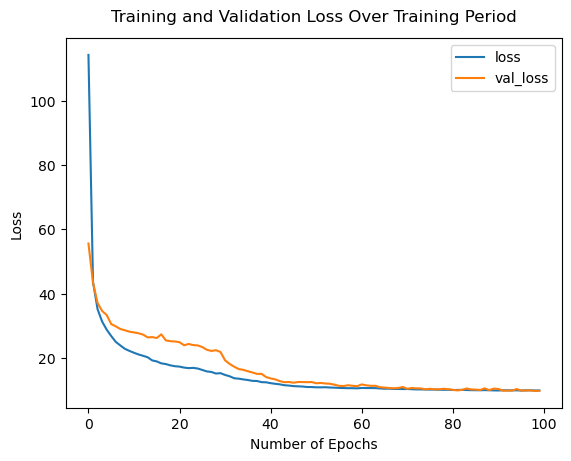

In [208]:
model_df = pd.DataFrame(history.history)
model_df[['loss', 'val_loss']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Training Period", pad=12);

### Accuracy

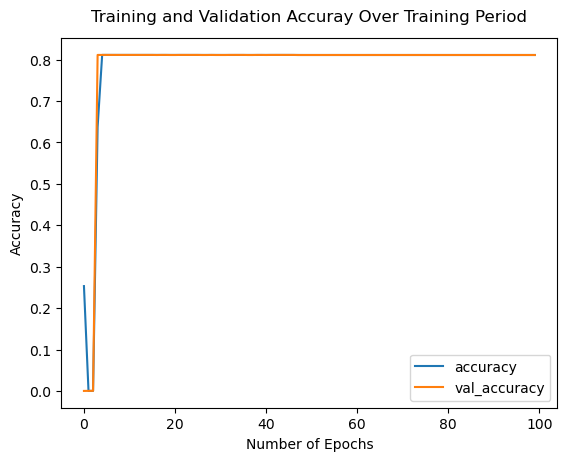

In [209]:
model_df[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuray Over Training Period", pad=12);

### Theory vs Predict

r: 0.90594%, st_er: 0.000886%
y = 0.8047*x + 0.3856


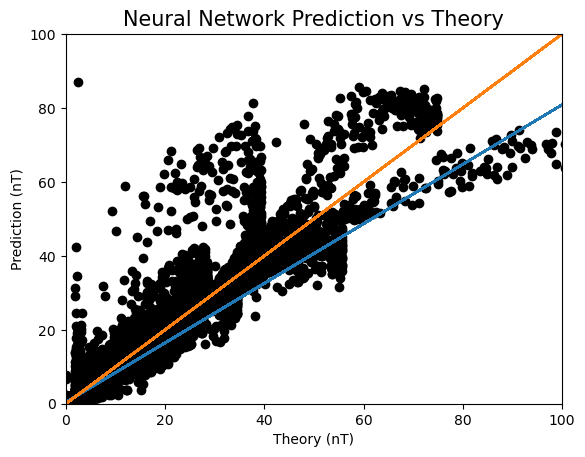

In [210]:
x = y_test.flatten()
y = test_pred.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, test_pred,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
plt.title("Neural Network Prediction vs Theory", fontsize=15)
# print(r, st_er)
print("r: {:.5f}%, st_er: {:.6f}%".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

### Theory vs Physics

In [133]:
df_p = df_physics[(df_physics['exp']==36) & (df_physics['mini_exp']==6)]

In [134]:
df_p[(df_p['i'] == 31) & (df_p['j'] == 31) & (df_p['k'] == 31) ]

,exp,mini_exp,i,j,k,mean
1030111,36,6,31,31,31,26.587303


r: 0.03909%, st_er: 0.030157%
y = 0.5008*x + -0.5819


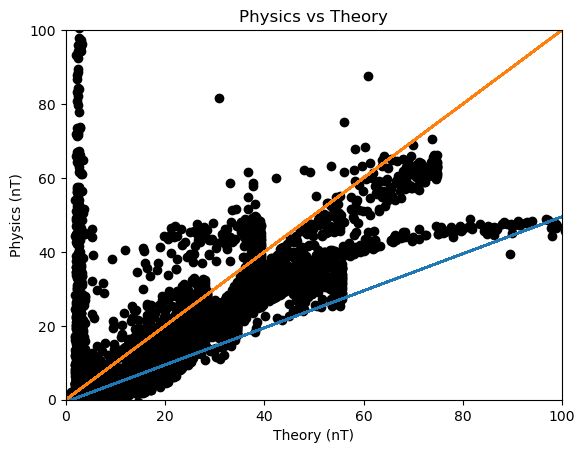

In [158]:
y_val = df_physics[(df_physics['exp']==36) & (df_physics['mini_exp']==6)]['mean'].values

x = y_test.flatten()
y = y_val.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, y_val,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Physics (nT)")
plt.title("Physics vs Theory", fontsize=15)
# print(r, st_er)
print("r: {:.5f}%, st_er: {:.6f}%".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

### Theory vs Drift correction

In [135]:
df_p = df_new[(df_new['exp']==36) & (df_new['mini_exp']==6)]

In [136]:
df_p[(df_p['i'] == 31) & (df_p['j'] == 31) & (df_p['k'] == 31) ]

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory,new0,new1,new2,new3,new4,slope,intercept,6minus4,10minus4
1030111,36,6,31,31,31,118.332359,144.919662,101.000153,61.330914,88.01812,34.932812,-0.095668,-3.603895,2.191337,7.42574,3.904332,-7.57856,117.60733,-3.508226,7.521409


In [126]:
df_new

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory,new0,new1,new2,new3,new4,slope,intercept,6minus4,10minus4
0,36,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36,1,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36,1,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36,1,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244027,38,6,43,63,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3244028,38,6,43,63,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3244029,38,6,43,63,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3244030,38,6,43,63,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


r: 0.08001%, st_er: 0.018524%
y = 0.6312*x + 0.3508


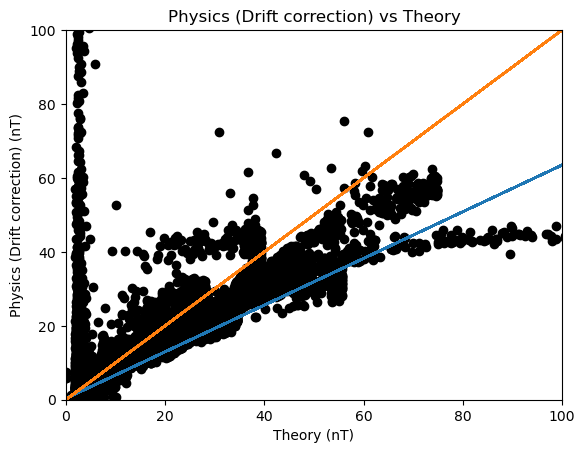

In [157]:
y_val = df_new['value'].values

x = y_test.flatten()
y = y_val.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, y_val,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Physics (Drift correction) (nT)")
plt.title("Physics (Drift correction) vs Theory")
# print(r, st_er)
print("r: {:.5f}%, st_er: {:.6f}%".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

# Output data

In [161]:
df_test['predict'] = test_pred

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_5774/4195812830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = test_pred


In [164]:
np.savetxt(img_path+"nn.txt", df_test[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [163]:
df_test

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory,predict
901120,36,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.035731
901121,36,6,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.035731
901122,36,6,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.035731
901123,36,6,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.035731
901124,36,6,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.035731
...,...,...,...,...,...,...,...,...,...,...,...,...
1081339,36,6,43,63,59,0.0,0.0,0.0,0.0,0.0,0.0,0.035731
1081340,36,6,43,63,60,0.0,0.0,0.0,0.0,0.0,0.0,0.035731
1081341,36,6,43,63,61,0.0,0.0,0.0,0.0,0.0,0.0,0.035731
1081342,36,6,43,63,62,0.0,0.0,0.0,0.0,0.0,0.0,0.035731


## AdaBoost

In [77]:
shape = (len(X_train[0]),)
def create_model(optimizer="adam"):
    model = keras.Sequential()
    model.add(Dense(8, activation='relu', input_shape=shape)) 
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mse', metrics=["accuracy"])
    return model

In [ ]:
estimator = KerasRegressor(model=create_model, verbose=1)

In [412]:
ada = AdaBoostRegressor(base_estimator=estimator, random_state=1)
# Default
# n_estimateors = 50, learning_rate = 1.0, loss = 'linear'

In [413]:
ada.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=[X_test, y_test])

Epoch 1/250
14080/14080 [==============================] - 16s 1ms/step - loss: 55.7692 - accuracy: 0.8112 - val_loss: 36.1058 - val_accuracy: 0.8112
Epoch 2/250
14080/14080 [==============================] - 14s 1ms/step - loss: 27.6695 - accuracy: 0.8113 - val_loss: 26.9031 - val_accuracy: 0.8112
Epoch 3/250
14080/14080 [==============================] - 14s 1ms/step - loss: 22.8049 - accuracy: 0.8113 - val_loss: 24.5247 - val_accuracy: 0.8114
Epoch 4/250
14080/14080 [==============================] - 15s 1ms/step - loss: 20.9147 - accuracy: 0.8114 - val_loss: 22.0434 - val_accuracy: 0.8114
Epoch 5/250
14080/14080 [==============================] - 14s 1ms/step - loss: 19.7160 - accuracy: 0.8114 - val_loss: 21.2492 - val_accuracy: 0.8112
Epoch 6/250
14080/14080 [==============================] - 14s 1ms/step - loss: 18.6955 - accuracy: 0.8114 - val_loss: 19.8251 - val_accuracy: 0.8112
Epoch 7/250
14080/14080 [==============================] - 14s 1ms/step - loss: 18.0138 - accuracy: 

14080/14080 [==============================] - 14s 1ms/step - loss: 10.5037 - accuracy: 0.8112 - val_loss: 10.6257 - val_accuracy: 0.8112
Epoch 110/250
14080/14080 [==============================] - 15s 1ms/step - loss: 10.4818 - accuracy: 0.8112 - val_loss: 10.5354 - val_accuracy: 0.8112
Epoch 111/250
14080/14080 [==============================] - 15s 1ms/step - loss: 10.4896 - accuracy: 0.8112 - val_loss: 11.1370 - val_accuracy: 0.8112
Epoch 112/250
14080/14080 [==============================] - 14s 1ms/step - loss: 10.4858 - accuracy: 0.8112 - val_loss: 10.6094 - val_accuracy: 0.8112
Epoch 113/250
14080/14080 [==============================] - 15s 1ms/step - loss: 10.4953 - accuracy: 0.8112 - val_loss: 10.9372 - val_accuracy: 0.8112
Epoch 114/250
14080/14080 [==============================] - 14s 1ms/step - loss: 10.5086 - accuracy: 0.8112 - val_loss: 10.4391 - val_accuracy: 0.8112
Epoch 115/250
14080/14080 [==============================] - 15s 1ms/step - loss: 10.4773 - accuracy: 

Epoch 163/250
14080/14080 [==============================] - 14s 1ms/step - loss: 10.1857 - accuracy: 0.8112 - val_loss: 10.1182 - val_accuracy: 0.8112
Epoch 164/250
14080/14080 [==============================] - 14s 1ms/step - loss: 10.1667 - accuracy: 0.8112 - val_loss: 10.2620 - val_accuracy: 0.8112
Epoch 165/250
14080/14080 [==============================] - 15s 1ms/step - loss: 10.1372 - accuracy: 0.8112 - val_loss: 10.0696 - val_accuracy: 0.8112
Epoch 166/250
14080/14080 [==============================] - 14s 1ms/step - loss: 10.1394 - accuracy: 0.8112 - val_loss: 10.1461 - val_accuracy: 0.8112
Epoch 167/250
14080/14080 [==============================] - 14s 1ms/step - loss: 10.1660 - accuracy: 0.8112 - val_loss: 10.3212 - val_accuracy: 0.8112
Epoch 168/250
14080/14080 [==============================] - 15s 1ms/step - loss: 10.1706 - accuracy: 0.8112 - val_loss: 10.1032 - val_accuracy: 0.8112
Epoch 169/250
14080/14080 [==============================] - 15s 1ms/step - loss: 10.186

Epoch 217/250
14080/14080 [==============================] - 13s 958us/step - loss: 10.0500 - accuracy: 0.8112 - val_loss: 10.0699 - val_accuracy: 0.8112
Epoch 218/250
14080/14080 [==============================] - 14s 964us/step - loss: 10.0393 - accuracy: 0.8112 - val_loss: 10.0689 - val_accuracy: 0.8112
Epoch 219/250
14080/14080 [==============================] - 14s 965us/step - loss: 10.0445 - accuracy: 0.8112 - val_loss: 10.1081 - val_accuracy: 0.8112
Epoch 220/250
14080/14080 [==============================] - 13s 959us/step - loss: 9.9857 - accuracy: 0.8112 - val_loss: 10.0993 - val_accuracy: 0.8112
Epoch 221/250
14080/14080 [==============================] - 14s 963us/step - loss: 10.0068 - accuracy: 0.8112 - val_loss: 10.1473 - val_accuracy: 0.8112
Epoch 222/250
14080/14080 [==============================] - 14s 969us/step - loss: 9.9952 - accuracy: 0.8112 - val_loss: 10.2371 - val_accuracy: 0.8112
Epoch 223/250
14080/14080 [==============================] - 14s 972us/step - 

In [414]:
train_pred = ada.predict(X_train)
print(mse(train_pred, y_train))
print(mape(train_pred, y_train))
test_pred = ada.predict(X_test)
print(mse(test_pred, y_test))
print(mape(test_pred, y_test))

28160/28160 [==============================] - 19s 657us/step
10.423523569637522
0.8851849821396331
5632/5632 [==============================] - 4s 675us/step
10.430708006166368
0.901582623329384


In [415]:
ada.score(X_test, y_test)

5632/5632 [==============================] - 5s 914us/step - loss: 10.4307 - accuracy: 0.8112


[10.43068790435791, 0.8112127184867859]

In [416]:
np.corrcoef(test_pred.flatten(), y_test)

array([[1.        , 0.89977946],
       [0.89977946, 1.        ]])

In [415]:
ada.evaluate(X_test, y_test)

5632/5632 [==============================] - 5s 914us/step - loss: 10.4307 - accuracy: 0.8112


[10.43068790435791, 0.8112127184867859]

In [416]:
np.corrcoef(test_pred.flatten(), y_test)

array([[1.        , 0.89977946],
       [0.89977946, 1.        ]])

In [417]:
ada.summary()

Model: "sequential_366"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1821 (Dense)          (None, 8)                 48        
                                                                 
 dense_1822 (Dense)          (None, 8)                 72        
                                                                 
 dense_1823 (Dense)          (None, 8)                 72        
                                                                 
 dense_1824 (Dense)          (None, 1)                 9         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [418]:
history.history

{'loss': [55.769195556640625,
  27.669540405273438,
  22.804916381835938,
  20.91471290588379,
  19.715959548950195,
  18.695512771606445,
  18.013818740844727,
  17.217145919799805,
  16.686649322509766,
  16.031967163085938,
  15.589828491210938,
  15.294617652893066,
  15.02783489227295,
  14.763344764709473,
  14.597732543945312,
  14.323282241821289,
  14.098736763000488,
  13.907633781433105,
  13.798909187316895,
  13.676118850708008,
  13.636869430541992,
  13.545592308044434,
  13.4127779006958,
  13.43098258972168,
  13.341645240783691,
  13.244627952575684,
  13.187355995178223,
  13.081528663635254,
  13.008316993713379,
  12.942736625671387,
  12.819374084472656,
  12.7421293258667,
  12.636713027954102,
  12.594244003295898,
  12.439692497253418,
  12.313486099243164,
  12.158864974975586,
  12.000682830810547,
  11.837697982788086,
  11.773954391479492,
  11.691145896911621,
  11.651338577270508,
  11.598064422607422,
  11.588747024536133,
  11.637275695800781,
  11.5778

## Plot

### Loss function (MSE)

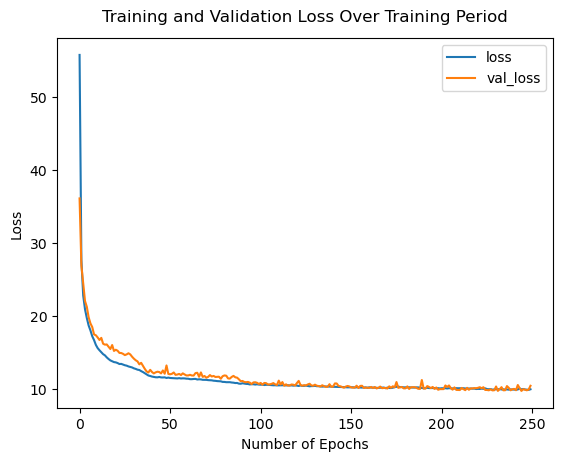

In [419]:
model_df = pd.DataFrame(history.history)
model_df[['loss', 'val_loss']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Training Period", pad=12);

### Accuracy

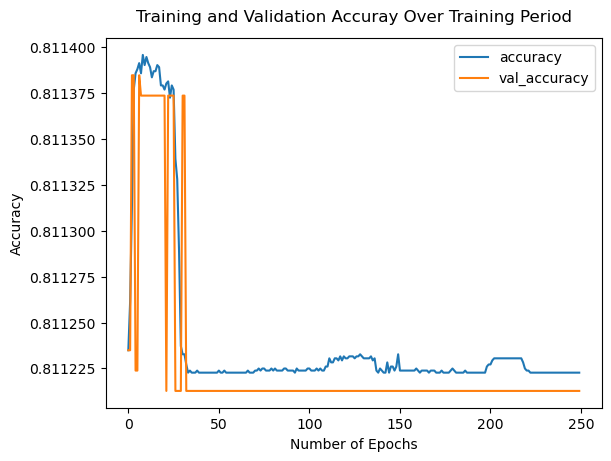

In [420]:
model_df[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuray Over Training Period", pad=12);

### Theory vs Predict

r: 0.89978%, st_er: 0.000909%
y = 0.7959*x + 0.3686


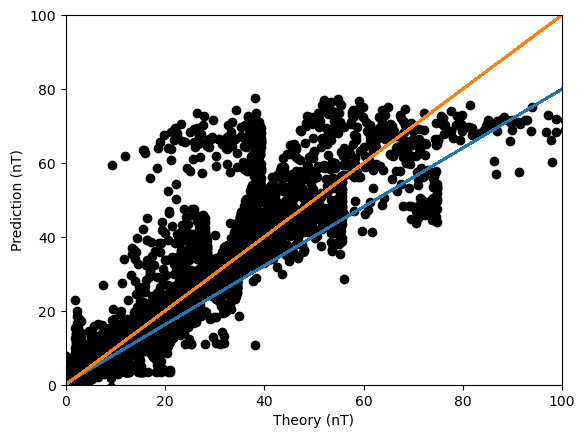

In [421]:
x = y_test.flatten()
y = test_pred.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, test_pred,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
# print(r, st_er)
print("r: {:.5f}%, st_er: {:.6f}%".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

## 7 Layer & 7 Units

In [424]:
model2 = keras.Sequential()
model2.add(Dense(7, activation='relu', input_shape=shape)) 
model2.add(Dense(7, activation='relu'))
model2.add(Dense(7, activation='relu'))
model2.add(Dense(7, activation='relu'))
model2.add(Dense(7, activation='relu'))
model2.add(Dense(7, activation='relu'))
model2.add(Dense(1, activation='linear'))
model2.compile(optimizer='adamax', loss='mse', metrics=["accuracy"])

In [425]:
history2 = model2.fit(X_train, y_train, epochs=250, batch_size=64, validation_data=[X_test, y_test])


Epoch 1/250
14080/14080 [==============================] - 16s 1ms/step - loss: 1046.3302 - accuracy: 0.6335 - val_loss: 50.4146 - val_accuracy: 5.5487e-06
Epoch 2/250
14080/14080 [==============================] - 15s 1ms/step - loss: 37.4836 - accuracy: 1.9975e-05 - val_loss: 36.4136 - val_accuracy: 1.6646e-05
Epoch 3/250
14080/14080 [==============================] - 15s 1ms/step - loss: 30.0406 - accuracy: 0.4021 - val_loss: 30.3933 - val_accuracy: 0.8114
Epoch 4/250
14080/14080 [==============================] - 15s 1ms/step - loss: 23.5442 - accuracy: 0.8114 - val_loss: 26.1573 - val_accuracy: 0.8114
Epoch 5/250
14080/14080 [==============================] - 15s 1ms/step - loss: 21.3196 - accuracy: 0.8114 - val_loss: 24.9365 - val_accuracy: 0.8114
Epoch 6/250
14080/14080 [==============================] - 15s 1ms/step - loss: 19.2122 - accuracy: 0.8114 - val_loss: 23.3855 - val_accuracy: 0.8114
Epoch 7/250
14080/14080 [==============================] - 15s 1ms/step - loss: 17.555

14080/14080 [==============================] - 15s 1ms/step - loss: 9.8826 - accuracy: 0.8113 - val_loss: 10.1667 - val_accuracy: 0.8114
Epoch 110/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.8702 - accuracy: 0.8113 - val_loss: 10.2380 - val_accuracy: 0.8114
Epoch 111/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.9415 - accuracy: 0.8113 - val_loss: 10.3431 - val_accuracy: 0.8112
Epoch 112/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.8992 - accuracy: 0.8113 - val_loss: 9.8778 - val_accuracy: 0.8112
Epoch 113/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.8730 - accuracy: 0.8113 - val_loss: 9.9043 - val_accuracy: 0.8112
Epoch 114/250
14080/14080 [==============================] - 16s 1ms/step - loss: 9.8435 - accuracy: 0.8113 - val_loss: 9.8660 - val_accuracy: 0.8114
Epoch 115/250
14080/14080 [==============================] - 16s 1ms/step - loss: 9.7887 - accuracy: 0.8114 - v

14080/14080 [==============================] - 15s 1ms/step - loss: 9.3218 - accuracy: 0.8112 - val_loss: 9.7826 - val_accuracy: 0.8112
Epoch 218/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.3371 - accuracy: 0.8112 - val_loss: 9.5755 - val_accuracy: 0.8112
Epoch 219/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.3799 - accuracy: 0.8112 - val_loss: 9.5253 - val_accuracy: 0.8112
Epoch 220/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.3626 - accuracy: 0.8112 - val_loss: 9.8951 - val_accuracy: 0.8114
Epoch 221/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.3454 - accuracy: 0.8112 - val_loss: 9.8686 - val_accuracy: 0.8112
Epoch 222/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.3895 - accuracy: 0.8112 - val_loss: 9.7116 - val_accuracy: 0.8112
Epoch 223/250
14080/14080 [==============================] - 15s 1ms/step - loss: 9.3628 - accuracy: 0.8112 - val_

In [426]:
train_pred2 = model2.predict(X_train)
print(mse(train_pred2, y_train))
print(mape(train_pred2, y_train))
test_pred2 = model2.predict(X_test)
print(mse(test_pred2, y_test))
print(mape(test_pred2, y_test))

28160/28160 [==============================] - 19s 688us/step
9.358524265784618
1.0455638406507
5632/5632 [==============================] - 4s 684us/step
9.481934435458676
1.0716621402362292


In [427]:
model2.evaluate(X_test, y_test)

5632/5632 [==============================] - 5s 866us/step - loss: 9.4819 - accuracy: 0.8114


[9.481929779052734, 0.8113680481910706]

In [428]:
np.corrcoef(test_pred2.flatten(), y_test)

array([[1.        , 0.90958548],
       [0.90958548, 1.        ]])

In [429]:
model2.summary()

Model: "sequential_367"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1825 (Dense)          (None, 7)                 42        
                                                                 
 dense_1826 (Dense)          (None, 7)                 56        
                                                                 
 dense_1827 (Dense)          (None, 7)                 56        
                                                                 
 dense_1828 (Dense)          (None, 7)                 56        
                                                                 
 dense_1829 (Dense)          (None, 7)                 56        
                                                                 
 dense_1830 (Dense)          (None, 7)                 56        
                                                                 
 dense_1831 (Dense)          (None, 1)              

In [430]:
history2.history

{'loss': [1046.3302001953125,
  37.483638763427734,
  30.040592193603516,
  23.54417610168457,
  21.3195743560791,
  19.2121524810791,
  17.55561065673828,
  16.830585479736328,
  16.048370361328125,
  15.718413352966309,
  15.15301513671875,
  15.153763771057129,
  14.874509811401367,
  14.767585754394531,
  14.562233924865723,
  14.444123268127441,
  14.237424850463867,
  14.06949234008789,
  14.089621543884277,
  13.76307487487793,
  13.555024147033691,
  13.057135581970215,
  12.235762596130371,
  11.770852088928223,
  11.562379837036133,
  11.483296394348145,
  11.319560050964355,
  11.235815048217773,
  11.137860298156738,
  11.024914741516113,
  11.009836196899414,
  10.948224067687988,
  10.913586616516113,
  10.88810920715332,
  10.812581062316895,
  10.799149513244629,
  10.786332130432129,
  10.751015663146973,
  10.730430603027344,
  10.720365524291992,
  10.669264793395996,
  10.594901084899902,
  10.573263168334961,
  10.512391090393066,
  10.481739044189453,
  10.4234876

## Plot

### Loss function (MSE)

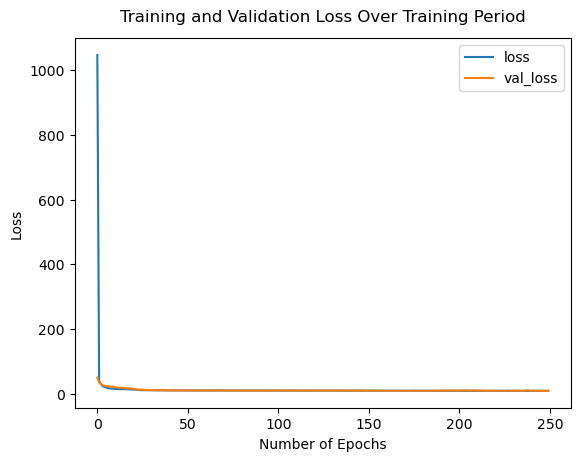

In [431]:
model_df = pd.DataFrame(history2.history)
model_df[['loss', 'val_loss']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Training Period", pad=12);

### Accuracy

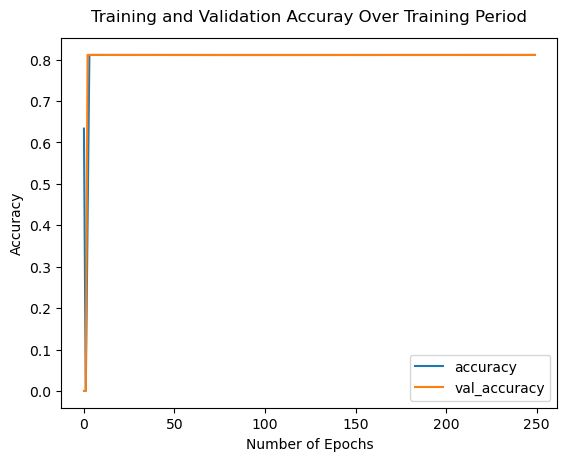

In [432]:
model_df[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuray Over Training Period", pad=12);

### Theory vs Predict

r: 0.90959%, st_er: 0.000871%
y = 0.8097*x + 0.2675


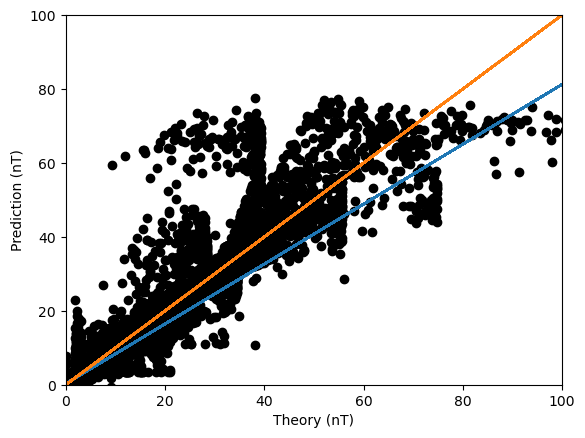

In [433]:
x = y_test.flatten()
y = test_pred2.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, test_pred,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
# print(r, st_er)
print("r: {:.5f}%, st_er: {:.6f}%".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

# Output data

In [434]:
df_test['predict2'] = test_pred2

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_34777/3425069941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict2'] = test_pred2


In [435]:
np.savetxt(save_path+"nn2.txt", df_test[['i', 'j', 'k', 'predict2']], fmt="%i %i %i %s")

# Old Code

In [157]:
model2 = keras.Sequential()

model2.add(Dense(1, activation='relu', input_shape=(5,)))
model2.add(Dense(1, activation="linear"))

# model2.add(Dense(5, activation='relu', input_shape=(5,)))
# model2.add(Dense(3, activation='relu'))
# model2.add(Dense(1, activation="linear"))
# # Coef 0.7665, MSE 23.21, MAPE 0.9155, Accuracy 0.8112

# model2.add(Dense(20, activation='relu', input_shape=(5,)))
# model2.add(Dense(10, activation='relu'))
# model2.add(Dense(5, activation='relu'))
# model2.add(Dense(1, activation="linear"))
# # Coef 0.7815, MSE 22.56, MAPE 0.9038, Accuracy 0.8112 

# model2.add(Dense(10, activation='relu', input_shape=(5,)))
# model2.add(Dense(10, activation='relu'))
# model2.add(Dense(10, activation='relu'))
# model2.add(Dense(1, activation="linear"))
# # Coef 0.7894, MSE 21.13, MAPE 0.8703, Accuracy 0.8112 => Best

# model2.add(Dense(10, activation='relu', input_shape=(5,)))
# model2.add(Dense(10, activation='relu'))
# model2.add(Dense(1, activation="linear"))
# # Coef 0.7786, MSE 22.19, MAPE 0.8877, Accuracy 0.8112

# model2.add(Dense(20, activation='relu', input_shape=[len(X_train[0])]))
# model2.add(Dense(1))
# # Coef 0.71174903, MSE 28.1933, MAPE 0.9055, Accuracy 0.8114


### BAD ###
# model2.add(Dense(100, activation='relu', input_shape=(5,)))
# model2.add(Dense(50, activation='relu'))
# model2.add(Dense(10, activation='relu'))
# model2.add(Dense(1, activation="linear"))
# # Coef 0.5541, MSE 38.85, MAPE 1.134, Accuracy 0.8112 => Worse

# model2.add(Dense(10, activation='relu', input_shape=(5,)))
# model2.add(Dense(5, activation='relu'))
# model2.add(Dense(3, activation='relu'))
# model2.add(Dense(1, activation="linear"))
# # Coef None, MSE 56.06, MAPE 1.656, Accuracy 5.5487e-06 => Worse

# model2.add(Dense(10, activation='relu', input_shape=(5,)))
# model2.add(Dense(5, activation='relu'))
# model2.add(Dense(1, activation="linear"))
# # Coef 0.7285, MSE 26.74, MAPE 1.5369, Accuracy 0.8114 => Bad

# model2.add(Dense(5, activation='relu', input_shape=[len(X_train[0])]))
# model2.add(Dense(5, activation='relu'))
# model2.add(Dense(5, activation='relu'))
# model2.add(Dense(1))
# # Coef 0.7833, MSE 21.68 MAPE 1.197, Accuracy 0.8112 

model2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=100, validation_data=[X_test, y_test], callbacks=myCallbacks)


Epoch 1/100
 9015/28160 [========>.....................] - ETA: 16s - loss: 56.3059 - accuracy: 0.1151

KeyboardInterrupt: 

In [60]:
train_pred2 = model2.predict(X_train)
print(mse(train_pred2, y_train))
print(mape(train_pred2, y_train))
test_pred2 = model2.predict(X_test)
print(mse(test_pred2, y_test))
print(mape(test_pred2, y_test))

28160/28160 [==============================] - 20s 697us/step
11.214849205358673
0.8891644970950675
5632/5632 [==============================] - 4s 680us/step
11.220028543186952
0.9035458755417451


In [106]:
arr = np.corrcoef(test_pred2.flatten(), y_test)

In [108]:
arr

array([[1.        , 0.89192917],
       [0.89192917, 1.        ]])

In [62]:
ev = model2.evaluate(X_test, y_test)

5632/5632 [==============================] - 5s 834us/step - loss: 11.2200 - accuracy: 0.8112


In [72]:
ev[1]

0.8112127184867859

In [364]:
model2.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 10)                60        
                                                                 
 dense_128 (Dense)           (None, 10)                110       
                                                                 
 dense_129 (Dense)           (None, 10)                110       
                                                                 
 dense_130 (Dense)           (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [365]:
history2.history

{'loss': [70.53611755371094,
  23.023168563842773,
  22.059120178222656,
  21.485179901123047,
  21.023574829101562,
  21.458295822143555,
  20.747465133666992,
  20.87920379638672,
  20.674291610717773,
  20.560890197753906,
  20.375850677490234],
 'accuracy': [0.8095003962516785,
  0.8013139367103577,
  0.7952991724014282,
  0.7956908941268921,
  0.7943170666694641,
  0.7915316224098206,
  0.8020529747009277,
  0.7983931303024292,
  0.7977461218833923,
  0.8100963234901428,
  0.8075761198997498],
 'val_loss': [31.34503936767578,
  23.02967071533203,
  23.319063186645508,
  22.255678176879883,
  22.685558319091797,
  22.644386291503906,
  22.474851608276367,
  22.245553970336914,
  23.826812744140625,
  23.19800567626953,
  21.347797393798828],
 'val_accuracy': [0.8113847374916077,
  0.8113847374916077,
  0.8113791942596436,
  0.8112071752548218,
  0.8112071752548218,
  0.8112127184867859,
  0.8112071752548218,
  0.8112127184867859,
  0.8112071752548218,
  0.8112127184867859,
  0.8112

## Plot

### Loss function (MSE)

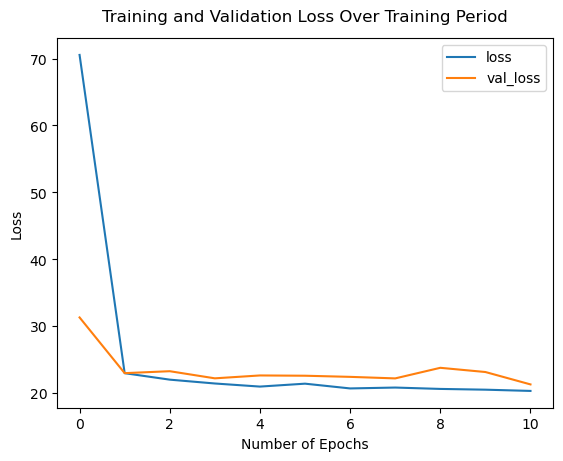

In [391]:
model_df = pd.DataFrame(history2.history)
model_df[['loss', 'val_loss']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Training Period", pad=12);

### Accuracy

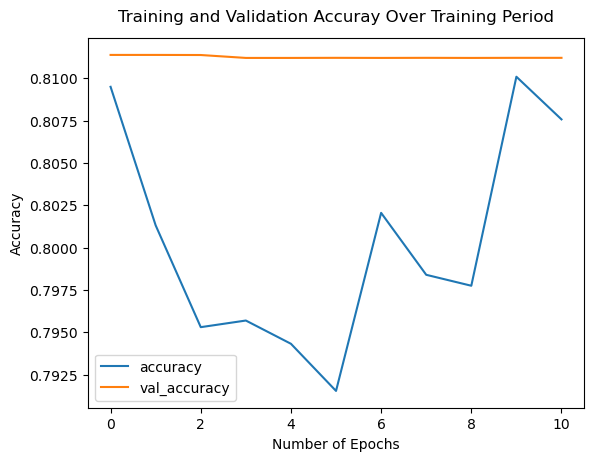

In [392]:
model_df[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuray Over Training Period", pad=12);

### Theory vs Predict

r: 0.78695%, st_er: 0.001142%
y = 0.6185*x + 0.7269


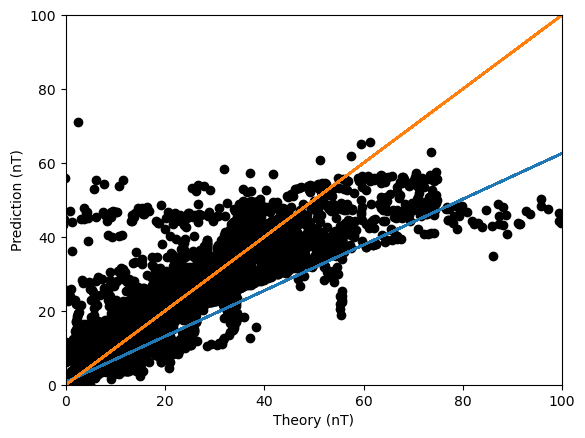

In [393]:
x = y_test.flatten()
y = test_pred2.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, test_pred2,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
# print(r, st_er)
print("r: {:.5f}%, st_er: {:.6f}%".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

# Output data

In [369]:
df_test['predict'] = test_pred2

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_82638/3293406254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = test_pred2


In [370]:
np.savetxt(save_path+"nn.txt", df_test[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

# MLPRegressor

In [63]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, hidden_layer_sizes = (10,10,10), max_iter=500).fit(X_train, y_train)

In [64]:
regr.score(X_test, y_test)

0.7235479854252406

In [65]:
y_predict = regr.predict(X_test)

In [66]:
np.corrcoef(y_predict,y_test)

array([[1.        , 0.85849349],
       [0.85849349, 1.        ]])

# Compare each dataset

## Data1: fmap means all experiments

In [176]:
X_train = X1_train
y_train = y1_train
X_test = X1_test
y_test = y1_test

In [177]:
model = keras.Sequential()
model.add(Dense(10, activation='relu', input_shape=[len(X_train[0])]))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
#
model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, verbose=0, validation_data=[X_test, y_test])

In [178]:
train_pred = model.predict(X_train)
print(mse(train_pred, y_train))
test_pred = model.predict(X_test)
print(mse(test_pred, y_test))

70964/70964 [==============================] - 54s 761us/step
30.170082550978588
30413/30413 [==============================] - 25s 830us/step
37.97403427399727


In [179]:
r2_score(y_test, test_pred)

0.5055974148648721

In [180]:
model.evaluate(X_test, y_test)

30413/30413 [==============================] - 25s 811us/step - loss: 37.9739 - accuracy: 0.8084


[37.97385787963867, 0.8083938956260681]

In [181]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 10)                60        
                                                                 
 dense_37 (Dense)            (None, 10)                110       
                                                                 
 dense_38 (Dense)            (None, 10)                110       
                                                                 
 dense_39 (Dense)            (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


## Data2: One experiment

In [182]:
X_train = X2_train
y_train = y2_train
X_test = X2_test
y_test = y2_test

In [183]:
model2 = keras.Sequential()
model2.add(Dense(10, activation='relu', input_shape=[len(X_train[0])]))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1))

#
model2.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=20, verbose=0, validation_data=[X_test, y_test])


In [184]:
train_pred2 = model2.predict(X_train)
print(mse(train_pred2, y_train))
test_pred2 = model2.predict(X_test)
print(mse(test_pred2, y_test))

28160/28160 [==============================] - 21s 737us/step
10.787611349421352
5632/5632 [==============================] - 4s 720us/step
11.598423677038422


In [185]:
r2_score(y_test, test_pred2)

0.7879580102236565

In [186]:
model2.evaluate(X_test, y_test)

5632/5632 [==============================] - 5s 872us/step - loss: 11.5982 - accuracy: 0.8112


[11.598172187805176, 0.8112071752548218]

In [187]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 10)                60        
                                                                 
 dense_41 (Dense)            (None, 10)                110       
                                                                 
 dense_42 (Dense)            (None, 10)                110       
                                                                 
 dense_43 (Dense)            (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


## Data3: 55 fmap means

In [188]:
X_train = X3_train
y_train = y3_train
X_test = X3_test
y_test = y3_test

In [189]:
model3 = keras.Sequential()
model3.add(Dense(10, activation='relu', input_shape=[len(X_train[0])]))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(1))
#
model3.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=20, verbose=0, validation_data=[X_test, y_test])


In [190]:
train_pred3 = model3.predict(X_train)
print(mse(train_pred3, y_train))
test_pred3 = model3.predict(X_test)
print(mse(test_pred3, y_test))

70964/70964 [==============================] - 49s 691us/step
25.653226663055843
30413/30413 [==============================] - 21s 679us/step
33.91757302155358


In [191]:
r2_score(y_test, test_pred3)

0.5584104743159171

In [192]:
model3.evaluate(X_test, y_test)

30413/30413 [==============================] - 25s 809us/step - loss: 33.9176 - accuracy: 0.8084


[33.9175910949707, 0.8083938956260681]

In [193]:
model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 10)                560       
                                                                 
 dense_45 (Dense)            (None, 10)                110       
                                                                 
 dense_46 (Dense)            (None, 10)                110       
                                                                 
 dense_47 (Dense)            (None, 1)                 11        
                                                                 
Total params: 791
Trainable params: 791
Non-trainable params: 0
_________________________________________________________________


## Data4: None zero

In [39]:
X_train = X4_train
y_train = y4_train
X_test = X4_test
y_test = y4_test

In [28]:
model4 = keras.Sequential()
model4.add(Dense(20, activation='relu', input_shape=[len(X_train[0])]))
model4.add(Dense(1))
#
model4.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
history4 = model4.fit(X_train, y_train, epochs=20, validation_data=[X_test, y_test])


2022-10-26 12:02:18.273343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
13623/13623 [==============================] - 17s 1ms/step - loss: 775.6888 - accuracy: 5.0696e-04 - val_loss: 280.3866 - val_accuracy: 9.8486e-04
Epoch 2/20
13623/13623 [==============================] - 16s 1ms/step - loss: 254.4488 - accuracy: 5.9642e-04 - val_loss: 239.9096 - val_accuracy: 4.8173e-05
Epoch 3/20
13623/13623 [==============================] - 16s 1ms/step - loss: 244.3139 - accuracy: 6.0331e-04 - val_loss: 426.1392 - val_accuracy: 0.0011
Epoch 4/20
13623/13623 [==============================] - 16s 1ms/step - loss: 234.7317 - accuracy: 6.1707e-04 - val_loss: 236.3913 - val_accuracy: 8.9922e-04
Epoch 5/20
13623/13623 [==============================] - 17s 1ms/step - loss: 226.6837 - accuracy: 6.7212e-04 - val_loss: 226.9637 - val_accuracy: 9.2063e-04
Epoch 6/20
13623/13623 [==============================] - 16s 1ms/step - loss: 217.3771 - accuracy: 6.9047e-04 - val_loss: 230.2182 - val_accuracy: 1.0705e-04
Epoch 7/20
13623/13623 [==========================

In [29]:
train_pred4 = model4.predict(X_train)
print(mse(train_pred4, y_train))
test_pred4 = model4.predict(X_test)
print(mse(test_pred4, y_test))

13623/13623 [==============================] - 10s 700us/step
184.91616526100555
5839/5839 [==============================] - 4s 672us/step
199.72171091691504


In [30]:
model4.evaluate(X_test, y_test)

5839/5839 [==============================] - 5s 777us/step - loss: 199.7217 - accuracy: 9.0458e-04


[199.72171020507812, 0.0009045753395184875]

In [31]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                120       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [32]:
history4.history

{'loss': [775.6888427734375,
  254.44879150390625,
  244.31385803222656,
  234.73170471191406,
  226.68370056152344,
  217.37705993652344,
  211.0164031982422,
  206.1196746826172,
  198.62127685546875,
  194.85061645507812,
  192.2696990966797,
  189.657470703125,
  189.12733459472656,
  187.17984008789062,
  187.6508331298828,
  186.62896728515625,
  186.11622619628906,
  185.31565856933594,
  184.93045043945312,
  184.64312744140625],
 'accuracy': [0.0005069597973488271,
  0.00059642328415066,
  0.0006033051176927984,
  0.0006170687265694141,
  0.0006721231620758772,
  0.0006904746405780315,
  0.0007202958222478628,
  0.0007019443437457085,
  0.0006812989013269544,
  0.0006124808569438756,
  0.0005207234062254429,
  0.0004725507751572877,
  0.0004174963105469942,
  0.0004129084409214556,
  0.00044731746311299503,
  0.0004886083188466728,
  0.00043584778904914856,
  0.0004771386447828263,
  0.00044731746311299503,
  0.00044731746311299503],
 'val_loss': [280.3866271972656,
  239.9096

## Plot

### Loss function (MSE)

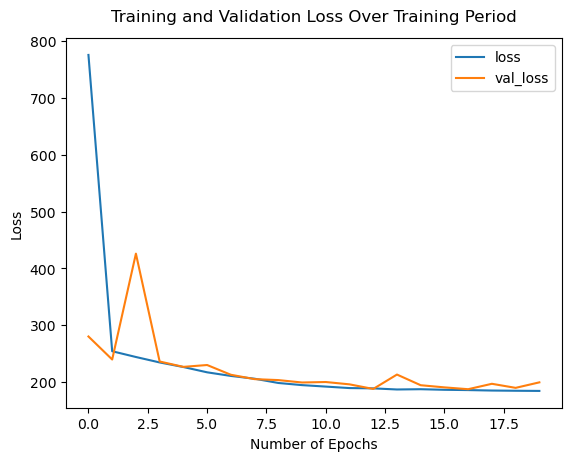

In [33]:
model_df = pd.DataFrame(history4.history)
model_df[['loss', 'val_loss']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Training Period", pad=12);

### Accuracy

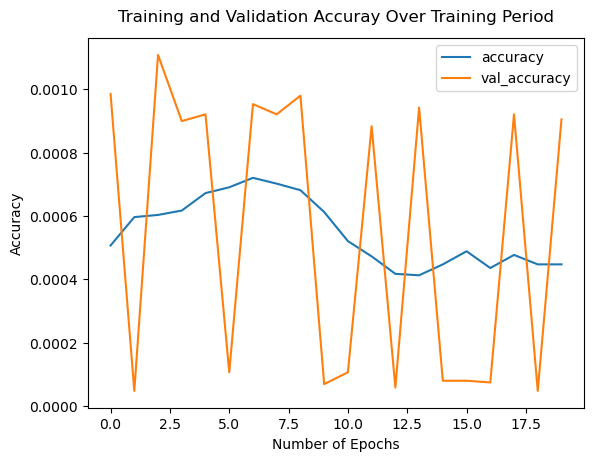

In [34]:
model_df[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuray Over Training Period", pad=12);

### Theory vs Predict

r: 0.55524%, st_er: 0.001131%
y = 0.3264*x + 7.3193


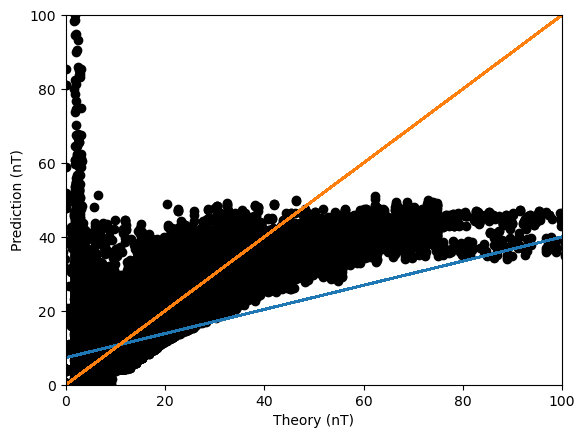

In [42]:
x = y_test.flatten()
y = test_pred4.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, test_pred4,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
# print(r, st_er)
print("r: {:.5f}%, st_er: {:.6f}%".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

# Output image data

In [115]:
df['predict'] = test_pred
df_test['predict'] = test_pred2
df_55['predict'] = test_pred3
df_on['predict'] = test_pred4

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_3032/2079570890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = test_pred
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_3032/2079570890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict2'] = test_pred2


In [116]:
np.savetxt(save_path+"nn.txt", df[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [117]:
np.savetxt(save_path+"nn2.txt", df_test[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [ ]:
np.savetxt(save_path+"nn3.txt", df_55[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [ ]:
np.savetxt(save_path+"nn4.txt", df_on[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

# Play Ground

In [54]:
NaN = np.nan
corr = [[0.087, 0.11, 0.13, 0.12, 0.13, 0.16, 0.14, 0.11, 0.12, 0.15],
       [0.37, 0.8, 0.79, 0.8, 0.69, 0.78, 0.60, 0.82, 0.8, 0.79],
       [0.36, 0.86, 0.89, 0.85, 0.85, 0.87, 0.84, 0.87, 0.89, 0.85],
       [NaN, NaN, NaN, 0.88, 0.86, 0.89, 0.85, 0.9, 0.85, 0.88],
       [NaN, NaN, 0.9, 0.88, 0.9, 0.87, 0.84, 0.89, 0.86, 0.9],
       [NaN, NaN, 0.73, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.89],
       [NaN, NaN, 0.85, 0.9, 0.88, 0.89, 0.9, 0.9, 0.9, 0.88],
       [NaN, 0.86, NaN, 0.88, 0.81, 0.9, 0.9, 0.89, 0.89, 0.87],
       [NaN, NaN, NaN, 0.9, 0.89, 0.89, 0.9, 0.89, 0.9, 0.9],
       [NaN, NaN, NaN, 0.87, 0.9, 0.88, 0.9, 0.89, 0.9, 0.9]
       ]

In [55]:
err = [[0.00084, 0.00075, 0.00088, 0.00073, 0.00086, 0.00089, 0.001, 0.00064, 0.0005, 0.0011],
       [0.00072, 0.001, 0.0011, 0.00091, 0.0014, 0.0012, 0.0015, 0.001, 0.00094, 0.00086],
       [0.0007, 0.00093, 0.00096, 0.00099, 0.00098, 0.00093, 0.0011, 0.00092, 0.00096, 0.00094],
       [0, 0, 0, 0.00093, 0.0012, 0.00091, 0.00099, 0.00086, 0.001, 0.0009],
       [0, 0, 0.00096, 0.00094, 0.00093, 0.0011, 0.0011, 0.00092, 0.0012, 0.00086],
       [0, 0, 0.0011, 0.00091, 0.00096, 0.0009, 0.00089, 0.0009, 0.00089, 0.00091],
       [0, 0, 0.0012, 0.00095, 0.00087, 0.0011, 0.00087, 0.00086, 0.00085, 0.00093],
       [0, 0.00087, 0, 0.0011, 0.0016, 0.00092, 0.00087, 0.0011, 0.00088, 0.0012],
       [0, 0, 0, 0.00094, 0.00085, 0.0009, 0.00087, 0.00087, 0.00096, 0.001],
       [0, 0, 0, 0.00098, 0.00089, 0.0011, 0.00097, 0.00096, 0.00094, 0.00096],
      ]

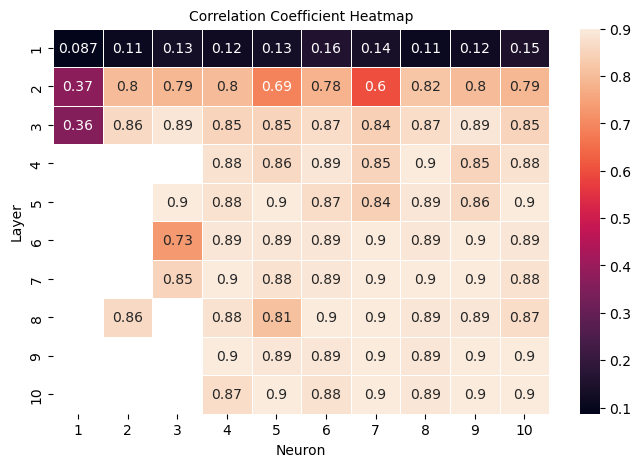

In [56]:
import seaborn as sns

xlabels = range(1, 11)
ylabels = range(1, 11)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(corr, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Correlation Coefficient Heatmap', fontsize=10)
ax.set_xlabel('Neuron', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

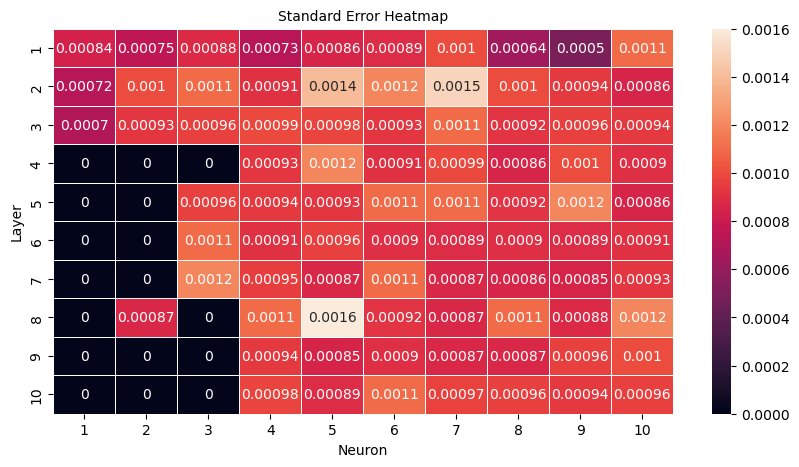

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(err, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True)
ax.set_title('Standard Error Heatmap', fontsize=10)
ax.set_xlabel('Neuron', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

In [93]:
div = np.divide(corr, err)
div = np.nan_to_num(div)
div

array([[ 103.57142857,  146.66666667,  147.72727273,  164.38356164,
         151.1627907 ,  179.7752809 ,  140.        ,  171.875     ,
         240.        ,  136.36363636],
       [ 513.88888889,  800.        ,  718.18181818,  879.12087912,
         492.85714286,  650.        ,  400.        ,  820.        ,
         851.06382979,  918.60465116],
       [ 514.28571429,  924.7311828 ,  927.08333333,  858.58585859,
         867.34693878,  935.48387097,  763.63636364,  945.65217391,
         927.08333333,  904.25531915],
       [   0.        ,    0.        ,    0.        ,  946.23655914,
         716.66666667,  978.02197802,  858.58585859, 1046.51162791,
         850.        ,  977.77777778],
       [   0.        ,    0.        ,  937.5       ,  936.17021277,
         967.74193548,  790.90909091,  763.63636364,  967.39130435,
         716.66666667, 1046.51162791],
       [   0.        ,    0.        ,  663.63636364,  978.02197802,
         927.08333333,  988.88888889, 1011.23595506,  988

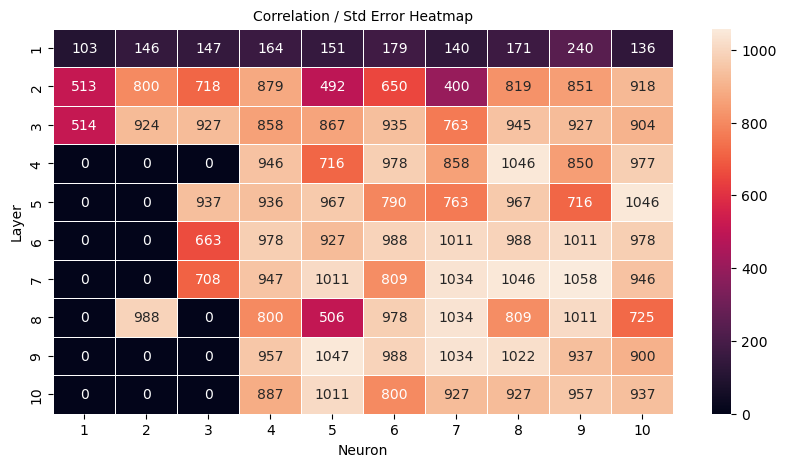

In [94]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(div.astype(int), linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True, fmt='d')
ax.set_title('Correlation / Std Error Heatmap', fontsize=10)
ax.set_xlabel('Neuron', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

In [61]:
loss = [[58, 56, 57, 56, 57, 56, 59, 55, 54, 59], 
        [48, 20, 21, 21, 30, 21, 30, 18, 20, 23], 
        [48, 15, 11, 15, 15, 13, 16, 14, 12, 16], 
        [55, 55, 55, 12, 15, 12, 15, 10, 15, 12], 
        [55, 55, 11, 13, 10, 14, 16, 12, 16, 11], 
        [55, 55, 26, 11, 11, 11, 10, 11, 11, 11], 
        [55, 55, 17, 11, 12, 12, 10, 10, 11, 12], 
        [55, 15, 55, 14, 25, 10, 11, 12, 11, 14], 
        [55, 55, 55, 11, 12, 12, 11, 11, 10, 11], 
        [55, 55, 55, 13, 11, 13, 10, 11, 10, 11]
       ]

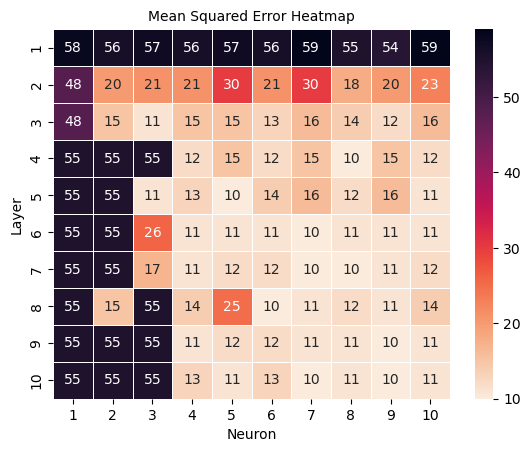

In [70]:
#fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(loss, linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True, cmap='rocket_r')
ax.set_title('Mean Squared Error Heatmap', fontsize=10)
ax.set_xlabel('Neuron', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()

In [89]:
div2 = np.divide(div.astype(int), loss)
div2

array([[  1.77586207,   2.60714286,   2.57894737,   2.92857143,
          2.64912281,   3.19642857,   2.37288136,   3.10909091,
          4.44444444,   2.30508475],
       [ 10.6875    ,  40.        ,  34.19047619,  41.85714286,
         16.4       ,  30.95238095,  13.33333333,  45.5       ,
         42.55      ,  39.91304348],
       [ 10.70833333,  61.6       ,  84.27272727,  57.2       ,
         57.8       ,  71.92307692,  47.6875    ,  67.5       ,
         77.25      ,  56.5       ],
       [  0.        ,   0.        ,   0.        ,  78.83333333,
         47.73333333,  81.5       ,  57.2       , 104.6       ,
         56.66666667,  81.41666667],
       [  0.        ,   0.        ,  85.18181818,  72.        ,
         96.7       ,  56.42857143,  47.6875    ,  80.58333333,
         44.75      ,  95.09090909],
       [  0.        ,   0.        ,  25.5       ,  88.90909091,
         84.27272727,  89.81818182, 101.1       ,  89.81818182,
         91.90909091,  88.90909091],
       [  

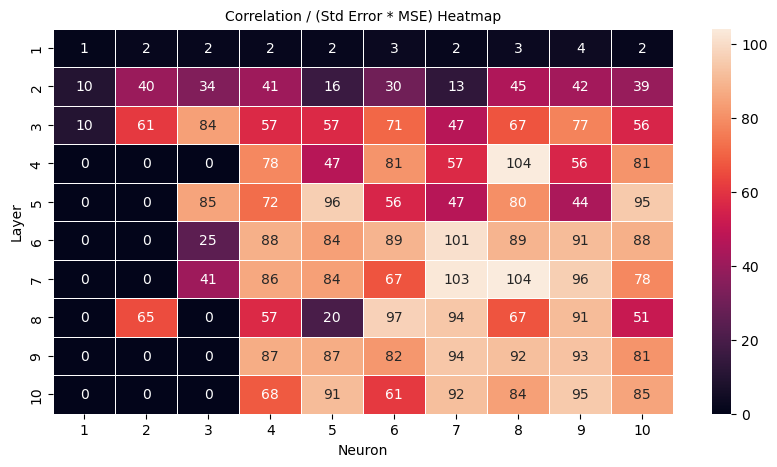

In [96]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(div2.astype(int), linewidth=0.5, xticklabels=xlabels, yticklabels=ylabels, annot=True, fmt='g')
ax.set_title('Correlation / (Std Error * MSE) Heatmap', fontsize=10)
ax.set_xlabel('Neuron', fontsize=10)
ax.set_ylabel('Layer', fontsize=10)
plt.show()